In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
import torch
print(torch.__version__)

0.4.1


In [2]:
from config import config as cfg
import random
import os
import numpy as np
import warnings

def init_env(gpu_id='0', seed=42):
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    warnings.filterwarnings('ignore')

PATH = './'
TRAIN = cfg.train_data
TEST = cfg.test_data
LABELS = cfg.train_csv
SAMPLE = cfg.submission_csv
init_env('5')

using data from linux


In [3]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
train_idx, val_idx = train_test_split(train_names, test_size=0.1, random_state=42)

In [4]:
import cv2

def open_image(path, image_id, use_yellow=False):
    colors = ['red', 'green', 'blue', 'yellow']
    img = [cv2.imread(os.path.join(path, image_id+'_'+color+'.png'), cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
           for color in colors]
    
    return np.stack(img, axis=-1)

In [5]:
from fastai.dataset import FilesDataset

class HPADataset(FilesDataset):

    def __init__(self,
                 fnames,
                 path,
                 transform,
                 use_yellow=True):
        self.train_df = pd.read_csv(cfg.train_csv).set_index('Id')
        self.train_df['Target'] = [
            [int(i) for i in s.split()] for s in self.train_df['Target']]
        self.use_yellow = use_yellow
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(self.path, self.fnames[i], self.use_yellow)
        if self.sz == 512:
            return img
        else:
            return cv2.resize(img, (self.sz, self.sz), cv2.INTER_AREA)

    def get_y(self, i):
        if(self.path == TEST):
            return np.zeros(len(cfg.label_names), dtype=np.int)
        else:
            labels = self.train_df.loc[self.fnames[i]]['Target']
            return np.eye(len(cfg.label_names), dtype=np.float)[labels].sum(axis=0)
    
    def get_c(self):
        return len(cfg.label_names)
    
    @property
    def is_multi(self):
        """是否是多标签的样本"""
        return True
        
    @property
    def is_reg(self):
        """是否是回归模型"""
        return True    

In [6]:
from fastai.transforms import tfms_from_stats, RandomRotate,RandomDihedral, RandomLighting
from fastai.dataset import ImageData, TfmType, A, CropType

def get_data(target_size, batch_size, n_workers=5):
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    # std and var
    stats = A([0.08069, 0.05258, 0.05487, 0.08282],
              [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, target_size,
                           crop_type=CropType.NO,
                           tfm_y=TfmType.NO,
                           aug_tfms=aug_tfms)

    datasets = ImageData.get_ds(HPADataset,
                               (train_idx[:-(len(train_idx) % batch_size)], TRAIN),
                               (val_idx, TRAIN), 
                               tfms,
                               test=(test_names, TEST))

    img_ds = ImageData(PATH, 
                       datasets, 
                       batch_size,
                       num_workers=n_workers, 
                       classes=None)

    return img_ds

将train data loader转化为迭代器

In [7]:
batch_size = 16
target_size = 256
img_ds = get_data(target_size, batch_size)
batch_x, batch_y = next(iter(img_ds.trn_dl))   # train loader
batch_x.shape, batch_y.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 28]))

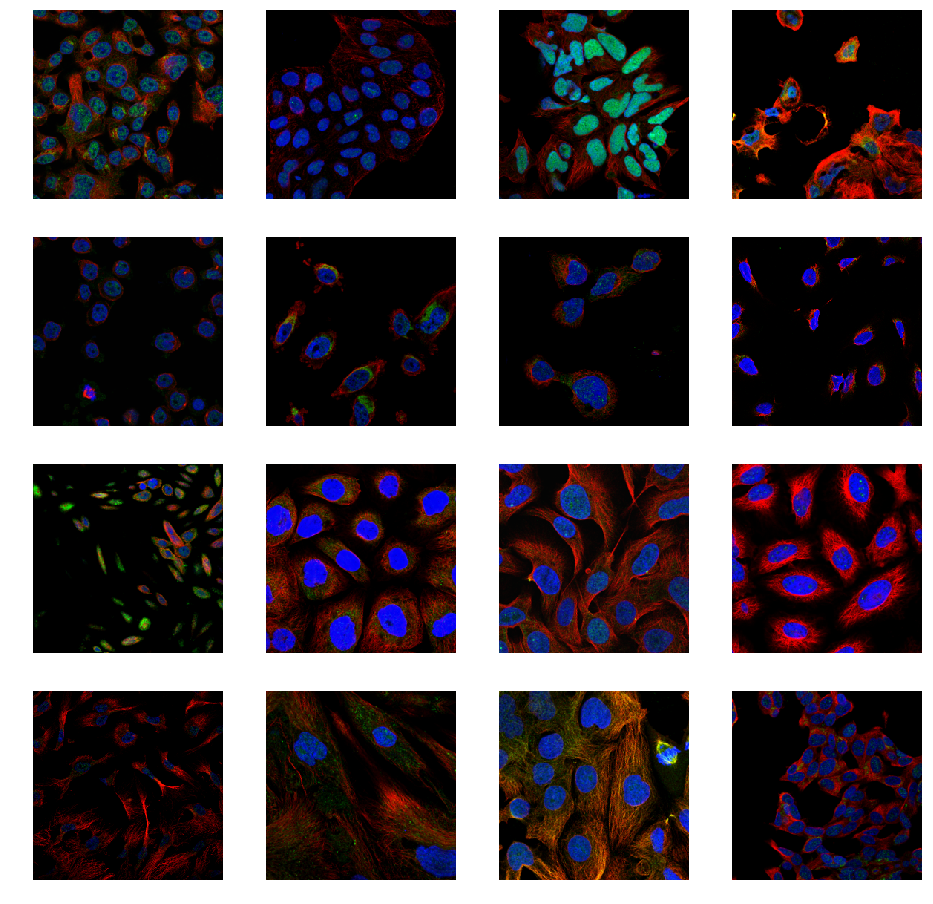

In [8]:
from matplotlib import pyplot as plt

def display_imgs(x, use_yellow=True):
    cols = 4
    batch_size = x.shape[0]
    rows = min((batch_size+3)//4, 4)
    fig = plt.figure(figsize=(cols*4, rows*4))
    for i in range(rows):
        for j in range(cols):
            idx = i + j * cols
            fig.add_subplot(rows, cols, idx+1)
            plt.axis('off')
            plt.imshow((x[idx, :, :, :3]*255).astype(np.int))
    
    plt.show()

display_imgs(np.asarray(img_ds.trn_ds.denorm(batch_x)))

计算训练街的均值和标准差

In [ ]:
x_tot = np.zeros(4)
x2_tot = np.zeros(4)

for x, y in iter(md.trn_dl):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr, channel_std

使用logit计算的focal loss

In [9]:
from torch import nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [10]:
def acc(preds, targs, threshold=0.0):
    """计算accuracy

    # Args
        preds: tensor, predict tensor
        targs: tensor, ground turth tensor
        threshold: float, range in [0, 1.0]
    """
    preds = (preds > threshold).int()
    targs = targs.int()
    
    return (preds == targs).float().mean()

In [11]:
from fastai.learner import Learner
class ConvnetBuilder_custom():
    """
    # Args
        ps: float list, dropout rate of dense layers
    """
    def __init__(self, f,
                 n_classes,
                 is_multi,
                 is_reg,
                 ps=None,
                 xtra_fc=None,
                 xtra_cut=0,
                 custom_head=None,
                 pretrained=True):
        
        self.f, self.n_classes = f, n_classes
        self.is_multi = is_multi
        self.is_reg = is_reg
        
        if xtra_fc is None:
            xtra_fc = [512]
        
        if ps is None:
            self.ps = [0.5]
        else:
            self.ps = [0.]
        
        # 提取网络每一层重新构造网络
        dpn_model = f(pretrained='imagenet+5k')
        dpn = cut_model(dpn_model, 2)[0]
        # 初始化第一层卷积层
        blocks = []
        blocks = list(dpn.children())
        self.lr_cut = len(blocks)
        print('backbone has ', len(blocks), ' blocks')
        input_block = list(blocks[0].children())
        w = input_block[0] .weight
        input_block[0] = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        input_block[0] .weight = nn.Parameter(torch.cat((w, w[:, :1, :, :]), dim=1))
        input_layer = nn.Sequential(*input_block)
        blocks[0] = input_layer
        
        # backbone
        self.top_model = to_gpu(nn.Sequential(*blocks))

        if custom_head:
            fc_layers = [custom_head]
        else:
            fc_layers = self.get_fc_layers()

        self.n_fc = len(fc_layers)
        # classifier
        self.fc_model = nn.Sequential(*fc_layers)
        
#         if not custom_head:
#             apply_init(self.fc_model, kaiming_normal)
        
        self.model = to_gpu(nn.Sequential(*(blocks+fc_layers)))

    @property
    def name(self):
        return f'{self.f.__name__}_{self.xtra_cut}'

    def get_fc_layers(self):
        layers = [nn.Conv2d(2688, 256, kernel_size=1, stride=1, bias=False), 
                  AdaptiveConcatPool2d(),
                  Flatten()]
        if self.ps[0] == 0:
            layers += [nn.BatchNorm1d(512), 
                       nn.Dropout(self.ps[0]), 
                       nn.Linear(512, self.n_classes)]
        else:
            layers += [nn.BatchNorm1d(512), 
                       nn.Linear(512, self.n_classes)]
            
        return layers

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        self.lr_cut = 32
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c) == 32:
            c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c, idxs))
        print('num of layer groups of backbone: ', len(lgs))
        return lgs+[self.fc_model]


class ConvLearner(Learner):
    """学习器，继承库的Learner类

    # Args
        data: databunch
        models: models
        precompute: 
    """

    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)

        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        
        if precompute:
            self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'):
            return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
                                       ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut,
                                       custom_head=custom_head, pretrained=pretrained)
        
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                     needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
                                ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, 
                                custom_head=custom_head, pretrained=False)
        convlearn = cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn

    @property
    def model(self):
        return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        """将模型转化为版精度，减小运算量
        """
        if self.fp16:
            return
        self.fp16 = True
        if type(self.model) != FP16:
            self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16):
            self.models.fc_model = FP16(self.models.fc_model)
    
    def float(self):
        """将模型转换为全精度
        """
        if not self.fp16:
            return
        self.fp16 = False
        if type(self.models.model) == FP16:
            self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16:
            self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self):
        return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0, n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute

        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'

        names = [os.path.join(self.tmp_path, p+tmpl)
                 for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(
                self.models.nf, n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m = self.models.top_model
        if len(self.activations[0]) != len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1]) != len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2]) != len(self.data.test_ds)):
            if self.data.test_dl:
                predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                                                       (act, self.data.trn_y), 
                                                       (val_act, self.data.val_y), 
                                                       self.data.bs, 
                                                       classes=self.data.classes,
                                                       test=test_act if self.data.test_dl else None,
                                                       num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute

        return pred

In [12]:
from pretrainedmodels import dpn92
from fastai.conv_learner import model_meta, cut_model, model_features, num_features
from fastai.conv_learner import AdaptiveConcatPool2d, Flatten, to_gpu, apply_init, kaiming_normal
from fastai.conv_learner import F, accuracy, children, split_by_idxs
from torch import optim

batch_size = 8
target_size = 512
img_ds = get_data(target_size, batch_size, n_workers=5)
learner = ConvLearner.pretrained(dpn92, img_ds, ps=[0.5]) # use dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0
learner.crit = FocalLoss()
learner.metrics = [acc]

backbone has  32  blocks
num of layer groups of backbone:  2


In [13]:
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): DualPathBlock(
    (c1x1_w_s1): BnActConv2d(
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
      (conv): Conv2d(64, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (c1x1_a): BnActConv2d(
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
      (conv): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (c3x3_b): BnActConv2d(
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
      (conv): Conv

## 选取最佳的起始学习率
## 设置Batch Size的时候，如果freeze住一部分，显存降低很多
## 解冻的时候可能因为batch size太大导致OOM

num of layer groups of backbone:  2


  0%|          | 1/3495 [00:14<14:03:38, 14.49s/it, loss=5.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/3495 [00:15<10:01:00, 10.32s/it, loss=5.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 3/3495 [00:15<7:13:05,  7.44s/it, loss=5.52] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 4/3495 [00:16<5:15:46,  5.43s/it, loss=5.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 5/3495 [00:17<3:55:23,  4.05s/it, loss=5.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 6/3495 [00:18<2:56:54,  3.04s/it, loss=5.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 7/3495 [00:18<2:13:07,  2.29s/it, loss=5.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 8/3495 [00:19<1:50:12,  1.90s/it, loss=5.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 9/3495 [00:20<1:28:09,  1.52s/it, loss=5.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 10/3495 [00:21<1:17:51,  1.34s/it, loss=5.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 11/3495 [00:21<1:08:09,  1.17s/it, loss=5.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 12/3495 [00:22<55:42,  1.04it/s, loss=5.49]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 13/3495 [00:23<54:50,  1.06it/s, loss=5.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 14/3495 [00:23<49:01,  1.18it/s, loss=5.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 15/3495 [00:24<48:39,  1.19it/s, loss=5.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 16/3495 [00:25<42:16,  1.37it/s, loss=5.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 17/3495 [00:25<40:49,  1.42it/s, loss=5.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 18/3495 [00:26<38:17,  1.51it/s, loss=5.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 19/3495 [00:26<36:37,  1.58it/s, loss=5.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 20/3495 [00:27<34:02,  1.70it/s, loss=5.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 21/3495 [00:27<29:44,  1.95it/s, loss=5.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 22/3495 [00:28<26:34,  2.18it/s, loss=5.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 23/3495 [00:28<25:01,  2.31it/s, loss=5.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 24/3495 [00:28<21:29,  2.69it/s, loss=5.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 25/3495 [00:28<19:40,  2.94it/s, loss=5.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 26/3495 [00:29<18:02,  3.20it/s, loss=5.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 27/3495 [00:29<17:18,  3.34it/s, loss=5.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 28/3495 [00:29<16:27,  3.51it/s, loss=5.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 29/3495 [00:30<15:54,  3.63it/s, loss=5.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 30/3495 [00:30<15:05,  3.83it/s, loss=5.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 31/3495 [00:30<14:55,  3.87it/s, loss=5.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 32/3495 [00:30<14:45,  3.91it/s, loss=5.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 33/3495 [00:31<15:12,  3.79it/s, loss=5.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 34/3495 [00:31<14:45,  3.91it/s, loss=5.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 35/3495 [00:31<15:07,  3.81it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 36/3495 [00:31<14:47,  3.90it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 37/3495 [00:32<15:03,  3.83it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 38/3495 [00:32<14:45,  3.91it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 39/3495 [00:32<14:31,  3.97it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 40/3495 [00:32<14:44,  3.90it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 41/3495 [00:33<14:38,  3.93it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 42/3495 [00:33<14:25,  3.99it/s, loss=5.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 43/3495 [00:33<14:45,  3.90it/s, loss=5.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 44/3495 [00:33<14:25,  3.99it/s, loss=5.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 45/3495 [00:34<14:23,  3.99it/s, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 46/3495 [00:34<14:08,  4.06it/s, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 47/3495 [00:34<14:26,  3.98it/s, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 48/3495 [00:34<14:10,  4.06it/s, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 49/3495 [00:35<14:56,  3.85it/s, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 50/3495 [00:35<14:33,  3.95it/s, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 51/3495 [00:38<1:10:46,  1.23s/it, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 52/3495 [00:39<56:18,  1.02it/s, loss=5.4]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 53/3495 [00:39<49:09,  1.17it/s, loss=5.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 54/3495 [00:40<44:39,  1.28it/s, loss=5.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 55/3495 [00:40<39:19,  1.46it/s, loss=5.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 56/3495 [00:42<47:40,  1.20it/s, loss=5.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 57/3495 [00:42<43:21,  1.32it/s, loss=5.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 58/3495 [00:43<39:01,  1.47it/s, loss=5.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 59/3495 [00:43<37:34,  1.52it/s, loss=5.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 60/3495 [00:44<36:05,  1.59it/s, loss=5.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 61/3495 [00:44<35:59,  1.59it/s, loss=5.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 62/3495 [00:45<37:05,  1.54it/s, loss=5.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 63/3495 [00:46<34:42,  1.65it/s, loss=5.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 64/3495 [00:46<32:08,  1.78it/s, loss=5.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 65/3495 [00:47<34:11,  1.67it/s, loss=5.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 66/3495 [00:47<35:15,  1.62it/s, loss=5.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 67/3495 [00:48<35:56,  1.59it/s, loss=5.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 68/3495 [00:49<38:36,  1.48it/s, loss=5.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 69/3495 [00:49<35:35,  1.60it/s, loss=5.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 70/3495 [00:50<32:55,  1.73it/s, loss=5.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 71/3495 [00:50<33:36,  1.70it/s, loss=5.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 72/3495 [00:51<32:32,  1.75it/s, loss=5.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 73/3495 [00:51<30:43,  1.86it/s, loss=5.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 74/3495 [00:52<34:06,  1.67it/s, loss=5.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 75/3495 [00:53<39:42,  1.44it/s, loss=5.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 76/3495 [00:54<39:21,  1.45it/s, loss=5.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 77/3495 [00:54<35:03,  1.63it/s, loss=5.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 78/3495 [00:55<33:21,  1.71it/s, loss=5.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 79/3495 [00:55<35:01,  1.63it/s, loss=5.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 80/3495 [00:56<31:51,  1.79it/s, loss=5.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 81/3495 [00:56<31:24,  1.81it/s, loss=5.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 82/3495 [00:57<32:38,  1.74it/s, loss=5.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 83/3495 [00:57<30:43,  1.85it/s, loss=5.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 84/3495 [00:58<26:02,  2.18it/s, loss=5.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 85/3495 [00:58<27:21,  2.08it/s, loss=5.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 86/3495 [00:59<29:41,  1.91it/s, loss=5.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 87/3495 [01:00<33:29,  1.70it/s, loss=5.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 88/3495 [01:00<34:10,  1.66it/s, loss=5.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 89/3495 [01:01<33:01,  1.72it/s, loss=5.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 90/3495 [01:01<34:17,  1.65it/s, loss=5.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 91/3495 [01:02<32:22,  1.75it/s, loss=5.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 92/3495 [01:02<31:41,  1.79it/s, loss=5.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 93/3495 [01:03<33:18,  1.70it/s, loss=5.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 94/3495 [01:04<31:47,  1.78it/s, loss=5.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 95/3495 [01:04<29:28,  1.92it/s, loss=5.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 96/3495 [01:04<27:15,  2.08it/s, loss=5.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 97/3495 [01:05<23:20,  2.43it/s, loss=5.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 98/3495 [01:05<21:25,  2.64it/s, loss=5.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 99/3495 [01:05<18:52,  3.00it/s, loss=5.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 100/3495 [01:05<17:31,  3.23it/s, loss=5.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 101/3495 [01:08<52:23,  1.08it/s, loss=5.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 102/3495 [01:09<1:00:55,  1.08s/it, loss=5.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 103/3495 [01:10<52:33,  1.08it/s, loss=5.26]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 104/3495 [01:10<47:03,  1.20it/s, loss=5.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 105/3495 [01:11<41:52,  1.35it/s, loss=5.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 106/3495 [01:12<42:54,  1.32it/s, loss=5.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 107/3495 [01:12<37:06,  1.52it/s, loss=5.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 108/3495 [01:13<36:24,  1.55it/s, loss=5.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 109/3495 [01:13<33:50,  1.67it/s, loss=5.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 110/3495 [01:14<35:29,  1.59it/s, loss=5.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 111/3495 [01:15<35:29,  1.59it/s, loss=5.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 112/3495 [01:15<37:12,  1.52it/s, loss=5.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 113/3495 [01:16<34:53,  1.62it/s, loss=5.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 114/3495 [01:16<32:52,  1.71it/s, loss=5.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 115/3495 [01:17<31:39,  1.78it/s, loss=5.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 116/3495 [01:18<35:05,  1.61it/s, loss=5.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 117/3495 [01:19<38:11,  1.47it/s, loss=5.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 118/3495 [01:19<34:26,  1.63it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 119/3495 [01:20<36:57,  1.52it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 120/3495 [01:20<35:03,  1.60it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 121/3495 [01:21<35:27,  1.59it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 122/3495 [01:21<33:54,  1.66it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 123/3495 [01:22<33:41,  1.67it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 124/3495 [01:23<33:43,  1.67it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 125/3495 [01:23<32:59,  1.70it/s, loss=5.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 126/3495 [01:24<31:36,  1.78it/s, loss=5.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 127/3495 [01:24<31:24,  1.79it/s, loss=5.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 128/3495 [01:25<31:56,  1.76it/s, loss=5.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 129/3495 [01:25<31:47,  1.76it/s, loss=5.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 130/3495 [01:26<29:53,  1.88it/s, loss=5.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 131/3495 [01:26<30:15,  1.85it/s, loss=5.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 132/3495 [01:27<28:36,  1.96it/s, loss=5.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 133/3495 [01:27<29:19,  1.91it/s, loss=5.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 134/3495 [01:28<32:20,  1.73it/s, loss=5.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 135/3495 [01:29<34:18,  1.63it/s, loss=5.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 136/3495 [01:29<34:49,  1.61it/s, loss=5.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 137/3495 [01:30<38:32,  1.45it/s, loss=5.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 138/3495 [01:31<36:49,  1.52it/s, loss=5.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 139/3495 [01:31<35:09,  1.59it/s, loss=5.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 140/3495 [01:32<31:14,  1.79it/s, loss=5.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 141/3495 [01:32<31:00,  1.80it/s, loss=5.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 142/3495 [01:33<34:59,  1.60it/s, loss=5.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 143/3495 [01:34<33:46,  1.65it/s, loss=5.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 144/3495 [01:34<30:16,  1.84it/s, loss=5.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 145/3495 [01:35<28:03,  1.99it/s, loss=5.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 146/3495 [01:35<24:52,  2.24it/s, loss=5.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 147/3495 [01:35<21:25,  2.61it/s, loss=5.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 148/3495 [01:35<18:43,  2.98it/s, loss=5.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 149/3495 [01:36<17:12,  3.24it/s, loss=5.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 150/3495 [01:36<15:50,  3.52it/s, loss=5.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 151/3495 [01:39<57:48,  1.04s/it, loss=5.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 152/3495 [01:39<50:37,  1.10it/s, loss=5.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 153/3495 [01:40<48:50,  1.14it/s, loss=5.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 154/3495 [01:41<42:42,  1.30it/s, loss=5.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 155/3495 [01:42<46:45,  1.19it/s, loss=5.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 156/3495 [01:42<47:00,  1.18it/s, loss=5.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 157/3495 [01:43<43:14,  1.29it/s, loss=5.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 158/3495 [01:44<40:06,  1.39it/s, loss=5.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 159/3495 [01:44<42:21,  1.31it/s, loss=5.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 160/3495 [01:45<40:48,  1.36it/s, loss=5.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 161/3495 [01:46<38:44,  1.43it/s, loss=5.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 162/3495 [01:46<35:08,  1.58it/s, loss=5.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 163/3495 [01:47<35:28,  1.57it/s, loss=5.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 164/3495 [01:48<35:29,  1.56it/s, loss=5.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 165/3495 [01:48<35:42,  1.55it/s, loss=5.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 166/3495 [01:49<33:47,  1.64it/s, loss=5.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 167/3495 [01:49<33:08,  1.67it/s, loss=5.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 168/3495 [01:50<34:01,  1.63it/s, loss=5.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 169/3495 [01:50<33:31,  1.65it/s, loss=5.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 170/3495 [01:51<37:11,  1.49it/s, loss=5.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 171/3495 [01:52<37:46,  1.47it/s, loss=5.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 172/3495 [01:53<35:23,  1.56it/s, loss=5.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 173/3495 [01:53<32:50,  1.69it/s, loss=5.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 174/3495 [01:54<34:41,  1.60it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 175/3495 [01:54<30:28,  1.82it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 176/3495 [01:55<28:48,  1.92it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 177/3495 [01:55<28:32,  1.94it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 178/3495 [01:56<31:00,  1.78it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 179/3495 [01:56<29:09,  1.90it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 180/3495 [01:57<31:16,  1.77it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 181/3495 [01:57<27:14,  2.03it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 182/3495 [01:58<29:50,  1.85it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 183/3495 [01:58<27:01,  2.04it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 184/3495 [01:59<26:22,  2.09it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 185/3495 [01:59<27:25,  2.01it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 186/3495 [02:00<30:05,  1.83it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 187/3495 [02:00<28:25,  1.94it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 188/3495 [02:01<29:22,  1.88it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 189/3495 [02:01<30:22,  1.81it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 190/3495 [02:02<33:56,  1.62it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 191/3495 [02:03<34:43,  1.59it/s, loss=5.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 192/3495 [02:04<35:42,  1.54it/s, loss=5.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 193/3495 [02:04<32:18,  1.70it/s, loss=5.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 194/3495 [02:05<30:26,  1.81it/s, loss=5.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 195/3495 [02:05<27:17,  2.02it/s, loss=5.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 196/3495 [02:05<23:37,  2.33it/s, loss=5.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 197/3495 [02:05<20:48,  2.64it/s, loss=5.1] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 198/3495 [02:06<18:10,  3.02it/s, loss=5.1]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 199/3495 [02:06<17:20,  3.17it/s, loss=5.1]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 200/3495 [02:06<16:22,  3.35it/s, loss=5.1]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 201/3495 [02:09<1:04:16,  1.17s/it, loss=5.1]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 202/3495 [02:10<55:03,  1.00s/it, loss=5.1]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 203/3495 [02:11<49:05,  1.12it/s, loss=5.1]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 204/3495 [02:11<43:57,  1.25it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 205/3495 [02:12<39:01,  1.40it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 206/3495 [02:12<36:49,  1.49it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 207/3495 [02:13<33:04,  1.66it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 208/3495 [02:13<31:31,  1.74it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 209/3495 [02:14<31:49,  1.72it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 210/3495 [02:14<32:42,  1.67it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 211/3495 [02:15<36:13,  1.51it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 212/3495 [02:16<40:40,  1.35it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 213/3495 [02:17<36:02,  1.52it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 214/3495 [02:17<37:13,  1.47it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 215/3495 [02:18<33:57,  1.61it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 216/3495 [02:18<30:38,  1.78it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 217/3495 [02:19<33:20,  1.64it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 218/3495 [02:20<32:58,  1.66it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 219/3495 [02:20<34:14,  1.59it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 220/3495 [02:21<30:38,  1.78it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 221/3495 [02:21<28:22,  1.92it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 222/3495 [02:22<29:49,  1.83it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 223/3495 [02:22<30:18,  1.80it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 224/3495 [02:23<32:57,  1.65it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 225/3495 [02:23<28:40,  1.90it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 226/3495 [02:24<30:15,  1.80it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 227/3495 [02:25<30:40,  1.78it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 228/3495 [02:25<29:36,  1.84it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 229/3495 [02:25<26:04,  2.09it/s, loss=5.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 230/3495 [02:26<28:13,  1.93it/s, loss=5.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 231/3495 [02:27<29:10,  1.86it/s, loss=5.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 232/3495 [02:27<29:54,  1.82it/s, loss=5.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 233/3495 [02:28<30:10,  1.80it/s, loss=5.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 234/3495 [02:28<30:00,  1.81it/s, loss=5.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 235/3495 [02:29<29:46,  1.82it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 236/3495 [02:29<30:06,  1.80it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 237/3495 [02:30<27:05,  2.00it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 238/3495 [02:30<29:58,  1.81it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 239/3495 [02:31<28:59,  1.87it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 240/3495 [02:32<31:02,  1.75it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 241/3495 [02:32<28:26,  1.91it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 242/3495 [02:33<28:33,  1.90it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 243/3495 [02:33<28:29,  1.90it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 244/3495 [02:34<27:00,  2.01it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 245/3495 [02:34<25:29,  2.12it/s, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 246/3495 [02:34<22:04,  2.45it/s, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 247/3495 [02:34<19:21,  2.80it/s, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 248/3495 [02:35<17:43,  3.05it/s, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 249/3495 [02:35<16:00,  3.38it/s, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 250/3495 [02:35<15:20,  3.52it/s, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 251/3495 [02:38<54:46,  1.01s/it, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 252/3495 [02:38<45:42,  1.18it/s, loss=5.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 253/3495 [02:39<37:05,  1.46it/s, loss=5.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 254/3495 [02:39<33:11,  1.63it/s, loss=5.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 255/3495 [02:39<29:06,  1.85it/s, loss=5.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 256/3495 [02:40<30:16,  1.78it/s, loss=5.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 257/3495 [02:41<35:44,  1.51it/s, loss=5.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 258/3495 [02:42<35:34,  1.52it/s, loss=5.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 259/3495 [02:42<33:05,  1.63it/s, loss=5.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 260/3495 [02:43<29:32,  1.83it/s, loss=5.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 261/3495 [02:43<29:24,  1.83it/s, loss=5.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 262/3495 [02:44<35:50,  1.50it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 263/3495 [02:44<32:58,  1.63it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 264/3495 [02:45<26:59,  2.00it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 265/3495 [02:45<23:43,  2.27it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 266/3495 [02:46<27:38,  1.95it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 267/3495 [02:46<28:34,  1.88it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 268/3495 [02:47<30:08,  1.78it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 269/3495 [02:47<26:58,  1.99it/s, loss=5]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 270/3495 [02:48<25:21,  2.12it/s, loss=5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 271/3495 [02:48<24:34,  2.19it/s, loss=5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 272/3495 [02:49<24:09,  2.22it/s, loss=5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 273/3495 [02:49<24:20,  2.21it/s, loss=5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 274/3495 [02:49<24:40,  2.18it/s, loss=5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 275/3495 [02:50<22:48,  2.35it/s, loss=5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 276/3495 [02:50<25:24,  2.11it/s, loss=4.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 277/3495 [02:51<30:57,  1.73it/s, loss=4.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 278/3495 [02:52<27:42,  1.93it/s, loss=4.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 279/3495 [02:52<28:19,  1.89it/s, loss=4.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 280/3495 [02:52<24:49,  2.16it/s, loss=4.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 281/3495 [02:53<27:05,  1.98it/s, loss=4.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 282/3495 [02:54<28:21,  1.89it/s, loss=4.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 283/3495 [02:54<29:03,  1.84it/s, loss=4.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 284/3495 [02:55<26:33,  2.02it/s, loss=4.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 285/3495 [02:55<25:17,  2.12it/s, loss=4.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 286/3495 [02:56<26:17,  2.03it/s, loss=4.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 287/3495 [02:56<27:49,  1.92it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 288/3495 [02:57<25:03,  2.13it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 289/3495 [02:57<24:42,  2.16it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 290/3495 [02:57<25:40,  2.08it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 291/3495 [02:58<25:11,  2.12it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 292/3495 [02:59<29:03,  1.84it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 293/3495 [02:59<27:10,  1.96it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 294/3495 [03:00<27:01,  1.97it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 295/3495 [03:00<25:25,  2.10it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 296/3495 [03:00<22:45,  2.34it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 297/3495 [03:01<20:38,  2.58it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 298/3495 [03:01<18:32,  2.87it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 299/3495 [03:01<17:32,  3.04it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 300/3495 [03:01<16:18,  3.27it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 301/3495 [03:04<47:19,  1.12it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 302/3495 [03:04<39:38,  1.34it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 303/3495 [03:05<35:23,  1.50it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 304/3495 [03:05<35:43,  1.49it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 305/3495 [03:06<33:34,  1.58it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 306/3495 [03:07<35:48,  1.48it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 307/3495 [03:07<32:59,  1.61it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 308/3495 [03:07<29:27,  1.80it/s, loss=4.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 309/3495 [03:08<28:04,  1.89it/s, loss=4.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 310/3495 [03:09<30:24,  1.75it/s, loss=4.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 311/3495 [03:09<30:25,  1.74it/s, loss=4.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 312/3495 [03:10<33:02,  1.61it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 313/3495 [03:10<30:16,  1.75it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 314/3495 [03:11<31:30,  1.68it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 315/3495 [03:12<31:17,  1.69it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 316/3495 [03:12<28:17,  1.87it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 317/3495 [03:13<30:24,  1.74it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 318/3495 [03:13<31:16,  1.69it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 319/3495 [03:14<30:01,  1.76it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 320/3495 [03:15<36:05,  1.47it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 321/3495 [03:15<32:21,  1.64it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 322/3495 [03:16<30:58,  1.71it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 323/3495 [03:16<29:09,  1.81it/s, loss=4.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 324/3495 [03:17<27:16,  1.94it/s, loss=4.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 325/3495 [03:17<26:05,  2.02it/s, loss=4.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 326/3495 [03:18<26:36,  1.99it/s, loss=4.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 327/3495 [03:18<27:32,  1.92it/s, loss=4.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 328/3495 [03:19<26:25,  2.00it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 329/3495 [03:19<25:20,  2.08it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 330/3495 [03:19<24:23,  2.16it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 331/3495 [03:20<24:35,  2.14it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 332/3495 [03:20<25:17,  2.08it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 333/3495 [03:21<25:51,  2.04it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 334/3495 [03:21<24:42,  2.13it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 335/3495 [03:22<24:46,  2.13it/s, loss=4.9] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 336/3495 [03:22<23:46,  2.22it/s, loss=4.9]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 337/3495 [03:23<22:14,  2.37it/s, loss=4.9]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 338/3495 [03:23<24:11,  2.18it/s, loss=4.9]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 339/3495 [03:24<27:59,  1.88it/s, loss=4.9]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 340/3495 [03:24<26:32,  1.98it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 341/3495 [03:25<24:35,  2.14it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 342/3495 [03:25<24:14,  2.17it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 343/3495 [03:25<21:45,  2.42it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 344/3495 [03:26<19:34,  2.68it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 345/3495 [03:26<17:47,  2.95it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 346/3495 [03:26<16:01,  3.28it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 347/3495 [03:26<15:22,  3.41it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 348/3495 [03:27<14:51,  3.53it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 349/3495 [03:27<14:05,  3.72it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 350/3495 [03:27<13:58,  3.75it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 351/3495 [03:30<46:50,  1.12it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 352/3495 [03:30<38:39,  1.36it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 353/3495 [03:30<34:23,  1.52it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 354/3495 [03:31<30:08,  1.74it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 355/3495 [03:31<29:52,  1.75it/s, loss=4.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 356/3495 [03:32<33:29,  1.56it/s, loss=4.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 357/3495 [03:33<38:45,  1.35it/s, loss=4.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 358/3495 [03:34<37:47,  1.38it/s, loss=4.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 359/3495 [03:34<34:47,  1.50it/s, loss=4.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 360/3495 [03:35<33:25,  1.56it/s, loss=4.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 361/3495 [03:35<30:10,  1.73it/s, loss=4.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 362/3495 [03:36<31:38,  1.65it/s, loss=4.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 363/3495 [03:37<31:15,  1.67it/s, loss=4.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 364/3495 [03:37<27:22,  1.91it/s, loss=4.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 365/3495 [03:38<29:31,  1.77it/s, loss=4.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 366/3495 [03:38<28:35,  1.82it/s, loss=4.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 367/3495 [03:39<28:52,  1.81it/s, loss=4.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 368/3495 [03:39<30:02,  1.73it/s, loss=4.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 369/3495 [03:40<30:31,  1.71it/s, loss=4.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 370/3495 [03:41<32:28,  1.60it/s, loss=4.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 371/3495 [03:41<30:34,  1.70it/s, loss=4.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 372/3495 [03:42<31:13,  1.67it/s, loss=4.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 373/3495 [03:42<31:07,  1.67it/s, loss=4.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 374/3495 [03:43<29:03,  1.79it/s, loss=4.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 375/3495 [03:44<31:08,  1.67it/s, loss=4.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 376/3495 [03:44<31:45,  1.64it/s, loss=4.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 377/3495 [03:45<29:22,  1.77it/s, loss=4.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 378/3495 [03:45<29:05,  1.79it/s, loss=4.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 379/3495 [03:46<28:20,  1.83it/s, loss=4.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 380/3495 [03:46<29:35,  1.75it/s, loss=4.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 381/3495 [03:47<30:28,  1.70it/s, loss=4.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 382/3495 [03:48<30:27,  1.70it/s, loss=4.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 383/3495 [03:48<31:30,  1.65it/s, loss=4.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 384/3495 [03:49<33:31,  1.55it/s, loss=4.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 385/3495 [03:50<33:28,  1.55it/s, loss=4.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 386/3495 [03:50<32:40,  1.59it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 387/3495 [03:50<27:56,  1.85it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 388/3495 [03:51<27:09,  1.91it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 389/3495 [03:52<28:28,  1.82it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 390/3495 [03:52<26:56,  1.92it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 391/3495 [03:52<26:10,  1.98it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 392/3495 [03:53<28:07,  1.84it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 393/3495 [03:54<26:12,  1.97it/s, loss=4.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 394/3495 [03:54<23:12,  2.23it/s, loss=4.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 395/3495 [03:54<20:32,  2.52it/s, loss=4.8]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 396/3495 [03:54<19:01,  2.71it/s, loss=4.8]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 397/3495 [03:55<16:58,  3.04it/s, loss=4.8]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 398/3495 [03:55<17:18,  2.98it/s, loss=4.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 399/3495 [03:55<16:19,  3.16it/s, loss=4.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 400/3495 [03:56<15:25,  3.34it/s, loss=4.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 401/3495 [03:59<1:03:57,  1.24s/it, loss=4.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 402/3495 [03:59<52:40,  1.02s/it, loss=4.79]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 403/3495 [04:00<43:53,  1.17it/s, loss=4.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 404/3495 [04:00<38:23,  1.34it/s, loss=4.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 405/3495 [04:01<39:08,  1.32it/s, loss=4.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 406/3495 [04:02<35:38,  1.44it/s, loss=4.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 407/3495 [04:02<31:07,  1.65it/s, loss=4.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 408/3495 [04:03<28:31,  1.80it/s, loss=4.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 409/3495 [04:03<26:30,  1.94it/s, loss=4.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 410/3495 [04:04<29:06,  1.77it/s, loss=4.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 411/3495 [04:04<28:10,  1.82it/s, loss=4.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 412/3495 [04:05<25:38,  2.00it/s, loss=4.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 413/3495 [04:05<24:40,  2.08it/s, loss=4.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 414/3495 [04:05<24:07,  2.13it/s, loss=4.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 415/3495 [04:06<28:27,  1.80it/s, loss=4.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 416/3495 [04:08<43:03,  1.19it/s, loss=4.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 417/3495 [04:08<37:48,  1.36it/s, loss=4.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 418/3495 [04:09<37:51,  1.35it/s, loss=4.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 419/3495 [04:09<32:59,  1.55it/s, loss=4.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 420/3495 [04:10<30:47,  1.66it/s, loss=4.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 421/3495 [04:11<31:14,  1.64it/s, loss=4.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 422/3495 [04:11<26:41,  1.92it/s, loss=4.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 423/3495 [04:11<26:23,  1.94it/s, loss=4.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 424/3495 [04:12<25:12,  2.03it/s, loss=4.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 425/3495 [04:12<27:49,  1.84it/s, loss=4.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 426/3495 [04:13<29:20,  1.74it/s, loss=4.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 427/3495 [04:14<27:54,  1.83it/s, loss=4.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 428/3495 [04:14<29:49,  1.71it/s, loss=4.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 429/3495 [04:15<27:59,  1.83it/s, loss=4.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 430/3495 [04:15<28:24,  1.80it/s, loss=4.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 431/3495 [04:16<29:56,  1.71it/s, loss=4.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 432/3495 [04:16<28:37,  1.78it/s, loss=4.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 433/3495 [04:17<28:37,  1.78it/s, loss=4.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 434/3495 [04:18<27:54,  1.83it/s, loss=4.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 435/3495 [04:18<24:23,  2.09it/s, loss=4.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 436/3495 [04:18<23:58,  2.13it/s, loss=4.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 437/3495 [04:19<25:28,  2.00it/s, loss=4.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 438/3495 [04:20<29:02,  1.75it/s, loss=4.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 439/3495 [04:20<27:34,  1.85it/s, loss=4.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 440/3495 [04:21<30:09,  1.69it/s, loss=4.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 441/3495 [04:22<34:07,  1.49it/s, loss=4.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 442/3495 [04:22<30:13,  1.68it/s, loss=4.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 443/3495 [04:23<28:57,  1.76it/s, loss=4.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 444/3495 [04:23<26:51,  1.89it/s, loss=4.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 445/3495 [04:24<28:55,  1.76it/s, loss=4.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 446/3495 [04:24<25:27,  2.00it/s, loss=4.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 447/3495 [04:24<21:29,  2.36it/s, loss=4.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 448/3495 [04:25<19:03,  2.66it/s, loss=4.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 449/3495 [04:25<16:43,  3.04it/s, loss=4.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 450/3495 [04:25<15:26,  3.29it/s, loss=4.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 451/3495 [04:28<1:04:14,  1.27s/it, loss=4.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 452/3495 [04:29<56:45,  1.12s/it, loss=4.65]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 453/3495 [04:30<47:34,  1.07it/s, loss=4.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 454/3495 [04:31<45:34,  1.11it/s, loss=4.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 455/3495 [04:31<37:58,  1.33it/s, loss=4.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 456/3495 [04:32<39:18,  1.29it/s, loss=4.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 457/3495 [04:32<36:41,  1.38it/s, loss=4.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 458/3495 [04:33<32:58,  1.53it/s, loss=4.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 459/3495 [04:34<33:57,  1.49it/s, loss=4.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 460/3495 [04:34<34:41,  1.46it/s, loss=4.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 461/3495 [04:35<35:16,  1.43it/s, loss=4.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 462/3495 [04:36<31:57,  1.58it/s, loss=4.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 463/3495 [04:36<30:27,  1.66it/s, loss=4.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 464/3495 [04:37<29:42,  1.70it/s, loss=4.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 465/3495 [04:37<29:36,  1.71it/s, loss=4.6] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 466/3495 [04:38<27:41,  1.82it/s, loss=4.6]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 467/3495 [04:38<27:06,  1.86it/s, loss=4.6]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 468/3495 [04:39<25:47,  1.96it/s, loss=4.6]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 469/3495 [04:39<28:11,  1.79it/s, loss=4.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 470/3495 [04:40<28:23,  1.78it/s, loss=4.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 471/3495 [04:41<29:36,  1.70it/s, loss=4.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 472/3495 [04:41<29:37,  1.70it/s, loss=4.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 473/3495 [04:42<29:24,  1.71it/s, loss=4.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 474/3495 [04:43<32:50,  1.53it/s, loss=4.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 475/3495 [04:43<33:44,  1.49it/s, loss=4.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 476/3495 [04:44<31:34,  1.59it/s, loss=4.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 477/3495 [04:44<31:52,  1.58it/s, loss=4.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 478/3495 [04:45<31:44,  1.58it/s, loss=4.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 479/3495 [04:46<32:03,  1.57it/s, loss=4.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 480/3495 [04:47<35:20,  1.42it/s, loss=4.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 481/3495 [04:47<31:57,  1.57it/s, loss=4.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 482/3495 [04:47<29:11,  1.72it/s, loss=4.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 483/3495 [04:48<29:26,  1.71it/s, loss=4.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 484/3495 [04:49<28:48,  1.74it/s, loss=4.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 485/3495 [04:49<28:57,  1.73it/s, loss=4.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 486/3495 [04:50<27:54,  1.80it/s, loss=4.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 487/3495 [04:50<29:02,  1.73it/s, loss=4.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 488/3495 [04:51<27:08,  1.85it/s, loss=4.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 489/3495 [04:51<24:58,  2.01it/s, loss=4.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 490/3495 [04:52<25:50,  1.94it/s, loss=4.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 491/3495 [04:52<25:01,  2.00it/s, loss=4.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 492/3495 [04:53<25:16,  1.98it/s, loss=4.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 493/3495 [04:53<23:46,  2.10it/s, loss=4.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 494/3495 [04:54<28:12,  1.77it/s, loss=4.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 495/3495 [04:54<27:21,  1.83it/s, loss=4.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 496/3495 [04:55<24:09,  2.07it/s, loss=4.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 497/3495 [04:55<20:58,  2.38it/s, loss=4.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 498/3495 [04:55<18:26,  2.71it/s, loss=4.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 499/3495 [04:56<16:38,  3.00it/s, loss=4.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 500/3495 [04:56<15:13,  3.28it/s, loss=4.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 501/3495 [04:59<1:02:19,  1.25s/it, loss=4.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 502/3495 [05:00<55:50,  1.12s/it, loss=4.47]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 503/3495 [05:00<45:05,  1.11it/s, loss=4.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 504/3495 [05:01<39:57,  1.25it/s, loss=4.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 505/3495 [05:02<38:01,  1.31it/s, loss=4.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 506/3495 [05:02<33:51,  1.47it/s, loss=4.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 507/3495 [05:03<33:06,  1.50it/s, loss=4.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 508/3495 [05:03<29:30,  1.69it/s, loss=4.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 509/3495 [05:04<30:13,  1.65it/s, loss=4.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 510/3495 [05:04<29:15,  1.70it/s, loss=4.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 511/3495 [05:05<28:30,  1.74it/s, loss=4.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 512/3495 [05:05<25:36,  1.94it/s, loss=4.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 513/3495 [05:06<25:54,  1.92it/s, loss=4.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 514/3495 [05:06<25:31,  1.95it/s, loss=4.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 515/3495 [05:07<26:19,  1.89it/s, loss=4.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 516/3495 [05:07<26:12,  1.89it/s, loss=4.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 517/3495 [05:08<25:02,  1.98it/s, loss=4.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 518/3495 [05:08<25:28,  1.95it/s, loss=4.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 519/3495 [05:09<26:49,  1.85it/s, loss=4.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 520/3495 [05:10<27:06,  1.83it/s, loss=4.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 521/3495 [05:10<26:12,  1.89it/s, loss=4.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 522/3495 [05:10<23:58,  2.07it/s, loss=4.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 523/3495 [05:11<25:54,  1.91it/s, loss=4.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 524/3495 [05:12<27:25,  1.81it/s, loss=4.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 525/3495 [05:13<32:11,  1.54it/s, loss=4.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 526/3495 [05:13<31:57,  1.55it/s, loss=4.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 527/3495 [05:14<28:08,  1.76it/s, loss=4.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 528/3495 [05:14<28:09,  1.76it/s, loss=4.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 529/3495 [05:15<29:10,  1.69it/s, loss=4.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 530/3495 [05:15<29:58,  1.65it/s, loss=4.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 531/3495 [05:16<27:27,  1.80it/s, loss=4.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 532/3495 [05:16<27:20,  1.81it/s, loss=4.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 533/3495 [05:17<28:53,  1.71it/s, loss=4.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 534/3495 [05:18<28:28,  1.73it/s, loss=4.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 535/3495 [05:18<25:56,  1.90it/s, loss=4.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 536/3495 [05:19<27:18,  1.81it/s, loss=4.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 537/3495 [05:19<27:05,  1.82it/s, loss=4.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 538/3495 [05:20<27:03,  1.82it/s, loss=4.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 539/3495 [05:20<24:57,  1.97it/s, loss=4.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 540/3495 [05:21<36:12,  1.36it/s, loss=4.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 541/3495 [05:22<32:56,  1.49it/s, loss=4.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 542/3495 [05:22<29:29,  1.67it/s, loss=4.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 543/3495 [05:23<28:03,  1.75it/s, loss=4.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 544/3495 [05:24<28:56,  1.70it/s, loss=4.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 545/3495 [05:25<36:02,  1.36it/s, loss=4.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 546/3495 [05:25<29:42,  1.65it/s, loss=4.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 547/3495 [05:25<25:36,  1.92it/s, loss=4.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 548/3495 [05:26<23:04,  2.13it/s, loss=4.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 549/3495 [05:26<19:48,  2.48it/s, loss=4.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 550/3495 [05:26<17:50,  2.75it/s, loss=4.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 551/3495 [05:30<1:10:26,  1.44s/it, loss=4.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 552/3495 [05:30<55:22,  1.13s/it, loss=4.17]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 553/3495 [05:31<46:02,  1.06it/s, loss=4.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 554/3495 [05:31<37:40,  1.30it/s, loss=4.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 555/3495 [05:32<35:16,  1.39it/s, loss=4.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 556/3495 [05:32<33:11,  1.48it/s, loss=4.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 557/3495 [05:33<29:12,  1.68it/s, loss=4.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 558/3495 [05:33<28:59,  1.69it/s, loss=4.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 559/3495 [05:34<26:12,  1.87it/s, loss=4.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 560/3495 [05:34<25:19,  1.93it/s, loss=4.1] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 561/3495 [05:35<27:29,  1.78it/s, loss=4.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 562/3495 [05:36<26:26,  1.85it/s, loss=4.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 563/3495 [05:36<25:30,  1.92it/s, loss=4.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 564/3495 [05:36<23:50,  2.05it/s, loss=4.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 565/3495 [05:37<25:28,  1.92it/s, loss=4.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 566/3495 [05:38<33:07,  1.47it/s, loss=4.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 567/3495 [05:39<33:27,  1.46it/s, loss=4.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 568/3495 [05:39<33:00,  1.48it/s, loss=4.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 569/3495 [05:40<30:19,  1.61it/s, loss=4.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 570/3495 [05:40<28:51,  1.69it/s, loss=4.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 571/3495 [05:41<28:49,  1.69it/s, loss=4.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 572/3495 [05:42<29:09,  1.67it/s, loss=4.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 573/3495 [05:42<27:53,  1.75it/s, loss=4]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 574/3495 [05:43<26:57,  1.81it/s, loss=3.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 575/3495 [05:43<26:20,  1.85it/s, loss=3.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 576/3495 [05:44<26:46,  1.82it/s, loss=3.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 577/3495 [05:44<28:42,  1.69it/s, loss=3.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 578/3495 [05:45<26:34,  1.83it/s, loss=3.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 579/3495 [05:45<25:36,  1.90it/s, loss=3.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 580/3495 [05:46<25:44,  1.89it/s, loss=3.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 581/3495 [05:46<25:20,  1.92it/s, loss=3.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 582/3495 [05:47<24:55,  1.95it/s, loss=3.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 583/3495 [05:47<25:09,  1.93it/s, loss=3.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 584/3495 [05:48<24:15,  2.00it/s, loss=3.9] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 585/3495 [05:49<26:50,  1.81it/s, loss=3.9]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 586/3495 [05:49<28:45,  1.69it/s, loss=3.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 587/3495 [05:50<27:49,  1.74it/s, loss=3.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 588/3495 [05:50<28:34,  1.70it/s, loss=3.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 589/3495 [05:51<27:37,  1.75it/s, loss=3.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 590/3495 [05:51<27:07,  1.78it/s, loss=3.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 591/3495 [05:52<27:04,  1.79it/s, loss=3.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 592/3495 [05:53<27:53,  1.74it/s, loss=3.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 593/3495 [05:53<29:05,  1.66it/s, loss=3.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 594/3495 [05:54<25:56,  1.86it/s, loss=3.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 595/3495 [05:54<25:09,  1.92it/s, loss=3.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 596/3495 [05:55<23:47,  2.03it/s, loss=3.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 597/3495 [05:55<21:07,  2.29it/s, loss=3.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 598/3495 [05:55<20:59,  2.30it/s, loss=3.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 599/3495 [05:56<19:36,  2.46it/s, loss=3.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 600/3495 [05:56<17:26,  2.77it/s, loss=3.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 601/3495 [05:59<56:06,  1.16s/it, loss=3.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 602/3495 [05:59<45:39,  1.06it/s, loss=3.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 603/3495 [06:00<39:01,  1.23it/s, loss=3.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 604/3495 [06:00<34:41,  1.39it/s, loss=3.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 605/3495 [06:01<34:29,  1.40it/s, loss=3.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 606/3495 [06:02<32:27,  1.48it/s, loss=3.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 607/3495 [06:02<33:51,  1.42it/s, loss=3.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 608/3495 [06:03<33:39,  1.43it/s, loss=3.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 609/3495 [06:04<32:42,  1.47it/s, loss=3.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 610/3495 [06:05<33:41,  1.43it/s, loss=3.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 611/3495 [06:05<32:32,  1.48it/s, loss=3.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 612/3495 [06:06<29:32,  1.63it/s, loss=3.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 613/3495 [06:06<30:35,  1.57it/s, loss=3.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 614/3495 [06:07<29:28,  1.63it/s, loss=3.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 615/3495 [06:07<29:23,  1.63it/s, loss=3.6] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 616/3495 [06:08<25:24,  1.89it/s, loss=3.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 617/3495 [06:08<26:15,  1.83it/s, loss=3.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 618/3495 [06:09<25:48,  1.86it/s, loss=3.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 619/3495 [06:09<23:48,  2.01it/s, loss=3.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 620/3495 [06:10<27:34,  1.74it/s, loss=3.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 621/3495 [06:10<24:04,  1.99it/s, loss=3.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 622/3495 [06:11<27:58,  1.71it/s, loss=3.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 623/3495 [06:12<25:23,  1.89it/s, loss=3.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 624/3495 [06:12<23:50,  2.01it/s, loss=3.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 625/3495 [06:13<24:02,  1.99it/s, loss=3.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 626/3495 [06:13<23:49,  2.01it/s, loss=3.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 627/3495 [06:14<24:24,  1.96it/s, loss=3.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 628/3495 [06:14<25:28,  1.88it/s, loss=3.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 629/3495 [06:15<28:22,  1.68it/s, loss=3.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 630/3495 [06:15<28:43,  1.66it/s, loss=3.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 631/3495 [06:16<27:25,  1.74it/s, loss=3.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 632/3495 [06:17<26:51,  1.78it/s, loss=3.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 633/3495 [06:17<28:55,  1.65it/s, loss=3.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 634/3495 [06:18<29:09,  1.64it/s, loss=3.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 635/3495 [06:19<29:38,  1.61it/s, loss=3.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 636/3495 [06:19<27:33,  1.73it/s, loss=3.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 637/3495 [06:19<26:37,  1.79it/s, loss=3.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 638/3495 [06:20<27:37,  1.72it/s, loss=3.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 639/3495 [06:21<30:47,  1.55it/s, loss=3.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 640/3495 [06:21<27:35,  1.72it/s, loss=3.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 641/3495 [06:22<26:07,  1.82it/s, loss=3.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 642/3495 [06:22<27:35,  1.72it/s, loss=3.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 643/3495 [06:23<26:51,  1.77it/s, loss=3.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 644/3495 [06:24<25:54,  1.83it/s, loss=3.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 645/3495 [06:24<24:15,  1.96it/s, loss=3.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 646/3495 [06:24<22:22,  2.12it/s, loss=3.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 647/3495 [06:25<20:44,  2.29it/s, loss=3.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 648/3495 [06:26<27:29,  1.73it/s, loss=3.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 649/3495 [06:26<23:50,  1.99it/s, loss=3.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 650/3495 [06:26<19:56,  2.38it/s, loss=3.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 651/3495 [06:29<57:01,  1.20s/it, loss=3.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 652/3495 [06:30<48:57,  1.03s/it, loss=3.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 653/3495 [06:30<41:27,  1.14it/s, loss=3.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 654/3495 [06:31<37:52,  1.25it/s, loss=3.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 655/3495 [06:31<32:11,  1.47it/s, loss=3.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 656/3495 [06:32<30:28,  1.55it/s, loss=3.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 657/3495 [06:32<29:44,  1.59it/s, loss=3.1] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 658/3495 [06:33<26:23,  1.79it/s, loss=3.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 659/3495 [06:33<25:12,  1.87it/s, loss=3.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 660/3495 [06:34<24:46,  1.91it/s, loss=3.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 661/3495 [06:34<22:52,  2.07it/s, loss=3.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 662/3495 [06:35<24:14,  1.95it/s, loss=3.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 663/3495 [06:35<23:03,  2.05it/s, loss=3.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 664/3495 [06:36<21:29,  2.20it/s, loss=3.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 665/3495 [06:36<20:32,  2.30it/s, loss=3.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 666/3495 [06:36<20:10,  2.34it/s, loss=3]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 667/3495 [06:37<27:18,  1.73it/s, loss=2.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 668/3495 [06:38<27:41,  1.70it/s, loss=2.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 669/3495 [06:38<24:21,  1.93it/s, loss=2.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 670/3495 [06:39<24:59,  1.88it/s, loss=2.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 671/3495 [06:40<33:06,  1.42it/s, loss=2.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 672/3495 [06:40<29:25,  1.60it/s, loss=2.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 673/3495 [06:41<30:05,  1.56it/s, loss=2.9] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 674/3495 [06:42<28:23,  1.66it/s, loss=2.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 675/3495 [06:42<27:40,  1.70it/s, loss=2.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 676/3495 [06:43<26:09,  1.80it/s, loss=2.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 677/3495 [06:43<27:47,  1.69it/s, loss=2.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 678/3495 [06:44<26:52,  1.75it/s, loss=2.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 679/3495 [06:44<25:18,  1.85it/s, loss=2.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 680/3495 [06:45<24:50,  1.89it/s, loss=2.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 681/3495 [06:45<24:51,  1.89it/s, loss=2.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 682/3495 [06:47<36:15,  1.29it/s, loss=2.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 683/3495 [06:47<33:53,  1.38it/s, loss=2.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 684/3495 [06:48<29:59,  1.56it/s, loss=2.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 685/3495 [06:48<27:32,  1.70it/s, loss=2.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 686/3495 [06:49<24:36,  1.90it/s, loss=2.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 687/3495 [06:49<28:37,  1.63it/s, loss=2.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 688/3495 [06:50<32:33,  1.44it/s, loss=2.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 689/3495 [06:51<32:08,  1.45it/s, loss=2.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 690/3495 [06:52<31:41,  1.47it/s, loss=2.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 691/3495 [06:52<29:24,  1.59it/s, loss=2.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 692/3495 [06:53<26:42,  1.75it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 693/3495 [06:53<26:23,  1.77it/s, loss=2.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 694/3495 [06:54<24:48,  1.88it/s, loss=2.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 695/3495 [06:54<23:21,  2.00it/s, loss=2.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 696/3495 [06:54<20:35,  2.27it/s, loss=2.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 697/3495 [06:55<18:50,  2.48it/s, loss=2.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 698/3495 [06:55<17:13,  2.71it/s, loss=2.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 699/3495 [06:55<15:34,  2.99it/s, loss=2.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 700/3495 [06:55<14:30,  3.21it/s, loss=2.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 701/3495 [06:58<50:42,  1.09s/it, loss=2.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 702/3495 [06:59<47:33,  1.02s/it, loss=2.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 703/3495 [07:00<41:22,  1.12it/s, loss=2.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 704/3495 [07:00<37:36,  1.24it/s, loss=2.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 705/3495 [07:01<36:12,  1.28it/s, loss=2.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 706/3495 [07:02<35:12,  1.32it/s, loss=2.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 707/3495 [07:02<32:44,  1.42it/s, loss=2.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 708/3495 [07:03<32:35,  1.43it/s, loss=2.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 709/3495 [07:04<30:04,  1.54it/s, loss=2.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 710/3495 [07:04<29:12,  1.59it/s, loss=2.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 711/3495 [07:05<29:10,  1.59it/s, loss=2.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 712/3495 [07:06<31:24,  1.48it/s, loss=2.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 713/3495 [07:06<31:30,  1.47it/s, loss=2.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 714/3495 [07:07<29:03,  1.59it/s, loss=2.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 715/3495 [07:07<27:56,  1.66it/s, loss=2.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 716/3495 [07:08<26:11,  1.77it/s, loss=2.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 717/3495 [07:08<26:48,  1.73it/s, loss=2.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 718/3495 [07:09<26:26,  1.75it/s, loss=2.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 719/3495 [07:09<23:45,  1.95it/s, loss=2.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 720/3495 [07:10<22:33,  2.05it/s, loss=2.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 721/3495 [07:10<24:01,  1.92it/s, loss=2.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 722/3495 [07:11<22:38,  2.04it/s, loss=2.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 723/3495 [07:11<24:15,  1.90it/s, loss=2.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 724/3495 [07:12<25:17,  1.83it/s, loss=2.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 725/3495 [07:13<26:38,  1.73it/s, loss=2.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 726/3495 [07:13<29:07,  1.58it/s, loss=2.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 727/3495 [07:14<29:53,  1.54it/s, loss=2.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 728/3495 [07:15<31:01,  1.49it/s, loss=2.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 729/3495 [07:15<28:02,  1.64it/s, loss=2.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 730/3495 [07:16<27:05,  1.70it/s, loss=2.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 731/3495 [07:16<24:35,  1.87it/s, loss=2.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 732/3495 [07:17<27:30,  1.67it/s, loss=2.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 733/3495 [07:18<29:10,  1.58it/s, loss=2.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 734/3495 [07:18<26:20,  1.75it/s, loss=2.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 735/3495 [07:19<24:08,  1.91it/s, loss=2.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 736/3495 [07:19<26:47,  1.72it/s, loss=2.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 737/3495 [07:20<27:01,  1.70it/s, loss=2.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 738/3495 [07:21<33:00,  1.39it/s, loss=2.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 739/3495 [07:21<29:57,  1.53it/s, loss=2.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 740/3495 [07:22<30:55,  1.48it/s, loss=2.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 741/3495 [07:23<30:22,  1.51it/s, loss=2.1] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 742/3495 [07:24<31:47,  1.44it/s, loss=2.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 743/3495 [07:24<30:40,  1.49it/s, loss=2.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 744/3495 [07:25<27:52,  1.65it/s, loss=2.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 745/3495 [07:25<25:38,  1.79it/s, loss=2.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 746/3495 [07:25<22:08,  2.07it/s, loss=2.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 747/3495 [07:26<21:36,  2.12it/s, loss=2.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 748/3495 [07:26<18:40,  2.45it/s, loss=2.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 749/3495 [07:26<16:30,  2.77it/s, loss=2.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 750/3495 [07:27<14:40,  3.12it/s, loss=2.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 751/3495 [07:30<52:51,  1.16s/it, loss=2]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 752/3495 [07:30<46:25,  1.02s/it, loss=1.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 753/3495 [07:31<42:16,  1.08it/s, loss=1.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 754/3495 [07:32<36:38,  1.25it/s, loss=1.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 755/3495 [07:32<33:06,  1.38it/s, loss=1.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 756/3495 [07:33<32:53,  1.39it/s, loss=1.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 757/3495 [07:33<29:36,  1.54it/s, loss=1.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 758/3495 [07:34<26:58,  1.69it/s, loss=1.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 759/3495 [07:34<27:59,  1.63it/s, loss=1.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 760/3495 [07:35<28:07,  1.62it/s, loss=1.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 761/3495 [07:36<29:12,  1.56it/s, loss=1.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 762/3495 [07:36<27:51,  1.64it/s, loss=1.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 763/3495 [07:37<27:50,  1.64it/s, loss=1.9] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 764/3495 [07:38<31:33,  1.44it/s, loss=1.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 765/3495 [07:38<29:58,  1.52it/s, loss=1.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 766/3495 [07:39<30:44,  1.48it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 767/3495 [07:40<28:31,  1.59it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 768/3495 [07:40<29:37,  1.53it/s, loss=1.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 769/3495 [07:41<29:42,  1.53it/s, loss=1.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 770/3495 [07:41<28:00,  1.62it/s, loss=1.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 771/3495 [07:42<28:43,  1.58it/s, loss=1.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 772/3495 [07:43<29:28,  1.54it/s, loss=1.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 773/3495 [07:43<27:48,  1.63it/s, loss=1.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 774/3495 [07:44<26:59,  1.68it/s, loss=1.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 775/3495 [07:45<29:21,  1.54it/s, loss=1.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 776/3495 [07:45<27:36,  1.64it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 777/3495 [07:46<25:51,  1.75it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 778/3495 [07:46<26:30,  1.71it/s, loss=1.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 779/3495 [07:47<26:55,  1.68it/s, loss=1.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 780/3495 [07:47<24:49,  1.82it/s, loss=1.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 781/3495 [07:48<25:03,  1.80it/s, loss=1.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 782/3495 [07:48<24:50,  1.82it/s, loss=1.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 783/3495 [07:49<24:14,  1.86it/s, loss=1.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 784/3495 [07:49<23:30,  1.92it/s, loss=1.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 785/3495 [07:50<22:26,  2.01it/s, loss=1.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 786/3495 [07:51<27:47,  1.62it/s, loss=1.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 787/3495 [07:51<27:56,  1.62it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 788/3495 [07:52<32:18,  1.40it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 789/3495 [07:53<31:02,  1.45it/s, loss=1.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 790/3495 [07:53<27:59,  1.61it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 791/3495 [07:54<23:00,  1.96it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 792/3495 [07:54<19:38,  2.29it/s, loss=1.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 793/3495 [07:54<16:54,  2.66it/s, loss=1.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 794/3495 [07:54<15:20,  2.93it/s, loss=1.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 795/3495 [07:55<13:51,  3.25it/s, loss=1.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 796/3495 [07:55<13:07,  3.43it/s, loss=1.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 797/3495 [07:55<12:31,  3.59it/s, loss=1.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 798/3495 [07:55<12:05,  3.72it/s, loss=1.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 799/3495 [07:56<12:00,  3.74it/s, loss=1.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 800/3495 [07:56<11:28,  3.91it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 801/3495 [07:58<34:52,  1.29it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 802/3495 [07:58<31:20,  1.43it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 803/3495 [07:59<29:07,  1.54it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 804/3495 [07:59<26:21,  1.70it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 805/3495 [08:00<24:35,  1.82it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 806/3495 [08:00<22:17,  2.01it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 807/3495 [08:01<26:33,  1.69it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 808/3495 [08:02<25:17,  1.77it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 809/3495 [08:02<23:38,  1.89it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 810/3495 [08:02<22:40,  1.97it/s, loss=1.6] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 811/3495 [08:03<25:16,  1.77it/s, loss=1.6]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 812/3495 [08:04<23:54,  1.87it/s, loss=1.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 813/3495 [08:04<22:31,  1.98it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 814/3495 [08:05<23:12,  1.93it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 815/3495 [08:05<21:46,  2.05it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 816/3495 [08:06<22:35,  1.98it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 817/3495 [08:06<20:24,  2.19it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 818/3495 [08:07<21:47,  2.05it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 819/3495 [08:07<20:15,  2.20it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 820/3495 [08:07<21:03,  2.12it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 821/3495 [08:08<21:43,  2.05it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 822/3495 [08:08<19:15,  2.31it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 823/3495 [08:09<19:56,  2.23it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 824/3495 [08:09<21:36,  2.06it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 825/3495 [08:10<23:19,  1.91it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 826/3495 [08:10<20:34,  2.16it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 827/3495 [08:10<17:36,  2.52it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 828/3495 [08:11<17:57,  2.48it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 829/3495 [08:11<18:06,  2.45it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 830/3495 [08:12<23:32,  1.89it/s, loss=1.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 831/3495 [08:13<22:37,  1.96it/s, loss=1.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 832/3495 [08:13<22:05,  2.01it/s, loss=1.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 833/3495 [08:14<21:46,  2.04it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 834/3495 [08:14<25:35,  1.73it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 835/3495 [08:15<26:31,  1.67it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 836/3495 [08:15<25:15,  1.76it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 837/3495 [08:16<22:24,  1.98it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 838/3495 [08:16<23:03,  1.92it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 839/3495 [08:17<22:17,  1.99it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 840/3495 [08:17<22:38,  1.95it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 841/3495 [08:18<21:10,  2.09it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 842/3495 [08:18<19:45,  2.24it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 843/3495 [08:19<20:00,  2.21it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 844/3495 [08:19<20:06,  2.20it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 845/3495 [08:19<18:42,  2.36it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 846/3495 [08:20<17:51,  2.47it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 847/3495 [08:20<15:47,  2.79it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 848/3495 [08:20<14:57,  2.95it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 849/3495 [08:21<14:02,  3.14it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 850/3495 [08:21<13:02,  3.38it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 851/3495 [08:23<42:43,  1.03it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 852/3495 [08:24<35:36,  1.24it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 853/3495 [08:24<30:36,  1.44it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 854/3495 [08:25<30:03,  1.46it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 855/3495 [08:26<32:34,  1.35it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 856/3495 [08:26<32:13,  1.37it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 857/3495 [08:27<29:49,  1.47it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 858/3495 [08:27<26:55,  1.63it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 859/3495 [08:28<30:19,  1.45it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 860/3495 [08:29<28:27,  1.54it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 861/3495 [08:29<26:14,  1.67it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 862/3495 [08:30<25:38,  1.71it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 863/3495 [08:31<27:24,  1.60it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 864/3495 [08:31<24:29,  1.79it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 865/3495 [08:32<23:52,  1.84it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 866/3495 [08:32<24:07,  1.82it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 867/3495 [08:33<23:35,  1.86it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 868/3495 [08:33<23:25,  1.87it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 869/3495 [08:34<22:35,  1.94it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 870/3495 [08:34<21:12,  2.06it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 871/3495 [08:35<21:30,  2.03it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 872/3495 [08:35<20:34,  2.12it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 873/3495 [08:35<19:57,  2.19it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 874/3495 [08:36<18:44,  2.33it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 875/3495 [08:36<20:36,  2.12it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 876/3495 [08:37<18:53,  2.31it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 877/3495 [08:37<19:40,  2.22it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 878/3495 [08:38<21:23,  2.04it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 879/3495 [08:38<22:33,  1.93it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 880/3495 [08:39<28:53,  1.51it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 881/3495 [08:40<28:39,  1.52it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 882/3495 [08:41<30:46,  1.42it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 883/3495 [08:42<33:37,  1.29it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 884/3495 [08:42<30:35,  1.42it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 885/3495 [08:43<28:11,  1.54it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 886/3495 [08:43<26:04,  1.67it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 887/3495 [08:44<24:52,  1.75it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 888/3495 [08:44<25:37,  1.70it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 889/3495 [08:45<24:01,  1.81it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 890/3495 [08:45<22:14,  1.95it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 891/3495 [08:46<20:34,  2.11it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 892/3495 [08:46<23:34,  1.84it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 893/3495 [08:47<20:43,  2.09it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 894/3495 [08:47<18:30,  2.34it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 895/3495 [08:47<16:38,  2.60it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 896/3495 [08:48<14:23,  3.01it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 897/3495 [08:48<13:33,  3.19it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 898/3495 [08:48<12:57,  3.34it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 899/3495 [08:48<12:14,  3.54it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 900/3495 [08:49<12:01,  3.60it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 901/3495 [08:52<46:30,  1.08s/it, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 902/3495 [08:52<40:52,  1.06it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 903/3495 [08:53<35:54,  1.20it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 904/3495 [08:53<31:40,  1.36it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 905/3495 [08:54<31:27,  1.37it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 906/3495 [08:55<35:10,  1.23it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 907/3495 [08:55<30:57,  1.39it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 908/3495 [08:56<29:06,  1.48it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 909/3495 [08:57<28:03,  1.54it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 910/3495 [08:57<27:35,  1.56it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 911/3495 [08:58<26:56,  1.60it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 912/3495 [08:58<25:43,  1.67it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 913/3495 [08:59<24:42,  1.74it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 914/3495 [08:59<25:08,  1.71it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 915/3495 [09:00<24:13,  1.77it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 916/3495 [09:01<25:47,  1.67it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 917/3495 [09:01<25:51,  1.66it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 918/3495 [09:02<22:09,  1.94it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 919/3495 [09:02<23:55,  1.80it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 920/3495 [09:03<23:56,  1.79it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 921/3495 [09:04<31:23,  1.37it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 922/3495 [09:05<30:21,  1.41it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 923/3495 [09:05<29:53,  1.43it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 924/3495 [09:06<29:00,  1.48it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 925/3495 [09:06<26:27,  1.62it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 926/3495 [09:07<25:05,  1.71it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 927/3495 [09:08<26:30,  1.61it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 928/3495 [09:08<25:48,  1.66it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 929/3495 [09:09<25:56,  1.65it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 930/3495 [09:09<24:12,  1.77it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 931/3495 [09:10<24:34,  1.74it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 932/3495 [09:10<23:00,  1.86it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 933/3495 [09:11<21:34,  1.98it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 934/3495 [09:11<21:57,  1.94it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 935/3495 [09:12<22:59,  1.86it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 936/3495 [09:12<23:52,  1.79it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 937/3495 [09:13<29:54,  1.43it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 938/3495 [09:14<29:24,  1.45it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 939/3495 [09:15<25:57,  1.64it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 940/3495 [09:15<23:33,  1.81it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 941/3495 [09:15<22:24,  1.90it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 942/3495 [09:16<26:22,  1.61it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 943/3495 [09:17<24:48,  1.71it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 944/3495 [09:17<24:48,  1.71it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 945/3495 [09:18<24:23,  1.74it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 946/3495 [09:18<23:11,  1.83it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 947/3495 [09:19<24:09,  1.76it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 948/3495 [09:19<20:07,  2.11it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 949/3495 [09:20<17:40,  2.40it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 950/3495 [09:20<15:09,  2.80it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 951/3495 [09:22<41:00,  1.03it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 952/3495 [09:24<46:14,  1.09s/it, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 953/3495 [09:24<39:39,  1.07it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 954/3495 [09:25<34:31,  1.23it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 955/3495 [09:25<29:40,  1.43it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 956/3495 [09:26<29:35,  1.43it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 957/3495 [09:26<28:42,  1.47it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 958/3495 [09:27<23:56,  1.77it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 959/3495 [09:27<23:29,  1.80it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 960/3495 [09:28<23:39,  1.79it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 961/3495 [09:29<25:56,  1.63it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 962/3495 [09:29<24:40,  1.71it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 963/3495 [09:30<27:31,  1.53it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 964/3495 [09:31<27:26,  1.54it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 965/3495 [09:31<26:04,  1.62it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 966/3495 [09:32<27:48,  1.52it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 967/3495 [09:32<27:02,  1.56it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 968/3495 [09:33<27:43,  1.52it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 969/3495 [09:34<26:14,  1.60it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 970/3495 [09:34<25:18,  1.66it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 971/3495 [09:35<22:46,  1.85it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 972/3495 [09:35<23:26,  1.79it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 973/3495 [09:36<23:41,  1.77it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 974/3495 [09:36<23:16,  1.81it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 975/3495 [09:37<22:44,  1.85it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 976/3495 [09:37<22:01,  1.91it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 977/3495 [09:38<24:32,  1.71it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 978/3495 [09:39<24:41,  1.70it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 979/3495 [09:39<21:46,  1.93it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 980/3495 [09:40<24:33,  1.71it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 981/3495 [09:40<23:28,  1.79it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 982/3495 [09:41<26:03,  1.61it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 983/3495 [09:42<26:55,  1.56it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 984/3495 [09:42<26:55,  1.55it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 985/3495 [09:43<25:46,  1.62it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 986/3495 [09:43<24:22,  1.72it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 987/3495 [09:44<25:07,  1.66it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 988/3495 [09:45<27:17,  1.53it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 989/3495 [09:46<27:32,  1.52it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 990/3495 [09:46<24:18,  1.72it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 991/3495 [09:46<23:54,  1.75it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 992/3495 [09:47<23:01,  1.81it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 993/3495 [09:47<22:32,  1.85it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 994/3495 [09:48<22:09,  1.88it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 995/3495 [09:49<22:29,  1.85it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 996/3495 [09:49<25:05,  1.66it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 997/3495 [09:50<21:36,  1.93it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 998/3495 [09:50<18:55,  2.20it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 999/3495 [09:50<16:30,  2.52it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1000/3495 [09:50<14:38,  2.84it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1001/3495 [09:54<58:19,  1.40s/it, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1002/3495 [09:55<45:52,  1.10s/it, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1003/3495 [09:55<38:16,  1.09it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1004/3495 [09:56<32:34,  1.27it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1005/3495 [09:56<28:44,  1.44it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1006/3495 [09:57<26:59,  1.54it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1007/3495 [09:57<26:54,  1.54it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1008/3495 [09:58<25:43,  1.61it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1009/3495 [09:58<23:17,  1.78it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1010/3495 [09:59<25:27,  1.63it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1011/3495 [10:00<23:41,  1.75it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1012/3495 [10:00<21:26,  1.93it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1013/3495 [10:00<21:00,  1.97it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1014/3495 [10:01<22:53,  1.81it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1015/3495 [10:02<24:20,  1.70it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1016/3495 [10:03<27:20,  1.51it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1017/3495 [10:03<25:40,  1.61it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1018/3495 [10:04<25:21,  1.63it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1019/3495 [10:04<22:07,  1.86it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1020/3495 [10:05<21:17,  1.94it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1021/3495 [10:05<21:24,  1.93it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1022/3495 [10:06<25:01,  1.65it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1023/3495 [10:06<25:23,  1.62it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1024/3495 [10:07<24:24,  1.69it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1025/3495 [10:08<25:11,  1.63it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1026/3495 [10:08<23:09,  1.78it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1027/3495 [10:09<24:10,  1.70it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1028/3495 [10:09<22:19,  1.84it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1029/3495 [10:10<21:38,  1.90it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1030/3495 [10:10<21:22,  1.92it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1031/3495 [10:11<21:26,  1.92it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1032/3495 [10:11<19:48,  2.07it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1033/3495 [10:12<20:07,  2.04it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1034/3495 [10:12<17:30,  2.34it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1035/3495 [10:13<19:44,  2.08it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1036/3495 [10:13<20:14,  2.02it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1037/3495 [10:14<21:11,  1.93it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1038/3495 [10:14<23:47,  1.72it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1039/3495 [10:15<23:10,  1.77it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1040/3495 [10:16<24:53,  1.64it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1041/3495 [10:16<26:05,  1.57it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1042/3495 [10:17<24:45,  1.65it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1043/3495 [10:17<24:02,  1.70it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1044/3495 [10:18<21:55,  1.86it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1045/3495 [10:18<22:40,  1.80it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1046/3495 [10:19<27:01,  1.51it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1047/3495 [10:20<25:27,  1.60it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1048/3495 [10:20<21:52,  1.86it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1049/3495 [10:20<18:36,  2.19it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1050/3495 [10:21<16:16,  2.50it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1051/3495 [10:24<52:58,  1.30s/it, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1052/3495 [10:25<46:24,  1.14s/it, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1053/3495 [10:25<39:55,  1.02it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1054/3495 [10:26<37:23,  1.09it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1055/3495 [10:27<32:41,  1.24it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1056/3495 [10:27<29:46,  1.36it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1057/3495 [10:28<26:03,  1.56it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1058/3495 [10:28<25:46,  1.58it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1059/3495 [10:29<24:23,  1.66it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1060/3495 [10:29<21:57,  1.85it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1061/3495 [10:30<23:28,  1.73it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1062/3495 [10:31<23:16,  1.74it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1063/3495 [10:31<22:31,  1.80it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1064/3495 [10:31<20:50,  1.94it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1065/3495 [10:32<24:02,  1.69it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1066/3495 [10:33<22:39,  1.79it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1067/3495 [10:33<23:12,  1.74it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1068/3495 [10:34<24:44,  1.63it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1069/3495 [10:35<25:48,  1.57it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1070/3495 [10:35<23:06,  1.75it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1071/3495 [10:36<22:38,  1.78it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1072/3495 [10:36<21:40,  1.86it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1073/3495 [10:37<19:52,  2.03it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1074/3495 [10:37<19:07,  2.11it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1075/3495 [10:38<19:26,  2.07it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1076/3495 [10:39<28:05,  1.43it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1077/3495 [10:39<26:23,  1.53it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1078/3495 [10:40<25:29,  1.58it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1079/3495 [10:41<25:43,  1.56it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1080/3495 [10:41<26:12,  1.54it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1081/3495 [10:42<25:53,  1.55it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1082/3495 [10:42<25:20,  1.59it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1083/3495 [10:43<24:12,  1.66it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1084/3495 [10:43<21:53,  1.84it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1085/3495 [10:44<20:58,  1.91it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1086/3495 [10:45<31:15,  1.28it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1087/3495 [10:46<29:39,  1.35it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1088/3495 [10:46<28:13,  1.42it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1089/3495 [10:47<24:52,  1.61it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1090/3495 [10:48<25:08,  1.59it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1091/3495 [10:48<26:02,  1.54it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1092/3495 [10:49<25:45,  1.55it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1093/3495 [10:49<24:49,  1.61it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1094/3495 [10:50<24:09,  1.66it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1095/3495 [10:50<22:13,  1.80it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1096/3495 [10:51<20:30,  1.95it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1097/3495 [10:51<18:06,  2.21it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1098/3495 [10:51<16:05,  2.48it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1099/3495 [10:52<13:57,  2.86it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1100/3495 [10:52<12:59,  3.07it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1101/3495 [10:55<43:25,  1.09s/it, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1102/3495 [10:55<37:22,  1.07it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1103/3495 [10:56<32:54,  1.21it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1104/3495 [10:57<29:47,  1.34it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1105/3495 [10:57<29:04,  1.37it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1106/3495 [10:58<25:48,  1.54it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1107/3495 [10:58<24:09,  1.65it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1108/3495 [10:59<24:20,  1.63it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1109/3495 [10:59<23:11,  1.71it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1110/3495 [11:00<24:21,  1.63it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1111/3495 [11:01<25:11,  1.58it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1112/3495 [11:01<26:06,  1.52it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1113/3495 [11:02<26:41,  1.49it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1114/3495 [11:03<24:07,  1.64it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1115/3495 [11:03<21:58,  1.81it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1116/3495 [11:04<23:59,  1.65it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1117/3495 [11:04<24:28,  1.62it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1118/3495 [11:05<23:58,  1.65it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1119/3495 [11:06<24:43,  1.60it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1120/3495 [11:06<24:50,  1.59it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1121/3495 [11:07<31:00,  1.28it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1122/3495 [11:08<25:29,  1.55it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1123/3495 [11:08<24:15,  1.63it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1124/3495 [11:09<22:17,  1.77it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1125/3495 [11:09<24:40,  1.60it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1126/3495 [11:10<24:14,  1.63it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1127/3495 [11:11<22:52,  1.73it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1128/3495 [11:11<24:17,  1.62it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1129/3495 [11:12<22:55,  1.72it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1130/3495 [11:12<22:00,  1.79it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1131/3495 [11:13<23:12,  1.70it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1132/3495 [11:14<23:40,  1.66it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1133/3495 [11:14<23:44,  1.66it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1134/3495 [11:15<22:45,  1.73it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1135/3495 [11:15<22:54,  1.72it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1136/3495 [11:16<22:52,  1.72it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1137/3495 [11:16<22:23,  1.75it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1138/3495 [11:17<21:36,  1.82it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1139/3495 [11:18<22:06,  1.78it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1140/3495 [11:18<22:39,  1.73it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1141/3495 [11:19<20:48,  1.89it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1142/3495 [11:19<20:21,  1.93it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1143/3495 [11:20<20:01,  1.96it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1144/3495 [11:20<20:18,  1.93it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1145/3495 [11:21<20:24,  1.92it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1146/3495 [11:21<18:26,  2.12it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1147/3495 [11:21<17:58,  2.18it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1148/3495 [11:22<17:35,  2.22it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1149/3495 [11:22<15:32,  2.52it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1150/3495 [11:22<13:48,  2.83it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1151/3495 [11:26<52:03,  1.33s/it, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1152/3495 [11:27<43:06,  1.10s/it, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1153/3495 [11:27<36:22,  1.07it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1154/3495 [11:28<33:17,  1.17it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1155/3495 [11:28<29:25,  1.33it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1156/3495 [11:29<28:31,  1.37it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1157/3495 [11:30<27:29,  1.42it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1158/3495 [11:30<27:52,  1.40it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1159/3495 [11:31<27:01,  1.44it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1160/3495 [11:31<24:19,  1.60it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1161/3495 [11:32<23:15,  1.67it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1162/3495 [11:33<23:15,  1.67it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1163/3495 [11:33<21:13,  1.83it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1164/3495 [11:33<19:14,  2.02it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1165/3495 [11:34<18:27,  2.10it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1166/3495 [11:34<19:32,  1.99it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1167/3495 [11:35<19:08,  2.03it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1168/3495 [11:35<19:41,  1.97it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1169/3495 [11:36<20:32,  1.89it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1170/3495 [11:37<24:06,  1.61it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1171/3495 [11:37<22:43,  1.70it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1172/3495 [11:38<22:14,  1.74it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1173/3495 [11:38<20:30,  1.89it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1174/3495 [11:39<21:02,  1.84it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1175/3495 [11:39<22:29,  1.72it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1176/3495 [11:40<20:14,  1.91it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1177/3495 [11:40<19:01,  2.03it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1178/3495 [11:41<20:48,  1.86it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1179/3495 [11:42<23:00,  1.68it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1180/3495 [11:42<21:00,  1.84it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1181/3495 [11:43<22:29,  1.71it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1182/3495 [11:43<23:14,  1.66it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1183/3495 [11:44<23:14,  1.66it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1184/3495 [11:45<22:41,  1.70it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1185/3495 [11:45<21:18,  1.81it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1186/3495 [11:45<19:56,  1.93it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1187/3495 [11:46<21:47,  1.77it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1188/3495 [11:47<21:57,  1.75it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1189/3495 [11:47<20:12,  1.90it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1190/3495 [11:48<18:54,  2.03it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1191/3495 [11:48<19:55,  1.93it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1192/3495 [11:49<20:18,  1.89it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1193/3495 [11:49<22:25,  1.71it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1194/3495 [11:50<21:13,  1.81it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1195/3495 [11:50<19:16,  1.99it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1196/3495 [11:51<19:59,  1.92it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1197/3495 [11:51<17:46,  2.15it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1198/3495 [11:52<16:41,  2.29it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1199/3495 [11:52<14:34,  2.62it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1200/3495 [11:52<13:10,  2.90it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1201/3495 [11:56<49:40,  1.30s/it, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1202/3495 [11:56<41:28,  1.09s/it, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1203/3495 [11:57<35:36,  1.07it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1204/3495 [11:57<31:37,  1.21it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1205/3495 [11:58<27:53,  1.37it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1206/3495 [11:59<28:33,  1.34it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1207/3495 [11:59<25:08,  1.52it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1208/3495 [12:00<24:52,  1.53it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1209/3495 [12:00<23:13,  1.64it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1210/3495 [12:01<21:59,  1.73it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1211/3495 [12:01<22:22,  1.70it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1212/3495 [12:02<24:59,  1.52it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1213/3495 [12:03<23:32,  1.62it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1214/3495 [12:03<23:00,  1.65it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1215/3495 [12:04<21:56,  1.73it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1216/3495 [12:04<23:04,  1.65it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1217/3495 [12:05<23:19,  1.63it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1218/3495 [12:05<20:44,  1.83it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1219/3495 [12:06<22:27,  1.69it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1220/3495 [12:07<22:25,  1.69it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1221/3495 [12:07<20:24,  1.86it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1222/3495 [12:08<25:48,  1.47it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1223/3495 [12:09<22:47,  1.66it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1224/3495 [12:09<22:09,  1.71it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1225/3495 [12:10<22:12,  1.70it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1226/3495 [12:10<21:30,  1.76it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1227/3495 [12:11<24:00,  1.57it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1228/3495 [12:11<21:28,  1.76it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1229/3495 [12:12<22:20,  1.69it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1230/3495 [12:13<21:59,  1.72it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1231/3495 [12:13<22:11,  1.70it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1232/3495 [12:14<21:14,  1.78it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1233/3495 [12:15<23:25,  1.61it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1234/3495 [12:15<22:59,  1.64it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1235/3495 [12:16<24:21,  1.55it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1236/3495 [12:16<22:19,  1.69it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1237/3495 [12:17<25:28,  1.48it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1238/3495 [12:18<23:49,  1.58it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1239/3495 [12:18<22:14,  1.69it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1240/3495 [12:19<25:16,  1.49it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1241/3495 [12:20<26:25,  1.42it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1242/3495 [12:21<25:42,  1.46it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1243/3495 [12:21<26:20,  1.42it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1244/3495 [12:22<24:13,  1.55it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1245/3495 [12:22<22:03,  1.70it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1246/3495 [12:23<21:33,  1.74it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1247/3495 [12:23<18:30,  2.02it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1248/3495 [12:23<16:00,  2.34it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1249/3495 [12:24<14:31,  2.58it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1250/3495 [12:24<13:09,  2.84it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1251/3495 [12:27<47:08,  1.26s/it, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1252/3495 [12:28<38:20,  1.03s/it, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1253/3495 [12:28<34:08,  1.09it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1254/3495 [12:29<33:06,  1.13it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1255/3495 [12:30<28:54,  1.29it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1256/3495 [12:30<26:53,  1.39it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1257/3495 [12:31<24:57,  1.49it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1258/3495 [12:31<22:54,  1.63it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1259/3495 [12:32<23:42,  1.57it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1260/3495 [12:33<23:18,  1.60it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1261/3495 [12:33<24:03,  1.55it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1262/3495 [12:34<22:43,  1.64it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1263/3495 [12:35<24:36,  1.51it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1264/3495 [12:35<22:43,  1.64it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1265/3495 [12:36<23:02,  1.61it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1266/3495 [12:36<20:17,  1.83it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1267/3495 [12:37<20:33,  1.81it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1268/3495 [12:37<19:36,  1.89it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1269/3495 [12:38<21:31,  1.72it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1270/3495 [12:39<22:49,  1.62it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1271/3495 [12:39<21:43,  1.71it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1272/3495 [12:40<22:26,  1.65it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1273/3495 [12:40<23:28,  1.58it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1274/3495 [12:41<21:51,  1.69it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1275/3495 [12:42<23:45,  1.56it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1276/3495 [12:42<20:55,  1.77it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1277/3495 [12:43<19:22,  1.91it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1278/3495 [12:43<20:38,  1.79it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1279/3495 [12:44<21:23,  1.73it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1280/3495 [12:45<22:43,  1.62it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1281/3495 [12:45<20:00,  1.84it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1282/3495 [12:45<18:35,  1.98it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1283/3495 [12:46<22:22,  1.65it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1284/3495 [12:47<23:58,  1.54it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1285/3495 [12:48<23:16,  1.58it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1286/3495 [12:48<22:20,  1.65it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1287/3495 [12:49<21:22,  1.72it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1288/3495 [12:49<19:17,  1.91it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1289/3495 [12:50<20:12,  1.82it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1290/3495 [12:50<19:39,  1.87it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1291/3495 [12:51<21:36,  1.70it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1292/3495 [12:51<22:30,  1.63it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1293/3495 [12:52<20:29,  1.79it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1294/3495 [12:52<20:34,  1.78it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1295/3495 [12:53<18:23,  1.99it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1296/3495 [12:53<17:59,  2.04it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1297/3495 [12:54<17:34,  2.08it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1298/3495 [12:54<15:34,  2.35it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1299/3495 [12:54<13:42,  2.67it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1300/3495 [12:55<12:35,  2.91it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1301/3495 [12:57<33:52,  1.08it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1302/3495 [12:57<29:06,  1.26it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1303/3495 [12:58<25:58,  1.41it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1304/3495 [12:58<21:53,  1.67it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1305/3495 [12:59<20:30,  1.78it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1306/3495 [13:00<23:46,  1.53it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1307/3495 [13:00<21:06,  1.73it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1308/3495 [13:00<19:13,  1.90it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1309/3495 [13:01<18:09,  2.01it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1310/3495 [13:01<17:02,  2.14it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1311/3495 [13:02<16:54,  2.15it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1312/3495 [13:02<17:29,  2.08it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1313/3495 [13:03<16:59,  2.14it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1314/3495 [13:03<19:26,  1.87it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1315/3495 [13:04<18:45,  1.94it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1316/3495 [13:04<18:22,  1.98it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1317/3495 [13:05<17:34,  2.07it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1318/3495 [13:05<19:14,  1.89it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1319/3495 [13:06<18:29,  1.96it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1320/3495 [13:06<18:42,  1.94it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1321/3495 [13:07<18:13,  1.99it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1322/3495 [13:07<18:01,  2.01it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1323/3495 [13:08<17:37,  2.05it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1324/3495 [13:08<16:47,  2.15it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1325/3495 [13:09<17:00,  2.13it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1326/3495 [13:09<17:20,  2.08it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1327/3495 [13:10<17:12,  2.10it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1328/3495 [13:10<17:12,  2.10it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1329/3495 [13:11<18:44,  1.93it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1330/3495 [13:11<18:17,  1.97it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1331/3495 [13:12<17:26,  2.07it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1332/3495 [13:12<18:35,  1.94it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1333/3495 [13:13<18:40,  1.93it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1334/3495 [13:13<17:54,  2.01it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1335/3495 [13:14<20:45,  1.73it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1336/3495 [13:14<20:02,  1.80it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1337/3495 [13:15<19:58,  1.80it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1338/3495 [13:16<22:07,  1.63it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1339/3495 [13:16<22:48,  1.58it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1340/3495 [13:17<23:06,  1.55it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1341/3495 [13:18<21:37,  1.66it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1342/3495 [13:18<18:50,  1.90it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1343/3495 [13:18<16:34,  2.16it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1344/3495 [13:18<14:04,  2.55it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1345/3495 [13:19<12:32,  2.86it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1346/3495 [13:19<11:18,  3.17it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1347/3495 [13:19<10:46,  3.32it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1348/3495 [13:19<10:07,  3.53it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1349/3495 [13:20<09:50,  3.63it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1350/3495 [13:20<09:32,  3.75it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1351/3495 [13:23<36:24,  1.02s/it, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1352/3495 [13:23<33:07,  1.08it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1353/3495 [13:24<30:49,  1.16it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1354/3495 [13:25<29:00,  1.23it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1355/3495 [13:26<27:18,  1.31it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1356/3495 [13:26<22:47,  1.56it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1357/3495 [13:26<21:05,  1.69it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1358/3495 [13:27<23:07,  1.54it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1359/3495 [13:28<21:01,  1.69it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1360/3495 [13:28<19:15,  1.85it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1361/3495 [13:28<18:20,  1.94it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1362/3495 [13:29<19:31,  1.82it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1363/3495 [13:30<18:40,  1.90it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1364/3495 [13:30<16:33,  2.15it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1365/3495 [13:31<18:22,  1.93it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1366/3495 [13:31<17:55,  1.98it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1367/3495 [13:32<19:41,  1.80it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1368/3495 [13:32<20:21,  1.74it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1369/3495 [13:33<20:17,  1.75it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1370/3495 [13:34<23:04,  1.53it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1371/3495 [13:34<23:31,  1.50it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1372/3495 [13:35<22:49,  1.55it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1373/3495 [13:36<21:28,  1.65it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1374/3495 [13:36<23:09,  1.53it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1375/3495 [13:37<19:42,  1.79it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1376/3495 [13:37<17:42,  1.99it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1377/3495 [13:37<15:59,  2.21it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1378/3495 [13:38<14:22,  2.45it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1379/3495 [13:38<13:21,  2.64it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1380/3495 [13:38<13:44,  2.56it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1381/3495 [13:39<16:08,  2.18it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1382/3495 [13:40<19:44,  1.78it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1383/3495 [13:41<21:45,  1.62it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1384/3495 [13:41<21:58,  1.60it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1385/3495 [13:42<23:24,  1.50it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1386/3495 [13:43<25:18,  1.39it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1387/3495 [13:43<24:38,  1.43it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1388/3495 [13:44<23:14,  1.51it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1389/3495 [13:44<20:00,  1.75it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1390/3495 [13:45<17:56,  1.96it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1391/3495 [13:45<15:26,  2.27it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1392/3495 [13:45<13:21,  2.63it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1393/3495 [13:46<12:08,  2.89it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1394/3495 [13:46<11:12,  3.13it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1395/3495 [13:46<10:41,  3.28it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1396/3495 [13:46<09:53,  3.54it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1397/3495 [13:46<09:22,  3.73it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1398/3495 [13:47<09:02,  3.87it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1399/3495 [13:47<09:01,  3.87it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1400/3495 [13:47<08:35,  4.06it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1401/3495 [13:50<35:24,  1.01s/it, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1402/3495 [13:51<34:13,  1.02it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1403/3495 [13:52<31:41,  1.10it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1404/3495 [13:52<26:58,  1.29it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1405/3495 [13:53<25:06,  1.39it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1406/3495 [13:53<24:39,  1.41it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1407/3495 [13:54<22:18,  1.56it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1408/3495 [13:54<19:04,  1.82it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1409/3495 [13:55<19:09,  1.82it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1410/3495 [13:56<21:21,  1.63it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1411/3495 [13:56<22:41,  1.53it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1412/3495 [13:57<21:36,  1.61it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1413/3495 [13:57<20:44,  1.67it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1414/3495 [13:58<21:32,  1.61it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1415/3495 [13:58<19:30,  1.78it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1416/3495 [13:59<20:25,  1.70it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1417/3495 [14:00<18:55,  1.83it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1418/3495 [14:00<19:08,  1.81it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1419/3495 [14:01<20:07,  1.72it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1420/3495 [14:01<18:03,  1.92it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1421/3495 [14:02<19:26,  1.78it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1422/3495 [14:02<19:52,  1.74it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1423/3495 [14:03<19:24,  1.78it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1424/3495 [14:04<19:13,  1.80it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1425/3495 [14:04<20:17,  1.70it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1426/3495 [14:05<22:31,  1.53it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1427/3495 [14:06<21:57,  1.57it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1428/3495 [14:06<21:05,  1.63it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1429/3495 [14:07<19:13,  1.79it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1430/3495 [14:07<18:16,  1.88it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1431/3495 [14:08<18:11,  1.89it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1432/3495 [14:09<26:28,  1.30it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1433/3495 [14:09<22:38,  1.52it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1434/3495 [14:10<22:48,  1.51it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1435/3495 [14:10<21:09,  1.62it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1436/3495 [14:11<19:41,  1.74it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1437/3495 [14:12<19:47,  1.73it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1438/3495 [14:12<21:22,  1.60it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1439/3495 [14:13<20:47,  1.65it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1440/3495 [14:13<18:42,  1.83it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1441/3495 [14:14<17:14,  1.99it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1442/3495 [14:15<21:27,  1.59it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1443/3495 [14:15<18:54,  1.81it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1444/3495 [14:16<20:13,  1.69it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1445/3495 [14:16<20:07,  1.70it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1446/3495 [14:17<18:49,  1.81it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1447/3495 [14:17<17:09,  1.99it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1448/3495 [14:17<15:46,  2.16it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1449/3495 [14:18<13:55,  2.45it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1450/3495 [14:18<12:29,  2.73it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1451/3495 [14:21<40:12,  1.18s/it, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1452/3495 [14:22<35:17,  1.04s/it, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1453/3495 [14:22<31:12,  1.09it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1454/3495 [14:23<25:48,  1.32it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1455/3495 [14:23<21:54,  1.55it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1456/3495 [14:24<21:03,  1.61it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1457/3495 [14:24<18:55,  1.79it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1458/3495 [14:25<17:57,  1.89it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1459/3495 [14:25<19:07,  1.77it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1460/3495 [14:26<20:51,  1.63it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1461/3495 [14:27<23:19,  1.45it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1462/3495 [14:27<22:12,  1.53it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1463/3495 [14:28<19:43,  1.72it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1464/3495 [14:28<19:19,  1.75it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1465/3495 [14:29<18:58,  1.78it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1466/3495 [14:30<20:09,  1.68it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1467/3495 [14:30<18:41,  1.81it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1468/3495 [14:31<21:01,  1.61it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1469/3495 [14:31<19:20,  1.75it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1470/3495 [14:32<21:31,  1.57it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1471/3495 [14:33<21:35,  1.56it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1472/3495 [14:33<21:35,  1.56it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1473/3495 [14:34<22:03,  1.53it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1474/3495 [14:35<20:16,  1.66it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1475/3495 [14:35<19:47,  1.70it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1476/3495 [14:36<20:49,  1.62it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1477/3495 [14:36<19:07,  1.76it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1478/3495 [14:37<17:40,  1.90it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1479/3495 [14:37<17:06,  1.96it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1480/3495 [14:38<16:38,  2.02it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1481/3495 [14:38<16:33,  2.03it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1482/3495 [14:39<16:11,  2.07it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1483/3495 [14:39<17:23,  1.93it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1484/3495 [14:40<17:44,  1.89it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1485/3495 [14:40<18:00,  1.86it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1486/3495 [14:41<18:11,  1.84it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1487/3495 [14:41<18:38,  1.80it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1488/3495 [14:42<20:20,  1.64it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1489/3495 [14:43<20:29,  1.63it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1490/3495 [14:43<18:02,  1.85it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1491/3495 [14:44<18:21,  1.82it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1492/3495 [14:44<19:27,  1.72it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1493/3495 [14:45<20:28,  1.63it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1494/3495 [14:45<19:00,  1.75it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1495/3495 [14:46<19:57,  1.67it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1496/3495 [14:47<19:01,  1.75it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1497/3495 [14:47<17:49,  1.87it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1498/3495 [14:47<15:41,  2.12it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1499/3495 [14:48<13:18,  2.50it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1500/3495 [14:48<12:13,  2.72it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1501/3495 [14:51<36:13,  1.09s/it, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1502/3495 [14:52<34:41,  1.04s/it, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1503/3495 [14:52<28:56,  1.15it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1504/3495 [14:53<24:57,  1.33it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1505/3495 [14:53<22:49,  1.45it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1506/3495 [14:54<26:33,  1.25it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1507/3495 [14:55<23:24,  1.42it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1508/3495 [14:55<19:40,  1.68it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1509/3495 [14:56<20:23,  1.62it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1510/3495 [14:56<21:36,  1.53it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1511/3495 [14:57<20:34,  1.61it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1512/3495 [14:58<20:20,  1.62it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1513/3495 [14:58<20:01,  1.65it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1514/3495 [14:59<19:47,  1.67it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1515/3495 [15:00<21:35,  1.53it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1516/3495 [15:00<20:57,  1.57it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1517/3495 [15:01<19:24,  1.70it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1518/3495 [15:01<18:53,  1.74it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1519/3495 [15:02<18:28,  1.78it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1520/3495 [15:02<19:08,  1.72it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1521/3495 [15:03<19:40,  1.67it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1522/3495 [15:04<19:38,  1.67it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1523/3495 [15:04<20:32,  1.60it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1524/3495 [15:05<19:03,  1.72it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1525/3495 [15:05<18:07,  1.81it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1526/3495 [15:06<17:02,  1.93it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1527/3495 [15:06<16:47,  1.95it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1528/3495 [15:07<17:18,  1.89it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1529/3495 [15:07<17:51,  1.83it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1530/3495 [15:08<18:37,  1.76it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1531/3495 [15:08<17:35,  1.86it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1532/3495 [15:09<16:40,  1.96it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1533/3495 [15:09<17:05,  1.91it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1534/3495 [15:10<18:07,  1.80it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1535/3495 [15:11<20:21,  1.60it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1536/3495 [15:11<20:56,  1.56it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1537/3495 [15:12<20:17,  1.61it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1538/3495 [15:13<19:10,  1.70it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1539/3495 [15:13<18:37,  1.75it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1540/3495 [15:14<18:18,  1.78it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1541/3495 [15:14<19:25,  1.68it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1542/3495 [15:15<18:42,  1.74it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1543/3495 [15:15<17:52,  1.82it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1544/3495 [15:16<16:37,  1.96it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1545/3495 [15:17<23:08,  1.40it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1546/3495 [15:17<21:07,  1.54it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1547/3495 [15:18<18:23,  1.77it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1548/3495 [15:18<16:27,  1.97it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1549/3495 [15:18<14:25,  2.25it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1550/3495 [15:19<12:42,  2.55it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1551/3495 [15:22<38:54,  1.20s/it, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1552/3495 [15:22<32:56,  1.02s/it, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1553/3495 [15:23<30:15,  1.07it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1554/3495 [15:24<25:55,  1.25it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1555/3495 [15:24<24:48,  1.30it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1556/3495 [15:25<23:31,  1.37it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1557/3495 [15:25<20:13,  1.60it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1558/3495 [15:26<18:03,  1.79it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1559/3495 [15:26<17:17,  1.87it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1560/3495 [15:27<17:31,  1.84it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1561/3495 [15:27<15:44,  2.05it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1562/3495 [15:28<17:32,  1.84it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1563/3495 [15:29<21:54,  1.47it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1564/3495 [15:30<22:03,  1.46it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1565/3495 [15:30<21:34,  1.49it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1566/3495 [15:31<21:04,  1.53it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1567/3495 [15:31<21:40,  1.48it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1568/3495 [15:32<19:53,  1.61it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1569/3495 [15:33<19:23,  1.65it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1570/3495 [15:33<17:09,  1.87it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1571/3495 [15:33<16:06,  1.99it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1572/3495 [15:34<16:14,  1.97it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1573/3495 [15:34<14:59,  2.14it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1574/3495 [15:35<14:42,  2.18it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1575/3495 [15:35<14:30,  2.21it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1576/3495 [15:36<15:50,  2.02it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1577/3495 [15:36<17:40,  1.81it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1578/3495 [15:37<17:37,  1.81it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1579/3495 [15:37<17:11,  1.86it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1580/3495 [15:38<19:02,  1.68it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1581/3495 [15:39<17:15,  1.85it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1582/3495 [15:39<16:22,  1.95it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1583/3495 [15:39<15:22,  2.07it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1584/3495 [15:40<15:44,  2.02it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1585/3495 [15:42<27:01,  1.18it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1586/3495 [15:42<24:38,  1.29it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1587/3495 [15:43<23:21,  1.36it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1588/3495 [15:44<24:50,  1.28it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1589/3495 [15:44<21:44,  1.46it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1590/3495 [15:45<19:54,  1.59it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1591/3495 [15:45<20:30,  1.55it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1592/3495 [15:46<19:38,  1.62it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1593/3495 [15:47<18:33,  1.71it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1594/3495 [15:47<18:35,  1.70it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1595/3495 [15:48<18:07,  1.75it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1596/3495 [15:48<18:42,  1.69it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1597/3495 [15:49<17:20,  1.82it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1598/3495 [15:49<15:48,  2.00it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1599/3495 [15:49<13:18,  2.37it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1600/3495 [15:50<11:45,  2.68it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1601/3495 [15:53<42:29,  1.35s/it, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1602/3495 [15:54<34:58,  1.11s/it, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1603/3495 [15:54<29:11,  1.08it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1604/3495 [15:55<25:49,  1.22it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1605/3495 [15:56<24:29,  1.29it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1606/3495 [15:56<22:37,  1.39it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1607/3495 [15:57<19:44,  1.59it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1608/3495 [15:57<19:42,  1.60it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1609/3495 [15:58<18:32,  1.69it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1610/3495 [15:58<18:51,  1.67it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1611/3495 [15:59<18:44,  1.67it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1612/3495 [15:59<17:48,  1.76it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1613/3495 [16:00<17:55,  1.75it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1614/3495 [16:00<17:07,  1.83it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1615/3495 [16:01<16:27,  1.90it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1616/3495 [16:02<21:32,  1.45it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1617/3495 [16:03<20:04,  1.56it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1618/3495 [16:03<17:56,  1.74it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1619/3495 [16:04<18:18,  1.71it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1620/3495 [16:04<16:44,  1.87it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1621/3495 [16:04<16:04,  1.94it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1622/3495 [16:05<16:27,  1.90it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1623/3495 [16:06<17:13,  1.81it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1624/3495 [16:06<16:04,  1.94it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1625/3495 [16:07<16:54,  1.84it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1626/3495 [16:07<19:14,  1.62it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1627/3495 [16:08<19:25,  1.60it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1628/3495 [16:08<17:34,  1.77it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1629/3495 [16:09<19:22,  1.60it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1630/3495 [16:10<21:22,  1.45it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1631/3495 [16:11<21:34,  1.44it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1632/3495 [16:12<21:49,  1.42it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1633/3495 [16:12<20:19,  1.53it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1634/3495 [16:13<18:32,  1.67it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1635/3495 [16:14<22:09,  1.40it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1636/3495 [16:14<20:28,  1.51it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1637/3495 [16:15<19:09,  1.62it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1638/3495 [16:15<19:01,  1.63it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1639/3495 [16:16<19:05,  1.62it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1640/3495 [16:16<17:28,  1.77it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1641/3495 [16:17<16:17,  1.90it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1642/3495 [16:18<19:07,  1.61it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1643/3495 [16:18<20:00,  1.54it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1644/3495 [16:19<16:57,  1.82it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1645/3495 [16:19<16:41,  1.85it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1646/3495 [16:19<14:22,  2.14it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1647/3495 [16:20<12:28,  2.47it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1648/3495 [16:20<11:05,  2.78it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1649/3495 [16:20<10:07,  3.04it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1650/3495 [16:20<09:10,  3.35it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1651/3495 [16:23<28:22,  1.08it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1652/3495 [16:23<24:43,  1.24it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1653/3495 [16:24<23:54,  1.28it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1654/3495 [16:25<22:43,  1.35it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1655/3495 [16:25<20:56,  1.46it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1656/3495 [16:26<18:17,  1.68it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1657/3495 [16:27<21:31,  1.42it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1658/3495 [16:27<20:54,  1.46it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1659/3495 [16:28<18:06,  1.69it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1660/3495 [16:28<17:21,  1.76it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1661/3495 [16:28<15:33,  1.96it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1662/3495 [16:30<21:25,  1.43it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1663/3495 [16:30<21:30,  1.42it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1664/3495 [16:31<20:41,  1.47it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1665/3495 [16:31<18:45,  1.63it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1666/3495 [16:32<18:17,  1.67it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1667/3495 [16:33<19:20,  1.58it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1668/3495 [16:33<16:44,  1.82it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1669/3495 [16:33<15:29,  1.96it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1670/3495 [16:34<18:08,  1.68it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1671/3495 [16:35<17:59,  1.69it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1672/3495 [16:35<18:09,  1.67it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1672/3495 [16:36<18:09,  1.67it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1674/3495 [16:37<18:21,  1.65it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1675/3495 [16:37<18:37,  1.63it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1676/3495 [16:38<17:23,  1.74it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1677/3495 [16:38<16:52,  1.80it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1678/3495 [16:39<17:55,  1.69it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1679/3495 [16:40<19:18,  1.57it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1680/3495 [16:40<19:18,  1.57it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1681/3495 [16:41<18:09,  1.66it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1682/3495 [16:42<19:03,  1.59it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1683/3495 [16:42<19:01,  1.59it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1684/3495 [16:43<17:52,  1.69it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1685/3495 [16:43<17:58,  1.68it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1686/3495 [16:44<18:13,  1.65it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1687/3495 [16:45<18:40,  1.61it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1688/3495 [16:45<17:10,  1.75it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1689/3495 [16:46<20:23,  1.48it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1690/3495 [16:47<21:14,  1.42it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1691/3495 [16:47<19:28,  1.54it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1692/3495 [16:48<18:03,  1.66it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1693/3495 [16:48<18:22,  1.63it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1694/3495 [16:49<17:24,  1.72it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1695/3495 [16:49<16:08,  1.86it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1696/3495 [16:50<15:25,  1.94it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1697/3495 [16:50<14:52,  2.01it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1698/3495 [16:50<13:18,  2.25it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1699/3495 [16:51<11:31,  2.60it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1700/3495 [16:51<10:27,  2.86it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1701/3495 [16:54<36:50,  1.23s/it, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1702/3495 [16:55<30:52,  1.03s/it, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1703/3495 [16:55<27:12,  1.10it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1704/3495 [16:56<25:32,  1.17it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1705/3495 [16:57<23:17,  1.28it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1706/3495 [16:57<21:22,  1.39it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1707/3495 [16:58<20:51,  1.43it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1708/3495 [16:59<21:19,  1.40it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1709/3495 [16:59<20:09,  1.48it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1710/3495 [17:00<21:00,  1.42it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1711/3495 [17:01<20:52,  1.42it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1712/3495 [17:01<19:24,  1.53it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1713/3495 [17:02<17:21,  1.71it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1714/3495 [17:02<15:49,  1.88it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1715/3495 [17:03<15:46,  1.88it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1716/3495 [17:03<16:41,  1.78it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1717/3495 [17:04<16:29,  1.80it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1718/3495 [17:05<16:26,  1.80it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1719/3495 [17:05<17:43,  1.67it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1720/3495 [17:06<16:57,  1.74it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1721/3495 [17:06<16:05,  1.84it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1722/3495 [17:07<15:20,  1.93it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1723/3495 [17:07<14:08,  2.09it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1724/3495 [17:08<15:56,  1.85it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1725/3495 [17:08<13:55,  2.12it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1726/3495 [17:09<14:09,  2.08it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1727/3495 [17:09<14:15,  2.07it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1728/3495 [17:10<14:47,  1.99it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1729/3495 [17:10<14:53,  1.98it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1730/3495 [17:11<14:53,  1.98it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1731/3495 [17:11<15:04,  1.95it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1732/3495 [17:11<12:56,  2.27it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1733/3495 [17:12<13:49,  2.13it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1734/3495 [17:13<14:42,  2.00it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1735/3495 [17:13<14:56,  1.96it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1736/3495 [17:14<17:16,  1.70it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1737/3495 [17:14<17:25,  1.68it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1738/3495 [17:15<15:39,  1.87it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1739/3495 [17:15<14:41,  1.99it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1740/3495 [17:16<14:05,  2.08it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1741/3495 [17:16<15:09,  1.93it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1742/3495 [17:17<15:29,  1.89it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1743/3495 [17:17<14:17,  2.04it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1744/3495 [17:18<12:29,  2.34it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1745/3495 [17:18<12:28,  2.34it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1746/3495 [17:18<11:34,  2.52it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1747/3495 [17:19<11:35,  2.51it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1748/3495 [17:19<10:21,  2.81it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1749/3495 [17:19<09:25,  3.08it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1750/3495 [17:19<09:07,  3.19it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1751/3495 [17:21<23:04,  1.26it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1752/3495 [17:22<21:41,  1.34it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1753/3495 [17:22<18:23,  1.58it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1754/3495 [17:23<17:01,  1.70it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1755/3495 [17:23<15:42,  1.85it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1756/3495 [17:24<14:57,  1.94it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1757/3495 [17:25<17:30,  1.65it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1758/3495 [17:25<15:56,  1.82it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1759/3495 [17:25<14:50,  1.95it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1760/3495 [17:26<14:08,  2.05it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1761/3495 [17:26<14:48,  1.95it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1762/3495 [17:27<14:25,  2.00it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1763/3495 [17:27<14:48,  1.95it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1764/3495 [17:28<15:36,  1.85it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1765/3495 [17:29<15:20,  1.88it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1766/3495 [17:29<14:50,  1.94it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1767/3495 [17:29<14:03,  2.05it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1768/3495 [17:30<14:31,  1.98it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1769/3495 [17:30<14:01,  2.05it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1770/3495 [17:31<14:09,  2.03it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1771/3495 [17:31<14:12,  2.02it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1772/3495 [17:32<12:54,  2.23it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1773/3495 [17:32<14:06,  2.03it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1774/3495 [17:33<13:17,  2.16it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1775/3495 [17:33<15:04,  1.90it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1776/3495 [17:34<14:08,  2.03it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1777/3495 [17:34<14:48,  1.93it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1778/3495 [17:35<15:50,  1.81it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1779/3495 [17:36<16:26,  1.74it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1780/3495 [17:36<16:10,  1.77it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1781/3495 [17:37<14:35,  1.96it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1782/3495 [17:37<13:51,  2.06it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1783/3495 [17:37<12:49,  2.22it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1784/3495 [17:38<13:13,  2.16it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1785/3495 [17:38<13:39,  2.09it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1786/3495 [17:39<13:48,  2.06it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1787/3495 [17:40<15:45,  1.81it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1788/3495 [17:40<16:02,  1.77it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1789/3495 [17:41<14:58,  1.90it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1790/3495 [17:41<16:13,  1.75it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1791/3495 [17:42<15:01,  1.89it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1792/3495 [17:42<13:25,  2.11it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1793/3495 [17:42<11:29,  2.47it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1794/3495 [17:43<09:55,  2.85it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1795/3495 [17:43<09:01,  3.14it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1796/3495 [17:43<08:24,  3.37it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1797/3495 [17:43<07:52,  3.59it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1798/3495 [17:44<07:46,  3.64it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1799/3495 [17:44<07:23,  3.82it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1800/3495 [17:44<07:22,  3.83it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1801/3495 [17:47<31:03,  1.10s/it, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1802/3495 [17:48<26:19,  1.07it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1803/3495 [17:48<22:09,  1.27it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1804/3495 [17:49<18:56,  1.49it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1805/3495 [17:49<16:18,  1.73it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1806/3495 [17:50<17:14,  1.63it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1807/3495 [17:50<16:41,  1.69it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1808/3495 [17:51<16:30,  1.70it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1809/3495 [17:51<16:22,  1.72it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1810/3495 [17:52<16:23,  1.71it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1811/3495 [17:52<14:51,  1.89it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1812/3495 [17:53<16:00,  1.75it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1813/3495 [17:54<16:56,  1.66it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1814/3495 [17:54<16:33,  1.69it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1815/3495 [17:55<20:56,  1.34it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1816/3495 [17:56<19:25,  1.44it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1817/3495 [17:56<16:59,  1.65it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1818/3495 [17:57<15:43,  1.78it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1819/3495 [17:57<15:17,  1.83it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1820/3495 [17:58<15:34,  1.79it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1821/3495 [17:58<15:23,  1.81it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1822/3495 [17:59<18:24,  1.52it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1823/3495 [18:00<17:43,  1.57it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1824/3495 [18:00<17:26,  1.60it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1825/3495 [18:01<16:56,  1.64it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1826/3495 [18:02<16:56,  1.64it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1827/3495 [18:02<17:05,  1.63it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1828/3495 [18:03<15:33,  1.78it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1829/3495 [18:03<16:28,  1.69it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1830/3495 [18:04<18:21,  1.51it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1831/3495 [18:05<17:47,  1.56it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1832/3495 [18:05<16:06,  1.72it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1833/3495 [18:06<15:03,  1.84it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1834/3495 [18:06<15:56,  1.74it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1835/3495 [18:07<15:42,  1.76it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1836/3495 [18:07<15:53,  1.74it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1837/3495 [18:08<15:17,  1.81it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1838/3495 [18:09<16:02,  1.72it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1839/3495 [18:09<16:26,  1.68it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1840/3495 [18:10<15:23,  1.79it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1841/3495 [18:10<16:26,  1.68it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1842/3495 [18:11<15:46,  1.75it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1843/3495 [18:11<15:16,  1.80it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1844/3495 [18:12<14:37,  1.88it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1845/3495 [18:12<14:19,  1.92it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1846/3495 [18:13<13:33,  2.03it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1847/3495 [18:13<12:38,  2.17it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1848/3495 [18:14<11:45,  2.34it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1849/3495 [18:14<09:57,  2.75it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1850/3495 [18:14<08:44,  3.13it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1851/3495 [18:17<27:25,  1.00s/it, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1852/3495 [18:17<25:55,  1.06it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1853/3495 [18:18<22:18,  1.23it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1854/3495 [18:19<20:38,  1.32it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1855/3495 [18:19<20:22,  1.34it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1856/3495 [18:20<19:45,  1.38it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1857/3495 [18:21<20:06,  1.36it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1858/3495 [18:21<18:07,  1.50it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1859/3495 [18:22<17:21,  1.57it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1860/3495 [18:22<16:28,  1.65it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1861/3495 [18:23<16:59,  1.60it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1862/3495 [18:24<17:33,  1.55it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1863/3495 [18:24<16:54,  1.61it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1864/3495 [18:25<14:53,  1.82it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1865/3495 [18:25<15:26,  1.76it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1866/3495 [18:26<14:26,  1.88it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1867/3495 [18:26<12:53,  2.10it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1868/3495 [18:26<12:17,  2.21it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1869/3495 [18:27<12:20,  2.20it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1870/3495 [18:27<13:37,  1.99it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1871/3495 [18:28<12:07,  2.23it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1872/3495 [18:28<12:03,  2.24it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1873/3495 [18:29<11:16,  2.40it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1874/3495 [18:29<11:04,  2.44it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1875/3495 [18:30<12:32,  2.15it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1876/3495 [18:30<13:16,  2.03it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1877/3495 [18:31<13:14,  2.04it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1878/3495 [18:31<14:26,  1.87it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1879/3495 [18:32<12:57,  2.08it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1880/3495 [18:32<13:01,  2.07it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1881/3495 [18:33<13:47,  1.95it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1882/3495 [18:33<13:43,  1.96it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1883/3495 [18:34<14:26,  1.86it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1884/3495 [18:34<13:11,  2.03it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1885/3495 [18:35<13:08,  2.04it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1886/3495 [18:35<16:01,  1.67it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1887/3495 [18:36<16:08,  1.66it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1888/3495 [18:37<15:01,  1.78it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1889/3495 [18:37<12:47,  2.09it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1890/3495 [18:37<11:58,  2.23it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1891/3495 [18:39<18:35,  1.44it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1892/3495 [18:39<18:04,  1.48it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1893/3495 [18:40<18:12,  1.47it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1894/3495 [18:40<16:18,  1.64it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1895/3495 [18:41<15:37,  1.71it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1896/3495 [18:41<13:09,  2.02it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1897/3495 [18:41<11:02,  2.41it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1898/3495 [18:42<09:37,  2.76it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1899/3495 [18:42<08:47,  3.03it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1900/3495 [18:42<08:06,  3.28it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1901/3495 [18:45<26:32,  1.00it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1902/3495 [18:45<22:50,  1.16it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1903/3495 [18:46<19:23,  1.37it/s, loss=1.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1904/3495 [18:46<18:16,  1.45it/s, loss=1.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1905/3495 [18:47<16:44,  1.58it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1906/3495 [18:47<16:42,  1.59it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1907/3495 [18:48<16:24,  1.61it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1908/3495 [18:49<16:43,  1.58it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1909/3495 [18:49<17:19,  1.53it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1910/3495 [18:50<17:08,  1.54it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1911/3495 [18:51<17:35,  1.50it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1912/3495 [18:51<15:51,  1.66it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1913/3495 [18:52<15:59,  1.65it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1914/3495 [18:52<15:10,  1.74it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1915/3495 [18:53<17:01,  1.55it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1916/3495 [18:53<15:14,  1.73it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1917/3495 [18:54<15:52,  1.66it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1918/3495 [18:55<15:46,  1.67it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1919/3495 [18:55<14:58,  1.75it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1920/3495 [18:56<14:02,  1.87it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1921/3495 [18:56<14:33,  1.80it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1922/3495 [18:57<14:04,  1.86it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1923/3495 [18:57<14:52,  1.76it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1924/3495 [18:58<14:02,  1.86it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1925/3495 [18:58<13:19,  1.96it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1926/3495 [18:59<13:49,  1.89it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1927/3495 [18:59<13:10,  1.98it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1928/3495 [19:00<12:59,  2.01it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1929/3495 [19:01<14:41,  1.78it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1930/3495 [19:01<12:44,  2.05it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1931/3495 [19:02<15:58,  1.63it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1932/3495 [19:02<16:36,  1.57it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1933/3495 [19:03<13:48,  1.89it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1934/3495 [19:03<12:42,  2.05it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1935/3495 [19:04<14:30,  1.79it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1936/3495 [19:05<20:36,  1.26it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1937/3495 [19:06<19:09,  1.36it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1938/3495 [19:06<17:35,  1.48it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1939/3495 [19:07<17:06,  1.52it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1940/3495 [19:07<14:42,  1.76it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1941/3495 [19:08<14:36,  1.77it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1942/3495 [19:09<18:11,  1.42it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1943/3495 [19:10<17:46,  1.46it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1944/3495 [19:10<16:01,  1.61it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1945/3495 [19:11<15:33,  1.66it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1946/3495 [19:11<13:55,  1.85it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1947/3495 [19:11<12:18,  2.10it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1948/3495 [19:12<10:56,  2.36it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1949/3495 [19:12<09:15,  2.78it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1950/3495 [19:12<08:24,  3.06it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1951/3495 [19:15<26:37,  1.03s/it, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1952/3495 [19:15<24:14,  1.06it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1953/3495 [19:16<20:21,  1.26it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1954/3495 [19:16<17:40,  1.45it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1955/3495 [19:17<17:57,  1.43it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1956/3495 [19:18<17:43,  1.45it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1957/3495 [19:18<18:10,  1.41it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1958/3495 [19:19<17:02,  1.50it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1959/3495 [19:19<15:15,  1.68it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1960/3495 [19:20<14:04,  1.82it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1961/3495 [19:20<13:28,  1.90it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1962/3495 [19:22<18:08,  1.41it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1963/3495 [19:22<16:16,  1.57it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1964/3495 [19:23<15:13,  1.68it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1965/3495 [19:23<15:25,  1.65it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1966/3495 [19:24<15:32,  1.64it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1967/3495 [19:24<14:43,  1.73it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1968/3495 [19:25<14:03,  1.81it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1969/3495 [19:25<13:58,  1.82it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1970/3495 [19:26<16:29,  1.54it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1971/3495 [19:27<15:08,  1.68it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1972/3495 [19:27<14:18,  1.77it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1973/3495 [19:28<14:57,  1.70it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1974/3495 [19:28<14:03,  1.80it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1975/3495 [19:29<15:19,  1.65it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1976/3495 [19:30<15:04,  1.68it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1977/3495 [19:30<14:30,  1.74it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1978/3495 [19:31<13:32,  1.87it/s, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1979/3495 [19:31<13:04,  1.93it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1980/3495 [19:32<13:49,  1.83it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1981/3495 [19:32<14:51,  1.70it/s, loss=1.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1982/3495 [19:33<15:19,  1.65it/s, loss=1.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1983/3495 [19:33<13:55,  1.81it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1984/3495 [19:34<15:12,  1.66it/s, loss=1.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1985/3495 [19:35<15:23,  1.64it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1986/3495 [19:36<19:07,  1.32it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1987/3495 [19:36<17:03,  1.47it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1988/3495 [19:37<15:35,  1.61it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1989/3495 [19:37<14:40,  1.71it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1990/3495 [19:38<15:16,  1.64it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1991/3495 [19:39<17:03,  1.47it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1992/3495 [19:39<15:56,  1.57it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1993/3495 [19:40<14:54,  1.68it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1994/3495 [19:41<16:28,  1.52it/s, loss=1.6] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1995/3495 [19:41<15:05,  1.66it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1996/3495 [19:42<17:56,  1.39it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1997/3495 [19:43<15:40,  1.59it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1998/3495 [19:43<13:36,  1.83it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1999/3495 [19:43<12:18,  2.03it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2000/3495 [19:44<10:41,  2.33it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2001/3495 [19:47<36:32,  1.47s/it, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2002/3495 [19:48<29:14,  1.18s/it, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2003/3495 [19:48<23:43,  1.05it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2004/3495 [19:49<19:54,  1.25it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2005/3495 [19:49<18:17,  1.36it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2006/3495 [19:50<16:03,  1.54it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2007/3495 [19:51<16:43,  1.48it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2008/3495 [19:51<17:14,  1.44it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2009/3495 [19:52<15:37,  1.58it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2010/3495 [19:52<15:55,  1.55it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2011/3495 [19:53<15:44,  1.57it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2012/3495 [19:54<16:45,  1.47it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2013/3495 [19:54<15:20,  1.61it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2014/3495 [19:55<13:27,  1.83it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2015/3495 [19:55<13:52,  1.78it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2016/3495 [19:56<13:15,  1.86it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2017/3495 [19:56<13:03,  1.89it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2018/3495 [19:57<14:04,  1.75it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2019/3495 [19:57<13:00,  1.89it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2020/3495 [19:58<13:47,  1.78it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2021/3495 [19:59<14:33,  1.69it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2022/3495 [19:59<14:28,  1.70it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2023/3495 [20:00<15:13,  1.61it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2024/3495 [20:01<16:01,  1.53it/s, loss=1.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2025/3495 [20:01<16:30,  1.48it/s, loss=1.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2026/3495 [20:02<14:47,  1.66it/s, loss=1.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2027/3495 [20:02<13:59,  1.75it/s, loss=1.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2029/3495 [20:03<13:40,  1.79it/s, loss=1.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2030/3495 [20:04<13:04,  1.87it/s, loss=1.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2031/3495 [20:05<13:00,  1.88it/s, loss=1.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2032/3495 [20:05<13:39,  1.79it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2033/3495 [20:06<12:22,  1.97it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2034/3495 [20:06<11:59,  2.03it/s, loss=1.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2035/3495 [20:06<11:53,  2.05it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2036/3495 [20:07<12:38,  1.92it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2037/3495 [20:07<11:39,  2.09it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2038/3495 [20:08<12:11,  1.99it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2039/3495 [20:09<12:29,  1.94it/s, loss=1.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2040/3495 [20:09<14:47,  1.64it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2041/3495 [20:10<14:08,  1.71it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2042/3495 [20:11<15:09,  1.60it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2043/3495 [20:12<18:42,  1.29it/s, loss=1.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2044/3495 [20:12<15:41,  1.54it/s, loss=1.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2045/3495 [20:13<14:43,  1.64it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2046/3495 [20:13<14:18,  1.69it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2047/3495 [20:14<13:10,  1.83it/s, loss=1.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2048/3495 [20:14<11:08,  2.16it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2049/3495 [20:14<09:30,  2.53it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2050/3495 [20:14<08:22,  2.88it/s, loss=1.7]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2051/3495 [20:18<30:13,  1.26s/it, loss=1.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2052/3495 [20:18<25:48,  1.07s/it, loss=1.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2053/3495 [20:19<20:57,  1.15it/s, loss=1.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2054/3495 [20:19<18:13,  1.32it/s, loss=1.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2055/3495 [20:20<17:30,  1.37it/s, loss=1.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2056/3495 [20:21<17:12,  1.39it/s, loss=1.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2057/3495 [20:21<15:23,  1.56it/s, loss=1.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2058/3495 [20:22<14:15,  1.68it/s, loss=1.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2059/3495 [20:23<17:56,  1.33it/s, loss=1.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2060/3495 [20:23<17:31,  1.36it/s, loss=1.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2061/3495 [20:24<16:29,  1.45it/s, loss=1.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2062/3495 [20:25<16:19,  1.46it/s, loss=1.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2063/3495 [20:25<16:32,  1.44it/s, loss=1.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2064/3495 [20:26<16:33,  1.44it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2065/3495 [20:27<14:57,  1.59it/s, loss=1.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2066/3495 [20:27<13:07,  1.81it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2067/3495 [20:27<12:17,  1.94it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2068/3495 [20:28<12:23,  1.92it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2069/3495 [20:29<13:33,  1.75it/s, loss=1.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2070/3495 [20:29<14:03,  1.69it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2071/3495 [20:30<13:22,  1.77it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2072/3495 [20:30<12:36,  1.88it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2073/3495 [20:31<13:34,  1.74it/s, loss=1.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2074/3495 [20:31<12:26,  1.90it/s, loss=1.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2075/3495 [20:32<13:08,  1.80it/s, loss=1.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2076/3495 [20:32<13:07,  1.80it/s, loss=1.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2077/3495 [20:33<12:55,  1.83it/s, loss=1.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2078/3495 [20:34<13:28,  1.75it/s, loss=1.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2079/3495 [20:34<12:56,  1.82it/s, loss=1.81]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2080/3495 [20:35<13:50,  1.70it/s, loss=1.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2081/3495 [20:35<13:08,  1.79it/s, loss=1.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2082/3495 [20:36<13:42,  1.72it/s, loss=1.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2083/3495 [20:36<11:46,  2.00it/s, loss=1.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2084/3495 [20:37<11:14,  2.09it/s, loss=1.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2085/3495 [20:37<10:39,  2.21it/s, loss=1.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2086/3495 [20:37<11:02,  2.13it/s, loss=1.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2087/3495 [20:38<10:56,  2.14it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2088/3495 [20:39<12:04,  1.94it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2089/3495 [20:39<12:17,  1.91it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2090/3495 [20:40<14:04,  1.66it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2091/3495 [20:40<12:53,  1.81it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2092/3495 [20:41<11:59,  1.95it/s, loss=1.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2093/3495 [20:41<11:15,  2.08it/s, loss=1.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2094/3495 [20:42<11:09,  2.09it/s, loss=1.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2095/3495 [20:42<09:26,  2.47it/s, loss=1.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2096/3495 [20:42<08:26,  2.76it/s, loss=1.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2097/3495 [20:42<07:35,  3.07it/s, loss=1.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2098/3495 [20:43<07:02,  3.30it/s, loss=1.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2099/3495 [20:43<06:29,  3.58it/s, loss=1.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2100/3495 [20:43<06:07,  3.80it/s, loss=1.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2101/3495 [20:46<26:47,  1.15s/it, loss=1.84]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2102/3495 [20:47<21:28,  1.08it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2103/3495 [20:47<19:23,  1.20it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2104/3495 [20:48<15:41,  1.48it/s, loss=1.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2105/3495 [20:48<15:14,  1.52it/s, loss=1.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2106/3495 [20:49<15:22,  1.51it/s, loss=1.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2107/3495 [20:49<14:04,  1.64it/s, loss=1.9] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2108/3495 [20:50<12:31,  1.85it/s, loss=1.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2109/3495 [20:50<11:52,  1.95it/s, loss=1.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2110/3495 [20:51<13:33,  1.70it/s, loss=1.9] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2111/3495 [20:52<13:32,  1.70it/s, loss=1.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2112/3495 [20:53<15:55,  1.45it/s, loss=1.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2113/3495 [20:53<14:13,  1.62it/s, loss=1.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2114/3495 [20:53<12:59,  1.77it/s, loss=1.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2115/3495 [20:54<13:05,  1.76it/s, loss=1.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2116/3495 [20:55<14:30,  1.58it/s, loss=1.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2117/3495 [20:55<12:42,  1.81it/s, loss=1.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2118/3495 [20:56<12:20,  1.86it/s, loss=1.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2119/3495 [20:56<12:11,  1.88it/s, loss=1.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2120/3495 [20:57<13:20,  1.72it/s, loss=1.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2121/3495 [20:58<14:10,  1.62it/s, loss=2]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2122/3495 [20:58<12:57,  1.77it/s, loss=2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2123/3495 [20:59<12:48,  1.78it/s, loss=2.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2124/3495 [20:59<12:42,  1.80it/s, loss=2.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2125/3495 [21:00<12:48,  1.78it/s, loss=2.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2126/3495 [21:00<11:12,  2.04it/s, loss=2.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2127/3495 [21:00<11:07,  2.05it/s, loss=2.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2128/3495 [21:01<10:54,  2.09it/s, loss=2.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2129/3495 [21:01<10:27,  2.18it/s, loss=2.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2130/3495 [21:02<09:52,  2.30it/s, loss=2.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2131/3495 [21:02<10:23,  2.19it/s, loss=2.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2132/3495 [21:03<11:49,  1.92it/s, loss=2.1] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2133/3495 [21:03<11:09,  2.03it/s, loss=2.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2134/3495 [21:04<11:06,  2.04it/s, loss=2.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2135/3495 [21:04<11:37,  1.95it/s, loss=2.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2136/3495 [21:05<12:21,  1.83it/s, loss=2.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2137/3495 [21:06<12:21,  1.83it/s, loss=2.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2138/3495 [21:06<12:31,  1.80it/s, loss=2.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2139/3495 [21:07<12:50,  1.76it/s, loss=2.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2140/3495 [21:07<12:16,  1.84it/s, loss=2.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2141/3495 [21:08<11:22,  1.98it/s, loss=2.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2142/3495 [21:08<11:29,  1.96it/s, loss=2.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2143/3495 [21:09<12:07,  1.86it/s, loss=2.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2144/3495 [21:09<12:15,  1.84it/s, loss=2.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2145/3495 [21:10<10:53,  2.06it/s, loss=2.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2146/3495 [21:10<10:58,  2.05it/s, loss=2.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2147/3495 [21:11<10:48,  2.08it/s, loss=2.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2148/3495 [21:11<09:25,  2.38it/s, loss=2.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2149/3495 [21:11<08:05,  2.77it/s, loss=2.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2150/3495 [21:11<07:26,  3.01it/s, loss=2.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2151/3495 [21:14<24:19,  1.09s/it, loss=2.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2152/3495 [21:15<19:36,  1.14it/s, loss=2.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2153/3495 [21:15<16:46,  1.33it/s, loss=2.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2154/3495 [21:16<14:50,  1.51it/s, loss=2.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2155/3495 [21:16<13:57,  1.60it/s, loss=2.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2156/3495 [21:17<13:46,  1.62it/s, loss=2.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2157/3495 [21:17<12:22,  1.80it/s, loss=2.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2158/3495 [21:18<12:26,  1.79it/s, loss=2.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2159/3495 [21:18<13:45,  1.62it/s, loss=2.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2160/3495 [21:19<13:22,  1.66it/s, loss=2.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2161/3495 [21:19<12:06,  1.84it/s, loss=2.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2162/3495 [21:20<14:28,  1.54it/s, loss=2.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2163/3495 [21:21<13:37,  1.63it/s, loss=2.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2164/3495 [21:21<14:00,  1.58it/s, loss=2.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2165/3495 [21:22<12:42,  1.74it/s, loss=2.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2166/3495 [21:23<14:43,  1.50it/s, loss=2.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2167/3495 [21:23<13:27,  1.64it/s, loss=2.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2168/3495 [21:24<12:51,  1.72it/s, loss=2.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2169/3495 [21:24<11:48,  1.87it/s, loss=2.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2170/3495 [21:25<12:48,  1.72it/s, loss=2.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2171/3495 [21:26<15:56,  1.38it/s, loss=2.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2172/3495 [21:26<14:28,  1.52it/s, loss=2.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2173/3495 [21:27<15:54,  1.39it/s, loss=2.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2174/3495 [21:28<15:06,  1.46it/s, loss=2.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2175/3495 [21:29<14:55,  1.47it/s, loss=2.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2176/3495 [21:29<13:33,  1.62it/s, loss=2.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2177/3495 [21:30<13:18,  1.65it/s, loss=2.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2178/3495 [21:30<13:17,  1.65it/s, loss=2.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2179/3495 [21:31<13:07,  1.67it/s, loss=2.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2180/3495 [21:32<14:14,  1.54it/s, loss=2.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2181/3495 [21:32<13:49,  1.58it/s, loss=2.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2182/3495 [21:33<12:53,  1.70it/s, loss=2.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2183/3495 [21:33<11:59,  1.82it/s, loss=2.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2184/3495 [21:34<12:19,  1.77it/s, loss=2.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2185/3495 [21:34<12:31,  1.74it/s, loss=2.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2186/3495 [21:35<13:58,  1.56it/s, loss=2.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2187/3495 [21:36<12:54,  1.69it/s, loss=2.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2188/3495 [21:36<12:38,  1.72it/s, loss=2.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2189/3495 [21:37<13:00,  1.67it/s, loss=2.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2190/3495 [21:37<13:34,  1.60it/s, loss=2.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2191/3495 [21:38<13:37,  1.60it/s, loss=2.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2192/3495 [21:39<13:27,  1.61it/s, loss=2.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2193/3495 [21:39<13:37,  1.59it/s, loss=2.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2194/3495 [21:40<12:58,  1.67it/s, loss=2.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2195/3495 [21:40<12:13,  1.77it/s, loss=2.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2196/3495 [21:41<11:06,  1.95it/s, loss=2.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2197/3495 [21:41<09:13,  2.35it/s, loss=2.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2198/3495 [21:41<08:10,  2.64it/s, loss=2.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2199/3495 [21:41<07:17,  2.96it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2200/3495 [21:42<06:50,  3.16it/s, loss=2.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2201/3495 [21:45<23:55,  1.11s/it, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2202/3495 [21:45<20:12,  1.07it/s, loss=2.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2203/3495 [21:46<17:09,  1.25it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2204/3495 [21:46<15:39,  1.37it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2205/3495 [21:47<14:42,  1.46it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2206/3495 [21:48<17:07,  1.25it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2207/3495 [21:48<15:34,  1.38it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2208/3495 [21:49<15:51,  1.35it/s, loss=2.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2209/3495 [21:50<14:18,  1.50it/s, loss=2.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2210/3495 [21:50<14:17,  1.50it/s, loss=2.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2211/3495 [21:51<14:06,  1.52it/s, loss=2.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2212/3495 [21:52<13:29,  1.59it/s, loss=2.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2213/3495 [21:52<12:55,  1.65it/s, loss=2.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2214/3495 [21:53<13:05,  1.63it/s, loss=2.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2215/3495 [21:53<13:06,  1.63it/s, loss=2.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2216/3495 [21:54<13:50,  1.54it/s, loss=2.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2217/3495 [21:55<14:06,  1.51it/s, loss=2.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2218/3495 [21:55<13:19,  1.60it/s, loss=2.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2219/3495 [21:56<11:30,  1.85it/s, loss=2.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2220/3495 [21:56<11:48,  1.80it/s, loss=2.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2221/3495 [21:57<10:51,  1.95it/s, loss=2.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2222/3495 [21:57<10:30,  2.02it/s, loss=2.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2223/3495 [21:58<12:01,  1.76it/s, loss=2.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2224/3495 [21:59<12:20,  1.72it/s, loss=2.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2225/3495 [21:59<12:17,  1.72it/s, loss=2.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2226/3495 [22:00<13:38,  1.55it/s, loss=2.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2227/3495 [22:00<12:32,  1.68it/s, loss=2.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2228/3495 [22:01<14:11,  1.49it/s, loss=2.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2229/3495 [22:02<13:58,  1.51it/s, loss=2.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2230/3495 [22:02<13:15,  1.59it/s, loss=3.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2231/3495 [22:03<11:57,  1.76it/s, loss=3]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2232/3495 [22:03<12:01,  1.75it/s, loss=3.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2233/3495 [22:04<11:26,  1.84it/s, loss=3.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2234/3495 [22:04<11:29,  1.83it/s, loss=3.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2235/3495 [22:05<12:09,  1.73it/s, loss=3.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2236/3495 [22:06<11:36,  1.81it/s, loss=3.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2237/3495 [22:06<11:44,  1.78it/s, loss=3.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2238/3495 [22:07<13:01,  1.61it/s, loss=3.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2239/3495 [22:08<13:20,  1.57it/s, loss=3.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2240/3495 [22:08<11:33,  1.81it/s, loss=3.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2241/3495 [22:09<11:35,  1.80it/s, loss=3.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2242/3495 [22:09<11:46,  1.77it/s, loss=3.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2243/3495 [22:10<11:55,  1.75it/s, loss=3.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2244/3495 [22:10<11:52,  1.76it/s, loss=3.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2245/3495 [22:11<11:12,  1.86it/s, loss=3.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2246/3495 [22:12<12:30,  1.66it/s, loss=3.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2247/3495 [22:12<11:37,  1.79it/s, loss=3.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2248/3495 [22:12<10:00,  2.07it/s, loss=3.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2249/3495 [22:13<08:39,  2.40it/s, loss=3.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2250/3495 [22:13<07:43,  2.69it/s, loss=3.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2251/3495 [22:16<26:21,  1.27s/it, loss=3.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2252/3495 [22:17<23:09,  1.12s/it, loss=3.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2253/3495 [22:18<20:22,  1.02it/s, loss=3.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2254/3495 [22:18<16:49,  1.23it/s, loss=3.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2255/3495 [22:19<16:25,  1.26it/s, loss=3.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2256/3495 [22:19<14:54,  1.38it/s, loss=3.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2257/3495 [22:20<13:25,  1.54it/s, loss=3.6] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2258/3495 [22:20<12:20,  1.67it/s, loss=3.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2259/3495 [22:21<12:21,  1.67it/s, loss=3.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2260/3495 [22:22<12:46,  1.61it/s, loss=3.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2261/3495 [22:22<12:31,  1.64it/s, loss=3.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2262/3495 [22:23<12:50,  1.60it/s, loss=3.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2263/3495 [22:23<11:28,  1.79it/s, loss=3.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2264/3495 [22:24<12:35,  1.63it/s, loss=3.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2265/3495 [22:25<12:28,  1.64it/s, loss=3.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2266/3495 [22:25<11:39,  1.76it/s, loss=3.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2267/3495 [22:25<10:52,  1.88it/s, loss=3.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2268/3495 [22:27<14:33,  1.41it/s, loss=3.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2269/3495 [22:27<12:46,  1.60it/s, loss=3.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2270/3495 [22:28<13:07,  1.55it/s, loss=3.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2271/3495 [22:28<12:54,  1.58it/s, loss=3.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2272/3495 [22:29<11:50,  1.72it/s, loss=3.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2273/3495 [22:29<11:19,  1.80it/s, loss=3.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2274/3495 [22:30<10:26,  1.95it/s, loss=3.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2275/3495 [22:30<10:51,  1.87it/s, loss=3.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2276/3495 [22:31<11:47,  1.72it/s, loss=3.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2277/3495 [22:31<11:18,  1.80it/s, loss=4.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2278/3495 [22:32<11:44,  1.73it/s, loss=4.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2279/3495 [22:33<11:06,  1.82it/s, loss=4.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2280/3495 [22:33<10:54,  1.86it/s, loss=4.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2281/3495 [22:34<12:49,  1.58it/s, loss=4.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2282/3495 [22:34<12:01,  1.68it/s, loss=4.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2283/3495 [22:35<11:46,  1.72it/s, loss=4.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2284/3495 [22:36<11:23,  1.77it/s, loss=4.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2285/3495 [22:36<10:24,  1.94it/s, loss=4.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2286/3495 [22:36<10:01,  2.01it/s, loss=4.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2287/3495 [22:37<11:12,  1.80it/s, loss=4.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2288/3495 [22:37<10:28,  1.92it/s, loss=4.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2289/3495 [22:38<11:09,  1.80it/s, loss=4.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2290/3495 [22:39<11:00,  1.83it/s, loss=4.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2291/3495 [22:39<11:10,  1.80it/s, loss=4.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2292/3495 [22:40<09:55,  2.02it/s, loss=4.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2293/3495 [22:40<09:28,  2.11it/s, loss=4.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2294/3495 [22:40<08:46,  2.28it/s, loss=4.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2295/3495 [22:41<09:29,  2.11it/s, loss=4.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2296/3495 [22:41<09:14,  2.16it/s, loss=4.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2297/3495 [22:42<08:47,  2.27it/s, loss=4.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2298/3495 [22:42<07:48,  2.56it/s, loss=4.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2299/3495 [22:42<06:59,  2.85it/s, loss=4.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2300/3495 [22:43<06:15,  3.18it/s, loss=4.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2301/3495 [22:45<21:22,  1.07s/it, loss=4.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2302/3495 [22:46<18:29,  1.08it/s, loss=4.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2303/3495 [22:47<17:34,  1.13it/s, loss=4.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2304/3495 [22:47<16:05,  1.23it/s, loss=4.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2305/3495 [22:48<15:17,  1.30it/s, loss=4.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2306/3495 [22:49<13:46,  1.44it/s, loss=4.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2307/3495 [22:49<12:25,  1.59it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2308/3495 [22:49<11:03,  1.79it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2309/3495 [22:50<11:49,  1.67it/s, loss=4.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2310/3495 [22:51<10:48,  1.83it/s, loss=4.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2311/3495 [22:51<10:07,  1.95it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2312/3495 [22:51<09:46,  2.02it/s, loss=5]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2313/3495 [22:52<09:42,  2.03it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2314/3495 [22:53<11:14,  1.75it/s, loss=5.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2314/3495 [22:53<11:14,  1.75it/s, loss=5.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


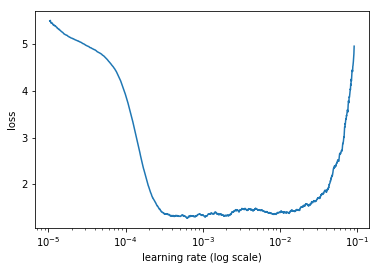

In [14]:
learner.lr_find()
learner.sched.plot()

In [15]:
lr = 5e-4
learner.fit(lr, 1)

num of layer groups of backbone:  2


  0%|          | 1/3495 [00:03<3:11:26,  3.29s/it, loss=5.56] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/3495 [00:03<2:23:35,  2.47s/it, loss=5.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 3/3495 [00:04<1:51:42,  1.92s/it, loss=5.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 4/3495 [00:04<1:26:00,  1.48s/it, loss=5.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 5/3495 [00:05<1:11:11,  1.22s/it, loss=5.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 6/3495 [00:06<58:21,  1.00s/it, loss=5.46]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 7/3495 [00:06<47:59,  1.21it/s, loss=5.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 8/3495 [00:07<43:08,  1.35it/s, loss=5.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 9/3495 [00:07<40:26,  1.44it/s, loss=5.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 10/3495 [00:08<41:35,  1.40it/s, loss=5.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 11/3495 [00:08<39:50,  1.46it/s, loss=5.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 12/3495 [00:09<39:53,  1.46it/s, loss=5.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 13/3495 [00:10<38:13,  1.52it/s, loss=5.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 14/3495 [00:10<34:45,  1.67it/s, loss=5.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 15/3495 [00:11<35:59,  1.61it/s, loss=5.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 16/3495 [00:12<36:00,  1.61it/s, loss=5.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 17/3495 [00:12<41:25,  1.40it/s, loss=5.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 18/3495 [00:13<41:16,  1.40it/s, loss=5.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 19/3495 [00:14<36:08,  1.60it/s, loss=5.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 20/3495 [00:14<35:58,  1.61it/s, loss=5.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 21/3495 [00:15<34:49,  1.66it/s, loss=5.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 22/3495 [00:15<34:00,  1.70it/s, loss=5.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 23/3495 [00:16<34:41,  1.67it/s, loss=5.1] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 24/3495 [00:16<30:50,  1.88it/s, loss=5.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 25/3495 [00:17<29:54,  1.93it/s, loss=5.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 26/3495 [00:17<28:58,  2.00it/s, loss=5.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 27/3495 [00:18<31:24,  1.84it/s, loss=5.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 28/3495 [00:19<35:41,  1.62it/s, loss=5.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 29/3495 [00:19<36:11,  1.60it/s, loss=5.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 30/3495 [00:20<35:10,  1.64it/s, loss=5]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 31/3495 [00:20<34:54,  1.65it/s, loss=4.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 32/3495 [00:21<33:59,  1.70it/s, loss=4.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 33/3495 [00:22<44:11,  1.31it/s, loss=4.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 34/3495 [00:23<40:15,  1.43it/s, loss=4.92]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 35/3495 [00:23<35:15,  1.64it/s, loss=4.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 36/3495 [00:24<40:32,  1.42it/s, loss=4.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 37/3495 [00:25<40:35,  1.42it/s, loss=4.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 38/3495 [00:26<46:53,  1.23it/s, loss=4.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 39/3495 [00:26<43:10,  1.33it/s, loss=4.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 40/3495 [00:27<42:48,  1.34it/s, loss=4.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 41/3495 [00:28<39:04,  1.47it/s, loss=4.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 42/3495 [00:28<36:04,  1.60it/s, loss=4.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 43/3495 [00:29<37:46,  1.52it/s, loss=4.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 44/3495 [00:30<37:56,  1.52it/s, loss=4.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 45/3495 [00:30<34:25,  1.67it/s, loss=4.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 46/3495 [00:31<35:20,  1.63it/s, loss=4.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 47/3495 [00:31<32:13,  1.78it/s, loss=4.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 48/3495 [00:31<28:17,  2.03it/s, loss=4.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 49/3495 [00:32<23:41,  2.42it/s, loss=4.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 50/3495 [00:32<20:58,  2.74it/s, loss=4.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 51/3495 [00:35<1:14:56,  1.31s/it, loss=4.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 52/3495 [00:36<1:03:03,  1.10s/it, loss=4.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 53/3495 [00:37<54:08,  1.06it/s, loss=4.56]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 54/3495 [00:37<47:36,  1.20it/s, loss=4.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 55/3495 [00:38<42:48,  1.34it/s, loss=4.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 56/3495 [00:39<44:40,  1.28it/s, loss=4.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 57/3495 [00:39<42:13,  1.36it/s, loss=4.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 58/3495 [00:40<37:56,  1.51it/s, loss=4.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 59/3495 [00:40<38:20,  1.49it/s, loss=4.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 60/3495 [00:41<34:03,  1.68it/s, loss=4.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 61/3495 [00:42<41:00,  1.40it/s, loss=4.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 62/3495 [00:42<37:45,  1.52it/s, loss=4.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 63/3495 [00:43<36:06,  1.58it/s, loss=4.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 64/3495 [00:44<34:53,  1.64it/s, loss=4.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 65/3495 [00:44<31:36,  1.81it/s, loss=4.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 66/3495 [00:45<36:45,  1.55it/s, loss=4.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 67/3495 [00:45<35:54,  1.59it/s, loss=4.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 68/3495 [00:46<39:37,  1.44it/s, loss=4.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 69/3495 [00:47<37:57,  1.50it/s, loss=4.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 70/3495 [00:48<38:26,  1.48it/s, loss=4.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 71/3495 [00:48<38:39,  1.48it/s, loss=4.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 72/3495 [00:49<34:45,  1.64it/s, loss=4.06]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 73/3495 [00:49<32:33,  1.75it/s, loss=4.03]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 74/3495 [00:50<29:41,  1.92it/s, loss=4]   

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 75/3495 [00:50<34:44,  1.64it/s, loss=3.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 76/3495 [00:51<35:55,  1.59it/s, loss=3.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 77/3495 [00:52<34:55,  1.63it/s, loss=3.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 78/3495 [00:52<37:29,  1.52it/s, loss=3.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 79/3495 [00:53<35:40,  1.60it/s, loss=3.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 80/3495 [00:53<33:32,  1.70it/s, loss=3.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 81/3495 [00:54<32:41,  1.74it/s, loss=3.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 82/3495 [00:54<31:41,  1.79it/s, loss=3.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 83/3495 [00:55<33:09,  1.72it/s, loss=3.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 84/3495 [00:56<33:01,  1.72it/s, loss=3.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 85/3495 [00:56<33:27,  1.70it/s, loss=3.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 86/3495 [00:57<35:13,  1.61it/s, loss=3.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 87/3495 [00:58<35:50,  1.58it/s, loss=3.6] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 88/3495 [00:58<35:30,  1.60it/s, loss=3.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 89/3495 [00:59<36:33,  1.55it/s, loss=3.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 90/3495 [01:00<35:14,  1.61it/s, loss=3.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 91/3495 [01:00<31:55,  1.78it/s, loss=3.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 92/3495 [01:00<29:14,  1.94it/s, loss=3.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 93/3495 [01:01<27:35,  2.05it/s, loss=3.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 94/3495 [01:01<28:14,  2.01it/s, loss=3.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 95/3495 [01:02<25:45,  2.20it/s, loss=3.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 96/3495 [01:02<24:26,  2.32it/s, loss=3.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 97/3495 [01:02<22:09,  2.56it/s, loss=3.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 98/3495 [01:03<20:50,  2.72it/s, loss=3.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 99/3495 [01:03<18:52,  3.00it/s, loss=3.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 100/3495 [01:03<17:11,  3.29it/s, loss=3.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 101/3495 [01:06<1:05:48,  1.16s/it, loss=3.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 102/3495 [01:07<53:18,  1.06it/s, loss=3.13]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 103/3495 [01:07<46:52,  1.21it/s, loss=3.1] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 104/3495 [01:08<38:42,  1.46it/s, loss=3.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 105/3495 [01:08<35:06,  1.61it/s, loss=3.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 106/3495 [01:09<35:33,  1.59it/s, loss=3.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 107/3495 [01:09<31:44,  1.78it/s, loss=2.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 108/3495 [01:10<30:37,  1.84it/s, loss=2.96]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 109/3495 [01:10<29:34,  1.91it/s, loss=2.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 110/3495 [01:11<33:50,  1.67it/s, loss=2.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 111/3495 [01:11<31:19,  1.80it/s, loss=2.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 112/3495 [01:12<30:51,  1.83it/s, loss=2.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 113/3495 [01:13<36:41,  1.54it/s, loss=2.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 114/3495 [01:13<36:56,  1.53it/s, loss=2.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 115/3495 [01:14<36:39,  1.54it/s, loss=2.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 116/3495 [01:15<32:52,  1.71it/s, loss=2.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 117/3495 [01:15<34:32,  1.63it/s, loss=2.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 118/3495 [01:16<38:23,  1.47it/s, loss=2.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 119/3495 [01:17<36:44,  1.53it/s, loss=2.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 120/3495 [01:17<38:59,  1.44it/s, loss=2.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 121/3495 [01:18<39:41,  1.42it/s, loss=2.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 122/3495 [01:19<36:10,  1.55it/s, loss=2.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 123/3495 [01:19<34:10,  1.64it/s, loss=2.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 124/3495 [01:20<35:25,  1.59it/s, loss=2.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 125/3495 [01:21<38:51,  1.45it/s, loss=2.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 126/3495 [01:21<38:48,  1.45it/s, loss=2.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 127/3495 [01:22<33:00,  1.70it/s, loss=2.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 128/3495 [01:22<31:56,  1.76it/s, loss=2.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 129/3495 [01:23<31:45,  1.77it/s, loss=2.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 130/3495 [01:23<30:25,  1.84it/s, loss=2.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 131/3495 [01:24<30:35,  1.83it/s, loss=2.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 132/3495 [01:24<29:50,  1.88it/s, loss=2.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 133/3495 [01:25<32:35,  1.72it/s, loss=2.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 134/3495 [01:26<34:24,  1.63it/s, loss=2.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 135/3495 [01:26<35:00,  1.60it/s, loss=2.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 136/3495 [01:27<33:11,  1.69it/s, loss=2.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 137/3495 [01:27<30:01,  1.86it/s, loss=2.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 138/3495 [01:28<28:04,  1.99it/s, loss=2.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 139/3495 [01:28<24:41,  2.27it/s, loss=2.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 140/3495 [01:28<23:36,  2.37it/s, loss=2.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 141/3495 [01:29<21:06,  2.65it/s, loss=2.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 142/3495 [01:29<19:26,  2.88it/s, loss=2.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 143/3495 [01:29<17:31,  3.19it/s, loss=2.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 144/3495 [01:29<16:39,  3.35it/s, loss=2.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 145/3495 [01:30<15:34,  3.58it/s, loss=2.12]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 146/3495 [01:30<15:13,  3.67it/s, loss=2.11]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 147/3495 [01:30<14:37,  3.81it/s, loss=2.09]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 148/3495 [01:30<14:33,  3.83it/s, loss=2.08]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 149/3495 [01:31<13:56,  4.00it/s, loss=2.07]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 150/3495 [01:31<14:21,  3.88it/s, loss=2.05]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 151/3495 [01:33<48:01,  1.16it/s, loss=2.04]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 152/3495 [01:34<46:09,  1.21it/s, loss=2.02]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 153/3495 [01:35<41:31,  1.34it/s, loss=2.01]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 154/3495 [01:35<37:07,  1.50it/s, loss=1.99]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 155/3495 [01:36<36:27,  1.53it/s, loss=1.98]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 156/3495 [01:36<32:35,  1.71it/s, loss=1.97]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 157/3495 [01:37<34:25,  1.62it/s, loss=1.95]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 158/3495 [01:37<32:31,  1.71it/s, loss=1.94]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 159/3495 [01:38<30:49,  1.80it/s, loss=1.93]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 160/3495 [01:38<29:12,  1.90it/s, loss=1.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 161/3495 [01:39<27:22,  2.03it/s, loss=1.91]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 162/3495 [01:39<26:09,  2.12it/s, loss=1.9] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 163/3495 [01:39<24:47,  2.24it/s, loss=1.89]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 164/3495 [01:40<26:55,  2.06it/s, loss=1.88]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 165/3495 [01:40<25:45,  2.15it/s, loss=1.87]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 166/3495 [01:41<31:50,  1.74it/s, loss=1.86]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 167/3495 [01:42<30:04,  1.84it/s, loss=1.85]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 168/3495 [01:42<28:01,  1.98it/s, loss=1.83]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 169/3495 [01:43<26:40,  2.08it/s, loss=1.82]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 170/3495 [01:43<26:17,  2.11it/s, loss=1.8] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 171/3495 [01:44<27:18,  2.03it/s, loss=1.79]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 172/3495 [01:44<28:23,  1.95it/s, loss=1.78]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 173/3495 [01:45<28:07,  1.97it/s, loss=1.77]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 174/3495 [01:45<28:00,  1.98it/s, loss=1.76]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 175/3495 [01:46<31:28,  1.76it/s, loss=1.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 176/3495 [01:46<32:08,  1.72it/s, loss=1.75]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 177/3495 [01:47<30:59,  1.78it/s, loss=1.74]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 178/3495 [01:48<33:37,  1.64it/s, loss=1.73]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 179/3495 [01:48<36:48,  1.50it/s, loss=1.72]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 180/3495 [01:49<42:12,  1.31it/s, loss=1.71]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 181/3495 [01:50<39:56,  1.38it/s, loss=1.7] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 182/3495 [01:51<41:34,  1.33it/s, loss=1.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 183/3495 [01:52<43:07,  1.28it/s, loss=1.69]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 184/3495 [01:53<42:07,  1.31it/s, loss=1.68]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 185/3495 [01:53<38:14,  1.44it/s, loss=1.67]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 186/3495 [01:54<35:48,  1.54it/s, loss=1.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 187/3495 [01:54<31:59,  1.72it/s, loss=1.66]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 188/3495 [01:54<28:07,  1.96it/s, loss=1.65]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 189/3495 [01:55<27:12,  2.03it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 190/3495 [01:55<28:02,  1.96it/s, loss=1.64]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 191/3495 [01:56<28:58,  1.90it/s, loss=1.63]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 192/3495 [01:57<31:55,  1.72it/s, loss=1.62]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 193/3495 [01:57<29:32,  1.86it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 194/3495 [01:57<27:08,  2.03it/s, loss=1.61]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 195/3495 [01:58<25:13,  2.18it/s, loss=1.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 196/3495 [01:58<22:22,  2.46it/s, loss=1.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 197/3495 [01:58<19:52,  2.77it/s, loss=1.59]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 198/3495 [01:59<17:57,  3.06it/s, loss=1.58]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 199/3495 [01:59<17:05,  3.21it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 200/3495 [01:59<15:53,  3.46it/s, loss=1.57]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 201/3495 [02:02<1:06:22,  1.21s/it, loss=1.56]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 202/3495 [02:03<56:12,  1.02s/it, loss=1.55]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 203/3495 [02:04<49:53,  1.10it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 204/3495 [02:04<47:25,  1.16it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 205/3495 [02:05<42:28,  1.29it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 206/3495 [02:06<42:08,  1.30it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 207/3495 [02:07<41:24,  1.32it/s, loss=1.55]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 208/3495 [02:07<35:10,  1.56it/s, loss=1.54]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 209/3495 [02:07<33:05,  1.66it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 210/3495 [02:08<33:56,  1.61it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 211/3495 [02:09<35:32,  1.54it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 212/3495 [02:09<31:48,  1.72it/s, loss=1.53]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 213/3495 [02:10<31:33,  1.73it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 214/3495 [02:10<32:35,  1.68it/s, loss=1.52]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 215/3495 [02:11<36:01,  1.52it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 216/3495 [02:12<37:22,  1.46it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 217/3495 [02:13<35:51,  1.52it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 218/3495 [02:13<35:04,  1.56it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 219/3495 [02:14<36:09,  1.51it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 220/3495 [02:14<31:14,  1.75it/s, loss=1.51]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 221/3495 [02:15<34:57,  1.56it/s, loss=1.5] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 222/3495 [02:16<34:57,  1.56it/s, loss=1.5]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 223/3495 [02:16<31:39,  1.72it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 224/3495 [02:17<29:37,  1.84it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 225/3495 [02:17<33:38,  1.62it/s, loss=1.49]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 226/3495 [02:18<32:45,  1.66it/s, loss=1.48]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 227/3495 [02:19<33:45,  1.61it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 228/3495 [02:19<33:57,  1.60it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 229/3495 [02:20<32:13,  1.69it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 230/3495 [02:20<31:34,  1.72it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 231/3495 [02:21<27:13,  2.00it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 232/3495 [02:21<27:16,  1.99it/s, loss=1.47]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 233/3495 [02:22<27:11,  2.00it/s, loss=1.46]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 234/3495 [02:22<29:39,  1.83it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 235/3495 [02:23<30:44,  1.77it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 236/3495 [02:24<31:53,  1.70it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 237/3495 [02:25<46:14,  1.17it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 238/3495 [02:26<43:01,  1.26it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 239/3495 [02:26<42:41,  1.27it/s, loss=1.45]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 240/3495 [02:27<36:16,  1.50it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 241/3495 [02:28<38:14,  1.42it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 242/3495 [02:28<39:53,  1.36it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 243/3495 [02:29<37:04,  1.46it/s, loss=1.44]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 244/3495 [02:30<36:01,  1.50it/s, loss=1.43]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 245/3495 [02:30<32:12,  1.68it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 246/3495 [02:30<29:51,  1.81it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 247/3495 [02:31<28:31,  1.90it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 248/3495 [02:31<23:58,  2.26it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 249/3495 [02:31<21:27,  2.52it/s, loss=1.42]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 250/3495 [02:32<19:22,  2.79it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 251/3495 [02:35<1:05:47,  1.22s/it, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 252/3495 [02:35<53:17,  1.01it/s, loss=1.42]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 253/3495 [02:36<45:24,  1.19it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 254/3495 [02:37<41:25,  1.30it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 255/3495 [02:37<37:20,  1.45it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 256/3495 [02:38<40:23,  1.34it/s, loss=1.41]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 257/3495 [02:38<37:08,  1.45it/s, loss=1.4] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 258/3495 [02:39<35:13,  1.53it/s, loss=1.4]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 259/3495 [02:40<35:00,  1.54it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 260/3495 [02:40<31:50,  1.69it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 261/3495 [02:41<35:20,  1.52it/s, loss=1.39]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 262/3495 [02:41<32:20,  1.67it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 263/3495 [02:42<32:15,  1.67it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 264/3495 [02:42<30:19,  1.78it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 265/3495 [02:43<29:05,  1.85it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 266/3495 [02:44<41:15,  1.30it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 267/3495 [02:45<38:57,  1.38it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 268/3495 [02:45<36:45,  1.46it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 269/3495 [02:46<40:43,  1.32it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 270/3495 [02:47<38:50,  1.38it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 271/3495 [02:48<37:50,  1.42it/s, loss=1.38]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 272/3495 [02:48<39:21,  1.36it/s, loss=1.37]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 273/3495 [02:49<38:27,  1.40it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 274/3495 [02:50<40:06,  1.34it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 275/3495 [02:51<40:26,  1.33it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 276/3495 [02:52<41:06,  1.31it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 277/3495 [02:52<37:02,  1.45it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 279/3495 [02:53<35:58,  1.49it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 280/3495 [02:54<36:17,  1.48it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 281/3495 [02:55<35:58,  1.49it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 282/3495 [02:55<35:24,  1.51it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 283/3495 [02:56<36:25,  1.47it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 284/3495 [02:57<39:06,  1.37it/s, loss=1.36]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 285/3495 [02:58<36:58,  1.45it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 286/3495 [02:58<36:38,  1.46it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 287/3495 [02:59<37:55,  1.41it/s, loss=1.35]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 288/3495 [03:00<36:14,  1.48it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 289/3495 [03:00<32:08,  1.66it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 290/3495 [03:01<31:05,  1.72it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 291/3495 [03:01<31:58,  1.67it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 292/3495 [03:02<34:11,  1.56it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 293/3495 [03:03<33:03,  1.61it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 294/3495 [03:03<33:24,  1.60it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 295/3495 [03:04<31:57,  1.67it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 296/3495 [03:04<28:09,  1.89it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 297/3495 [03:04<24:24,  2.18it/s, loss=1.34]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 298/3495 [03:05<20:58,  2.54it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 299/3495 [03:05<18:59,  2.80it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 300/3495 [03:05<17:03,  3.12it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 301/3495 [03:08<1:04:14,  1.21s/it, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 302/3495 [03:09<55:37,  1.05s/it, loss=1.32]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 303/3495 [03:10<50:48,  1.05it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 304/3495 [03:10<45:44,  1.16it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 305/3495 [03:11<44:26,  1.20it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 306/3495 [03:12<39:53,  1.33it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 307/3495 [03:12<38:53,  1.37it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 308/3495 [03:13<40:14,  1.32it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 309/3495 [03:14<37:19,  1.42it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 310/3495 [03:15<38:14,  1.39it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 311/3495 [03:15<35:30,  1.49it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 312/3495 [03:16<32:10,  1.65it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 313/3495 [03:16<32:36,  1.63it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 314/3495 [03:17<32:21,  1.64it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 315/3495 [03:18<34:13,  1.55it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 316/3495 [03:18<35:54,  1.48it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 317/3495 [03:19<34:49,  1.52it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 318/3495 [03:20<35:44,  1.48it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 319/3495 [03:20<35:43,  1.48it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 320/3495 [03:21<39:58,  1.32it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 321/3495 [03:22<38:01,  1.39it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 322/3495 [03:23<40:13,  1.31it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 323/3495 [03:23<36:20,  1.45it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 324/3495 [03:24<38:07,  1.39it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 325/3495 [03:24<32:06,  1.65it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 326/3495 [03:25<35:57,  1.47it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 327/3495 [03:26<33:28,  1.58it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 328/3495 [03:26<31:58,  1.65it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 329/3495 [03:27<29:27,  1.79it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 330/3495 [03:27<31:42,  1.66it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 331/3495 [03:28<33:11,  1.59it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 332/3495 [03:29<35:22,  1.49it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 333/3495 [03:30<34:34,  1.52it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 334/3495 [03:30<30:25,  1.73it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 335/3495 [03:31<29:54,  1.76it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 336/3495 [03:31<28:21,  1.86it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 337/3495 [03:32<30:50,  1.71it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 338/3495 [03:32<30:00,  1.75it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 339/3495 [03:33<28:45,  1.83it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 340/3495 [03:33<28:00,  1.88it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 341/3495 [03:34<27:23,  1.92it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 342/3495 [03:34<25:57,  2.02it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 343/3495 [03:35<28:37,  1.83it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 344/3495 [03:36<31:44,  1.65it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 345/3495 [03:36<30:25,  1.73it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 346/3495 [03:37<30:20,  1.73it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 347/3495 [03:37<30:31,  1.72it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 348/3495 [03:38<26:17,  1.99it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 349/3495 [03:38<21:49,  2.40it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 350/3495 [03:38<19:48,  2.65it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 351/3495 [03:41<1:02:05,  1.18s/it, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 352/3495 [03:42<54:25,  1.04s/it, loss=1.32]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 353/3495 [03:42<48:10,  1.09it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 354/3495 [03:43<42:37,  1.23it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 355/3495 [03:43<36:47,  1.42it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 356/3495 [03:44<37:47,  1.38it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 357/3495 [03:45<36:44,  1.42it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 358/3495 [03:45<33:23,  1.57it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 359/3495 [03:46<31:20,  1.67it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 360/3495 [03:46<29:02,  1.80it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 361/3495 [03:47<29:53,  1.75it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 362/3495 [03:48<34:41,  1.51it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 363/3495 [03:48<33:35,  1.55it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 364/3495 [03:49<31:29,  1.66it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 365/3495 [03:49<27:56,  1.87it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 366/3495 [03:50<27:58,  1.86it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 367/3495 [03:51<32:11,  1.62it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 368/3495 [03:51<33:02,  1.58it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 369/3495 [03:52<29:38,  1.76it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 370/3495 [03:52<27:44,  1.88it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 371/3495 [03:53<28:02,  1.86it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 372/3495 [03:53<29:16,  1.78it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 373/3495 [03:54<28:58,  1.80it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 374/3495 [03:55<29:59,  1.73it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 375/3495 [03:55<29:30,  1.76it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 376/3495 [03:56<28:13,  1.84it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 377/3495 [03:56<29:14,  1.78it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 378/3495 [03:57<28:09,  1.85it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 379/3495 [03:57<28:02,  1.85it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 380/3495 [03:58<25:43,  2.02it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 381/3495 [03:58<25:14,  2.06it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 382/3495 [03:59<26:05,  1.99it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 383/3495 [03:59<27:02,  1.92it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 384/3495 [04:00<26:08,  1.98it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 385/3495 [04:00<26:01,  1.99it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 386/3495 [04:01<25:03,  2.07it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 387/3495 [04:01<29:29,  1.76it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 388/3495 [04:02<31:00,  1.67it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 389/3495 [04:03<30:30,  1.70it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 390/3495 [04:03<30:53,  1.68it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 391/3495 [04:04<29:04,  1.78it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 392/3495 [04:04<27:26,  1.88it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 393/3495 [04:05<29:54,  1.73it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 394/3495 [04:06<32:47,  1.58it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 395/3495 [04:06<31:39,  1.63it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 396/3495 [04:07<28:04,  1.84it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 397/3495 [04:07<25:55,  1.99it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 398/3495 [04:07<22:00,  2.35it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 399/3495 [04:07<19:36,  2.63it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 400/3495 [04:08<17:20,  2.98it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 401/3495 [04:11<57:52,  1.12s/it, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 402/3495 [04:11<48:17,  1.07it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 403/3495 [04:12<42:29,  1.21it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 404/3495 [04:12<39:46,  1.30it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 405/3495 [04:13<36:49,  1.40it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 406/3495 [04:13<33:29,  1.54it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 407/3495 [04:14<29:33,  1.74it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 408/3495 [04:14<30:10,  1.71it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 409/3495 [04:15<30:50,  1.67it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 410/3495 [04:15<27:35,  1.86it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 411/3495 [04:16<28:23,  1.81it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 412/3495 [04:17<28:49,  1.78it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 413/3495 [04:17<29:25,  1.75it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 414/3495 [04:18<27:21,  1.88it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 415/3495 [04:18<25:10,  2.04it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 416/3495 [04:19<26:54,  1.91it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 417/3495 [04:19<27:26,  1.87it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 418/3495 [04:20<29:17,  1.75it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 419/3495 [04:21<30:16,  1.69it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 420/3495 [04:21<29:24,  1.74it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 421/3495 [04:22<31:31,  1.63it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 422/3495 [04:22<31:41,  1.62it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 423/3495 [04:23<30:43,  1.67it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 424/3495 [04:23<29:01,  1.76it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 425/3495 [04:24<29:29,  1.74it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 426/3495 [04:25<29:37,  1.73it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 427/3495 [04:25<26:58,  1.90it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 428/3495 [04:26<28:05,  1.82it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 429/3495 [04:26<28:42,  1.78it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 430/3495 [04:27<29:16,  1.74it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 431/3495 [04:27<29:54,  1.71it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 432/3495 [04:28<31:15,  1.63it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 433/3495 [04:29<31:03,  1.64it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 434/3495 [04:29<31:28,  1.62it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 435/3495 [04:30<32:33,  1.57it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 436/3495 [04:31<33:17,  1.53it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 437/3495 [04:31<31:08,  1.64it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 438/3495 [04:32<31:02,  1.64it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 439/3495 [04:32<29:32,  1.72it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 440/3495 [04:33<28:31,  1.78it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 441/3495 [04:33<27:09,  1.87it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 442/3495 [04:34<25:20,  2.01it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 443/3495 [04:34<28:27,  1.79it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 444/3495 [04:35<28:35,  1.78it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 445/3495 [04:36<30:36,  1.66it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 446/3495 [04:36<28:21,  1.79it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 447/3495 [04:37<25:52,  1.96it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 448/3495 [04:37<23:44,  2.14it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 449/3495 [04:37<20:57,  2.42it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 450/3495 [04:37<18:31,  2.74it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 451/3495 [04:41<59:02,  1.16s/it, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 452/3495 [04:41<48:51,  1.04it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 453/3495 [04:42<41:52,  1.21it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 454/3495 [04:42<40:55,  1.24it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 455/3495 [04:43<35:24,  1.43it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 456/3495 [04:43<35:14,  1.44it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 457/3495 [04:44<35:32,  1.42it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 458/3495 [04:45<36:04,  1.40it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 459/3495 [04:45<32:16,  1.57it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 460/3495 [04:46<34:02,  1.49it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 461/3495 [04:47<33:08,  1.53it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 462/3495 [04:47<32:04,  1.58it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 463/3495 [04:48<32:40,  1.55it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 464/3495 [04:49<35:54,  1.41it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 465/3495 [04:49<32:13,  1.57it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 466/3495 [04:50<32:57,  1.53it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 467/3495 [04:51<33:21,  1.51it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 468/3495 [04:51<30:57,  1.63it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 469/3495 [04:52<27:22,  1.84it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 470/3495 [04:52<28:00,  1.80it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 471/3495 [04:53<31:14,  1.61it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 472/3495 [04:53<27:43,  1.82it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 473/3495 [04:54<28:35,  1.76it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 474/3495 [04:54<26:29,  1.90it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 475/3495 [04:55<27:57,  1.80it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 476/3495 [04:56<28:22,  1.77it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 477/3495 [04:56<28:06,  1.79it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 478/3495 [04:57<27:18,  1.84it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 479/3495 [04:57<28:48,  1.74it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 480/3495 [04:58<28:28,  1.76it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 481/3495 [04:58<30:21,  1.65it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 482/3495 [04:59<28:24,  1.77it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 483/3495 [04:59<27:34,  1.82it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 484/3495 [05:00<27:46,  1.81it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 485/3495 [05:00<25:09,  1.99it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 486/3495 [05:01<30:04,  1.67it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 487/3495 [05:02<29:36,  1.69it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 488/3495 [05:02<27:54,  1.80it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 489/3495 [05:03<27:47,  1.80it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 490/3495 [05:03<28:02,  1.79it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 491/3495 [05:04<27:30,  1.82it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 492/3495 [05:04<24:03,  2.08it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 493/3495 [05:05<23:42,  2.11it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 494/3495 [05:06<35:47,  1.40it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 495/3495 [05:06<30:59,  1.61it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 496/3495 [05:07<28:42,  1.74it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 497/3495 [05:07<25:10,  1.98it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 498/3495 [05:08<24:01,  2.08it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 499/3495 [05:08<20:18,  2.46it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 501/3495 [05:11<58:33,  1.17s/it, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 502/3495 [05:12<46:54,  1.06it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 503/3495 [05:12<40:58,  1.22it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 504/3495 [05:13<36:17,  1.37it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 505/3495 [05:13<30:32,  1.63it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 506/3495 [05:15<45:40,  1.09it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 507/3495 [05:15<39:48,  1.25it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 508/3495 [05:16<35:25,  1.41it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 509/3495 [05:16<31:17,  1.59it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 510/3495 [05:17<29:44,  1.67it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 511/3495 [05:17<32:27,  1.53it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 512/3495 [05:18<30:59,  1.60it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 513/3495 [05:18<30:07,  1.65it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 514/3495 [05:19<28:56,  1.72it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 515/3495 [05:20<31:43,  1.57it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 516/3495 [05:20<31:52,  1.56it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 517/3495 [05:21<31:37,  1.57it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 518/3495 [05:22<30:04,  1.65it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 519/3495 [05:22<28:14,  1.76it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 520/3495 [05:23<30:15,  1.64it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 521/3495 [05:24<33:58,  1.46it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 522/3495 [05:24<32:04,  1.54it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 523/3495 [05:25<30:33,  1.62it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 524/3495 [05:25<30:07,  1.64it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 525/3495 [05:26<27:02,  1.83it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 526/3495 [05:26<30:26,  1.63it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 527/3495 [05:27<29:30,  1.68it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 528/3495 [05:27<27:21,  1.81it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 529/3495 [05:28<25:02,  1.97it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 530/3495 [05:29<27:42,  1.78it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 531/3495 [05:29<32:33,  1.52it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 532/3495 [05:30<34:13,  1.44it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 533/3495 [05:31<29:55,  1.65it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 534/3495 [05:31<27:18,  1.81it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 535/3495 [05:31<25:27,  1.94it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 536/3495 [05:32<31:54,  1.55it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 537/3495 [05:33<30:37,  1.61it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 538/3495 [05:34<29:47,  1.65it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 539/3495 [05:34<27:04,  1.82it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 540/3495 [05:34<26:13,  1.88it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 541/3495 [05:35<23:53,  2.06it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 542/3495 [05:36<32:52,  1.50it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 543/3495 [05:36<30:32,  1.61it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 544/3495 [05:37<27:08,  1.81it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 545/3495 [05:37<27:25,  1.79it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 546/3495 [05:38<27:08,  1.81it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 547/3495 [05:38<26:40,  1.84it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 548/3495 [05:39<23:49,  2.06it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 549/3495 [05:39<20:24,  2.41it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 550/3495 [05:39<18:04,  2.72it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 551/3495 [05:43<1:08:47,  1.40s/it, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 552/3495 [05:44<57:41,  1.18s/it, loss=1.29]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 553/3495 [05:44<48:34,  1.01it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 554/3495 [05:45<45:18,  1.08it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 555/3495 [05:46<44:55,  1.09it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 556/3495 [05:47<38:46,  1.26it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 557/3495 [05:47<32:50,  1.49it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 558/3495 [05:48<33:21,  1.47it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 559/3495 [05:48<32:30,  1.51it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 560/3495 [05:49<31:11,  1.57it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 561/3495 [05:49<30:44,  1.59it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 562/3495 [05:50<30:10,  1.62it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 563/3495 [05:51<27:56,  1.75it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 564/3495 [05:51<27:41,  1.76it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 565/3495 [05:52<27:27,  1.78it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 566/3495 [05:52<25:18,  1.93it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 567/3495 [05:52<23:46,  2.05it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 568/3495 [05:53<28:08,  1.73it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 569/3495 [05:54<29:55,  1.63it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 570/3495 [05:54<28:57,  1.68it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 571/3495 [05:55<26:42,  1.82it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 572/3495 [05:56<30:45,  1.58it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 573/3495 [05:56<31:54,  1.53it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 574/3495 [05:57<31:46,  1.53it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 575/3495 [05:58<29:50,  1.63it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 576/3495 [05:58<26:22,  1.84it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 577/3495 [05:59<28:24,  1.71it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 578/3495 [05:59<28:08,  1.73it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 579/3495 [06:00<29:08,  1.67it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 580/3495 [06:00<26:48,  1.81it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 581/3495 [06:01<29:44,  1.63it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 582/3495 [06:02<30:33,  1.59it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 583/3495 [06:03<32:15,  1.50it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 584/3495 [06:03<30:57,  1.57it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 585/3495 [06:04<32:34,  1.49it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 586/3495 [06:04<32:22,  1.50it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 587/3495 [06:05<32:01,  1.51it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 588/3495 [06:06<30:23,  1.59it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 589/3495 [06:06<29:25,  1.65it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 590/3495 [06:07<30:11,  1.60it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 591/3495 [06:08<29:45,  1.63it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 592/3495 [06:08<30:03,  1.61it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 593/3495 [06:09<26:59,  1.79it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 594/3495 [06:09<22:44,  2.13it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 595/3495 [06:09<20:02,  2.41it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 596/3495 [06:09<17:31,  2.76it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 597/3495 [06:10<15:40,  3.08it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 598/3495 [06:10<14:34,  3.31it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 599/3495 [06:10<13:19,  3.62it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 600/3495 [06:10<13:07,  3.67it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 601/3495 [06:12<39:06,  1.23it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 602/3495 [06:13<34:26,  1.40it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 603/3495 [06:13<30:32,  1.58it/s, loss=1.33]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 604/3495 [06:14<27:48,  1.73it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 605/3495 [06:14<24:46,  1.94it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 606/3495 [06:15<23:04,  2.09it/s, loss=1.32]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 607/3495 [06:15<23:15,  2.07it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 608/3495 [06:16<24:18,  1.98it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 609/3495 [06:16<23:22,  2.06it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 610/3495 [06:16<22:16,  2.16it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 611/3495 [06:17<27:47,  1.73it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 612/3495 [06:18<25:12,  1.91it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 613/3495 [06:18<25:25,  1.89it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 614/3495 [06:19<22:59,  2.09it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 615/3495 [06:19<23:49,  2.02it/s, loss=1.31]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 616/3495 [06:20<26:51,  1.79it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 617/3495 [06:20<26:45,  1.79it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 618/3495 [06:21<24:52,  1.93it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 619/3495 [06:21<23:13,  2.06it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 620/3495 [06:22<23:56,  2.00it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 621/3495 [06:22<24:16,  1.97it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 622/3495 [06:23<22:45,  2.10it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 623/3495 [06:23<24:54,  1.92it/s, loss=1.3] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 624/3495 [06:24<28:08,  1.70it/s, loss=1.3]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 625/3495 [06:25<27:31,  1.74it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 626/3495 [06:25<27:07,  1.76it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 627/3495 [06:26<27:54,  1.71it/s, loss=1.29]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 628/3495 [06:26<24:07,  1.98it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 629/3495 [06:26<22:52,  2.09it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 630/3495 [06:27<23:37,  2.02it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 631/3495 [06:28<23:32,  2.03it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 632/3495 [06:28<23:51,  2.00it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 633/3495 [06:29<25:14,  1.89it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 634/3495 [06:29<24:54,  1.91it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 635/3495 [06:30<24:53,  1.91it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 636/3495 [06:30<24:12,  1.97it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 637/3495 [06:31<23:49,  2.00it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 638/3495 [06:31<23:19,  2.04it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 639/3495 [06:31<22:23,  2.13it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 640/3495 [06:32<21:38,  2.20it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 641/3495 [06:33<24:06,  1.97it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 642/3495 [06:33<22:21,  2.13it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 643/3495 [06:33<20:41,  2.30it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 644/3495 [06:34<19:25,  2.45it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 645/3495 [06:34<18:24,  2.58it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 646/3495 [06:34<16:16,  2.92it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 647/3495 [06:34<15:08,  3.13it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 648/3495 [06:35<13:59,  3.39it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 649/3495 [06:35<13:30,  3.51it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 650/3495 [06:35<13:12,  3.59it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 651/3495 [06:38<42:17,  1.12it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 652/3495 [06:38<34:29,  1.37it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 653/3495 [06:38<30:30,  1.55it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 654/3495 [06:39<29:23,  1.61it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 655/3495 [06:39<28:05,  1.69it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 656/3495 [06:40<28:02,  1.69it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 657/3495 [06:40<26:10,  1.81it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 658/3495 [06:41<24:22,  1.94it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 659/3495 [06:42<25:43,  1.84it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 660/3495 [06:42<29:00,  1.63it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 661/3495 [06:43<28:39,  1.65it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 662/3495 [06:43<26:09,  1.81it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 663/3495 [06:44<26:47,  1.76it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 664/3495 [06:44<24:28,  1.93it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 665/3495 [06:45<26:08,  1.80it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 666/3495 [06:45<24:06,  1.96it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 667/3495 [06:46<25:23,  1.86it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 668/3495 [06:47<25:33,  1.84it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 669/3495 [06:47<22:40,  2.08it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 670/3495 [06:47<24:39,  1.91it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 671/3495 [06:48<23:36,  1.99it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 672/3495 [06:49<26:48,  1.75it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 673/3495 [06:49<24:46,  1.90it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 674/3495 [06:50<24:40,  1.91it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 675/3495 [06:50<21:41,  2.17it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 676/3495 [06:50<20:53,  2.25it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 677/3495 [06:51<21:14,  2.21it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 678/3495 [06:51<20:53,  2.25it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 679/3495 [06:52<22:30,  2.09it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 680/3495 [06:52<22:01,  2.13it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 681/3495 [06:53<23:06,  2.03it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 682/3495 [06:53<22:22,  2.09it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 683/3495 [06:54<22:22,  2.10it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 684/3495 [06:54<24:07,  1.94it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 685/3495 [06:55<24:57,  1.88it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 686/3495 [06:55<25:30,  1.84it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 687/3495 [06:56<28:35,  1.64it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 688/3495 [06:57<27:10,  1.72it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 689/3495 [06:57<26:17,  1.78it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 690/3495 [06:58<22:55,  2.04it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 691/3495 [06:58<22:46,  2.05it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 692/3495 [06:59<25:07,  1.86it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 693/3495 [06:59<20:58,  2.23it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 694/3495 [06:59<18:25,  2.53it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 695/3495 [06:59<16:25,  2.84it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 696/3495 [07:00<14:49,  3.15it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 697/3495 [07:00<13:48,  3.38it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 698/3495 [07:00<13:21,  3.49it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 699/3495 [07:00<12:46,  3.65it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 700/3495 [07:01<12:25,  3.75it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 701/3495 [07:04<57:52,  1.24s/it, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 702/3495 [07:05<47:09,  1.01s/it, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 703/3495 [07:05<42:08,  1.10it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 704/3495 [07:06<37:05,  1.25it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 705/3495 [07:07<36:25,  1.28it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 706/3495 [07:07<33:00,  1.41it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 707/3495 [07:08<34:25,  1.35it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 708/3495 [07:09<32:28,  1.43it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 709/3495 [07:09<30:18,  1.53it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 710/3495 [07:10<30:15,  1.53it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 711/3495 [07:10<27:16,  1.70it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 712/3495 [07:11<25:00,  1.86it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 713/3495 [07:11<24:59,  1.86it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 714/3495 [07:12<25:14,  1.84it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 715/3495 [07:12<24:50,  1.86it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 716/3495 [07:13<26:52,  1.72it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 717/3495 [07:14<31:50,  1.45it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 718/3495 [07:15<33:03,  1.40it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 719/3495 [07:15<31:01,  1.49it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 720/3495 [07:16<30:47,  1.50it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 721/3495 [07:17<31:08,  1.48it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 722/3495 [07:17<29:40,  1.56it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 723/3495 [07:18<28:59,  1.59it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 724/3495 [07:19<32:18,  1.43it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 725/3495 [07:19<32:08,  1.44it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 726/3495 [07:20<32:59,  1.40it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 727/3495 [07:21<37:07,  1.24it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 728/3495 [07:22<38:47,  1.19it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 729/3495 [07:23<38:24,  1.20it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 730/3495 [07:23<33:28,  1.38it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 731/3495 [07:24<28:59,  1.59it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 732/3495 [07:24<29:55,  1.54it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 733/3495 [07:25<28:59,  1.59it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 734/3495 [07:26<27:24,  1.68it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 735/3495 [07:26<26:33,  1.73it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 736/3495 [07:27<28:54,  1.59it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 737/3495 [07:27<27:50,  1.65it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 738/3495 [07:28<32:38,  1.41it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 739/3495 [07:29<35:33,  1.29it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 740/3495 [07:30<33:29,  1.37it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 741/3495 [07:31<34:01,  1.35it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 742/3495 [07:31<28:00,  1.64it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 743/3495 [07:31<24:12,  1.90it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 744/3495 [07:32<21:28,  2.13it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 745/3495 [07:32<18:24,  2.49it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 746/3495 [07:32<16:17,  2.81it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 747/3495 [07:32<14:39,  3.13it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 748/3495 [07:33<13:40,  3.35it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 749/3495 [07:33<12:46,  3.58it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 750/3495 [07:33<12:33,  3.64it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 751/3495 [07:36<46:31,  1.02s/it, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 752/3495 [07:37<49:13,  1.08s/it, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 753/3495 [07:37<39:01,  1.17it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 754/3495 [07:38<36:51,  1.24it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 755/3495 [07:39<32:25,  1.41it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 756/3495 [07:39<30:37,  1.49it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 757/3495 [07:40<30:57,  1.47it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 758/3495 [07:40<30:23,  1.50it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 759/3495 [07:41<31:36,  1.44it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 760/3495 [07:42<30:49,  1.48it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 761/3495 [07:43<31:42,  1.44it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 762/3495 [07:43<30:45,  1.48it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 763/3495 [07:44<31:44,  1.43it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 764/3495 [07:44<27:48,  1.64it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 765/3495 [07:45<28:40,  1.59it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 766/3495 [07:46<27:59,  1.62it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 767/3495 [07:46<29:06,  1.56it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 768/3495 [07:47<29:53,  1.52it/s, loss=1.28]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 769/3495 [07:47<26:27,  1.72it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 770/3495 [07:48<24:45,  1.83it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 771/3495 [07:49<25:50,  1.76it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 772/3495 [07:49<24:27,  1.86it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 773/3495 [07:49<22:03,  2.06it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 774/3495 [07:50<22:51,  1.98it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 775/3495 [07:51<25:38,  1.77it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 776/3495 [07:51<25:50,  1.75it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 777/3495 [07:52<25:02,  1.81it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 778/3495 [07:52<23:08,  1.96it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 779/3495 [07:53<22:38,  2.00it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 780/3495 [07:53<21:39,  2.09it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 781/3495 [07:54<22:57,  1.97it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 782/3495 [07:54<25:07,  1.80it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 783/3495 [07:55<24:48,  1.82it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 784/3495 [07:55<26:31,  1.70it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 785/3495 [07:56<26:21,  1.71it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 786/3495 [07:57<26:55,  1.68it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 787/3495 [07:57<26:53,  1.68it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 788/3495 [07:58<27:11,  1.66it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 789/3495 [07:58<26:59,  1.67it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 790/3495 [07:59<25:50,  1.74it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 791/3495 [08:00<25:08,  1.79it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 792/3495 [08:00<26:39,  1.69it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 793/3495 [08:01<26:06,  1.72it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 794/3495 [08:01<23:02,  1.95it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 795/3495 [08:02<25:41,  1.75it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 796/3495 [08:02<24:11,  1.86it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 797/3495 [08:03<22:51,  1.97it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 798/3495 [08:03<19:20,  2.32it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 799/3495 [08:03<17:03,  2.63it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 800/3495 [08:03<14:53,  3.02it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 801/3495 [08:07<52:06,  1.16s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 802/3495 [08:07<46:41,  1.04s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 803/3495 [08:08<39:26,  1.14it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 804/3495 [08:08<32:59,  1.36it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 805/3495 [08:09<29:26,  1.52it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 806/3495 [08:09<29:32,  1.52it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 807/3495 [08:10<27:00,  1.66it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 808/3495 [08:10<25:12,  1.78it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 809/3495 [08:11<23:14,  1.93it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 810/3495 [08:11<22:38,  1.98it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 811/3495 [08:12<27:18,  1.64it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 812/3495 [08:13<27:18,  1.64it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 813/3495 [08:13<28:09,  1.59it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 814/3495 [08:14<28:24,  1.57it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 815/3495 [08:14<25:12,  1.77it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 816/3495 [08:15<26:06,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 817/3495 [08:15<25:12,  1.77it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 818/3495 [08:16<26:14,  1.70it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 819/3495 [08:17<25:30,  1.75it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 820/3495 [08:17<25:56,  1.72it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 821/3495 [08:18<30:59,  1.44it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 822/3495 [08:19<29:32,  1.51it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 823/3495 [08:19<28:41,  1.55it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 824/3495 [08:20<30:52,  1.44it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 825/3495 [08:21<28:32,  1.56it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 826/3495 [08:21<29:20,  1.52it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 827/3495 [08:22<28:50,  1.54it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 828/3495 [08:23<26:37,  1.67it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 829/3495 [08:23<28:20,  1.57it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 830/3495 [08:24<29:30,  1.51it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 831/3495 [08:25<29:22,  1.51it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 832/3495 [08:25<27:02,  1.64it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 833/3495 [08:26<25:31,  1.74it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 834/3495 [08:26<27:37,  1.61it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 835/3495 [08:27<26:39,  1.66it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 836/3495 [08:27<24:17,  1.82it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 837/3495 [08:28<29:53,  1.48it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 838/3495 [08:29<30:28,  1.45it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 839/3495 [08:30<28:31,  1.55it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 840/3495 [08:30<28:17,  1.56it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 841/3495 [08:31<29:00,  1.52it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 842/3495 [08:32<28:11,  1.57it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 843/3495 [08:32<27:11,  1.63it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 844/3495 [08:32<24:28,  1.81it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 845/3495 [08:33<23:06,  1.91it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 846/3495 [08:33<21:11,  2.08it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 847/3495 [08:34<21:53,  2.02it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 848/3495 [08:34<20:06,  2.19it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 849/3495 [08:34<17:28,  2.52it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 850/3495 [08:35<15:34,  2.83it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 851/3495 [08:39<1:01:24,  1.39s/it, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 852/3495 [08:39<48:09,  1.09s/it, loss=1.26]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 853/3495 [08:40<42:43,  1.03it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 854/3495 [08:40<38:46,  1.14it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 855/3495 [08:41<36:28,  1.21it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 856/3495 [08:42<35:36,  1.24it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 857/3495 [08:42<32:48,  1.34it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 858/3495 [08:43<29:09,  1.51it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 859/3495 [08:43<28:43,  1.53it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 860/3495 [08:44<25:37,  1.71it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 861/3495 [08:45<29:13,  1.50it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 862/3495 [08:45<30:27,  1.44it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 863/3495 [08:46<30:34,  1.43it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 864/3495 [08:47<29:03,  1.51it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 865/3495 [08:47<29:42,  1.48it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 866/3495 [08:48<26:32,  1.65it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 867/3495 [08:48<24:00,  1.82it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 868/3495 [08:49<26:02,  1.68it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 869/3495 [08:50<26:01,  1.68it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 870/3495 [08:50<25:45,  1.70it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 871/3495 [08:51<24:03,  1.82it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 872/3495 [08:51<24:37,  1.78it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 873/3495 [08:52<23:44,  1.84it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 874/3495 [08:52<22:14,  1.96it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 875/3495 [08:53<25:32,  1.71it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 876/3495 [08:53<24:51,  1.76it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 877/3495 [08:54<23:44,  1.84it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 878/3495 [08:55<26:03,  1.67it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 879/3495 [08:55<24:48,  1.76it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 880/3495 [08:56<21:55,  1.99it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 881/3495 [08:56<23:23,  1.86it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 882/3495 [08:57<25:02,  1.74it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 883/3495 [08:58<26:24,  1.65it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 884/3495 [08:58<25:27,  1.71it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 885/3495 [08:59<24:51,  1.75it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 886/3495 [08:59<27:24,  1.59it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 887/3495 [09:00<28:46,  1.51it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 888/3495 [09:01<29:28,  1.47it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 889/3495 [09:02<30:12,  1.44it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 890/3495 [09:02<28:20,  1.53it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 891/3495 [09:03<28:15,  1.54it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 892/3495 [09:03<26:45,  1.62it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 893/3495 [09:04<25:46,  1.68it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 894/3495 [09:04<23:37,  1.84it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 895/3495 [09:04<19:31,  2.22it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 896/3495 [09:05<18:04,  2.40it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 897/3495 [09:05<16:07,  2.69it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 898/3495 [09:05<14:20,  3.02it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 899/3495 [09:06<13:17,  3.25it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 900/3495 [09:06<12:25,  3.48it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 901/3495 [09:09<43:30,  1.01s/it, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 902/3495 [09:09<38:27,  1.12it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 903/3495 [09:10<34:54,  1.24it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 904/3495 [09:10<29:51,  1.45it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 905/3495 [09:11<27:11,  1.59it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 906/3495 [09:11<26:44,  1.61it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 907/3495 [09:12<29:19,  1.47it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 908/3495 [09:13<28:45,  1.50it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 909/3495 [09:14<31:15,  1.38it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 910/3495 [09:14<29:19,  1.47it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 911/3495 [09:15<27:19,  1.58it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 912/3495 [09:15<27:03,  1.59it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 913/3495 [09:16<27:51,  1.55it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 914/3495 [09:17<28:17,  1.52it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 915/3495 [09:18<30:56,  1.39it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 916/3495 [09:18<29:25,  1.46it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 917/3495 [09:19<27:48,  1.54it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 918/3495 [09:19<26:10,  1.64it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 919/3495 [09:20<24:47,  1.73it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 920/3495 [09:20<24:00,  1.79it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 921/3495 [09:21<23:54,  1.79it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 922/3495 [09:21<25:21,  1.69it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 923/3495 [09:22<24:35,  1.74it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 924/3495 [09:23<24:40,  1.74it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 925/3495 [09:23<24:19,  1.76it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 926/3495 [09:24<24:56,  1.72it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 927/3495 [09:24<25:09,  1.70it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 928/3495 [09:25<22:24,  1.91it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 929/3495 [09:25<22:40,  1.89it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 930/3495 [09:26<23:24,  1.83it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 931/3495 [09:26<23:48,  1.79it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 932/3495 [09:27<22:10,  1.93it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 933/3495 [09:28<24:02,  1.78it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 934/3495 [09:28<27:17,  1.56it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 935/3495 [09:29<28:34,  1.49it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 936/3495 [09:30<28:00,  1.52it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 937/3495 [09:30<27:15,  1.56it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 938/3495 [09:31<25:13,  1.69it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 939/3495 [09:31<23:57,  1.78it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 940/3495 [09:32<24:11,  1.76it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 941/3495 [09:32<23:44,  1.79it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 942/3495 [09:33<25:48,  1.65it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 943/3495 [09:34<26:49,  1.59it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 944/3495 [09:34<25:33,  1.66it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 945/3495 [09:35<24:07,  1.76it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 946/3495 [09:35<21:55,  1.94it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 947/3495 [09:36<19:10,  2.21it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 948/3495 [09:36<16:16,  2.61it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 949/3495 [09:36<15:10,  2.80it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 950/3495 [09:36<13:31,  3.14it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 951/3495 [09:39<46:43,  1.10s/it, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 952/3495 [09:40<39:13,  1.08it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 953/3495 [09:40<36:28,  1.16it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 954/3495 [09:41<33:17,  1.27it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 955/3495 [09:42<31:08,  1.36it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 956/3495 [09:42<30:41,  1.38it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 957/3495 [09:43<30:08,  1.40it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 958/3495 [09:44<27:27,  1.54it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 959/3495 [09:44<24:25,  1.73it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 960/3495 [09:44<23:48,  1.78it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 961/3495 [09:45<25:39,  1.65it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 962/3495 [09:46<26:06,  1.62it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 963/3495 [09:46<24:29,  1.72it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 964/3495 [09:47<25:24,  1.66it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 965/3495 [09:47<24:23,  1.73it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 966/3495 [09:48<23:01,  1.83it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 967/3495 [09:48<21:56,  1.92it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 968/3495 [09:49<23:10,  1.82it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 969/3495 [09:49<22:02,  1.91it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 970/3495 [09:50<21:24,  1.97it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 971/3495 [09:51<22:52,  1.84it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 972/3495 [09:51<23:35,  1.78it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 973/3495 [09:52<22:32,  1.86it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 974/3495 [09:52<24:38,  1.71it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 975/3495 [09:53<23:23,  1.80it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 976/3495 [09:54<25:01,  1.68it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 977/3495 [09:54<24:21,  1.72it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 978/3495 [09:55<24:44,  1.70it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 979/3495 [09:55<22:44,  1.84it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 980/3495 [09:56<24:21,  1.72it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 981/3495 [09:56<24:31,  1.71it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 982/3495 [09:57<24:21,  1.72it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 983/3495 [09:58<25:17,  1.66it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 984/3495 [09:58<26:02,  1.61it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 985/3495 [09:59<25:59,  1.61it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 986/3495 [10:00<25:32,  1.64it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 987/3495 [10:00<24:54,  1.68it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 988/3495 [10:01<24:48,  1.68it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 989/3495 [10:01<23:37,  1.77it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 990/3495 [10:02<29:18,  1.42it/s, loss=1.27]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 991/3495 [10:03<27:54,  1.50it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 992/3495 [10:03<25:55,  1.61it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 993/3495 [10:04<26:55,  1.55it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 994/3495 [10:04<24:03,  1.73it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 995/3495 [10:05<20:23,  2.04it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 996/3495 [10:05<17:57,  2.32it/s, loss=1.26]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 997/3495 [10:05<16:08,  2.58it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 998/3495 [10:06<14:38,  2.84it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 999/3495 [10:06<13:11,  3.15it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1000/3495 [10:06<12:21,  3.36it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1001/3495 [10:09<49:22,  1.19s/it, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1002/3495 [10:10<41:15,  1.01it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1003/3495 [10:10<35:08,  1.18it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 1004/3495 [10:11<29:06,  1.43it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1005/3495 [10:11<29:28,  1.41it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1006/3495 [10:12<29:09,  1.42it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1007/3495 [10:13<26:54,  1.54it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1008/3495 [10:13<27:40,  1.50it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1009/3495 [10:14<29:22,  1.41it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1010/3495 [10:15<28:50,  1.44it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1011/3495 [10:15<26:14,  1.58it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1012/3495 [10:16<25:43,  1.61it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1013/3495 [10:16<24:01,  1.72it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1014/3495 [10:17<21:59,  1.88it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1015/3495 [10:17<21:46,  1.90it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1016/3495 [10:18<24:30,  1.69it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1017/3495 [10:19<27:03,  1.53it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1018/3495 [10:19<26:14,  1.57it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1019/3495 [10:20<25:01,  1.65it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1020/3495 [10:20<21:12,  1.94it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1021/3495 [10:21<20:40,  1.99it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1022/3495 [10:21<22:36,  1.82it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1023/3495 [10:22<24:04,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1024/3495 [10:23<24:11,  1.70it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1025/3495 [10:23<25:47,  1.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1026/3495 [10:24<26:51,  1.53it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1027/3495 [10:25<27:33,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1028/3495 [10:26<27:52,  1.47it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1029/3495 [10:26<25:50,  1.59it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1030/3495 [10:27<26:27,  1.55it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 1031/3495 [10:27<25:20,  1.62it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1032/3495 [10:28<25:20,  1.62it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1033/3495 [10:29<35:37,  1.15it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1034/3495 [10:30<32:16,  1.27it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1035/3495 [10:31<31:20,  1.31it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1036/3495 [10:31<31:05,  1.32it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1037/3495 [10:32<27:00,  1.52it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1038/3495 [10:32<24:52,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1039/3495 [10:33<25:47,  1.59it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1040/3495 [10:34<27:26,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1041/3495 [10:35<28:30,  1.43it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1042/3495 [10:35<28:30,  1.43it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1043/3495 [10:36<25:30,  1.60it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1044/3495 [10:36<24:18,  1.68it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1045/3495 [10:37<22:38,  1.80it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1046/3495 [10:37<21:46,  1.88it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1047/3495 [10:38<19:42,  2.07it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 1048/3495 [10:38<17:02,  2.39it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1049/3495 [10:38<15:08,  2.69it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1050/3495 [10:38<13:49,  2.95it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1051/3495 [10:43<1:02:59,  1.55s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1052/3495 [10:43<48:44,  1.20s/it, loss=1.21]  

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1053/3495 [10:44<41:51,  1.03s/it, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1054/3495 [10:44<35:24,  1.15it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1055/3495 [10:45<31:50,  1.28it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1056/3495 [10:45<28:59,  1.40it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1057/3495 [10:46<26:06,  1.56it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1058/3495 [10:46<25:22,  1.60it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1059/3495 [10:47<22:30,  1.80it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1060/3495 [10:47<19:33,  2.08it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1061/3495 [10:47<18:34,  2.18it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1062/3495 [10:48<20:22,  1.99it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1063/3495 [10:49<20:44,  1.95it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1064/3495 [10:49<19:29,  2.08it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 1065/3495 [10:50<23:14,  1.74it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1066/3495 [10:50<22:02,  1.84it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1067/3495 [10:51<22:25,  1.80it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1068/3495 [10:52<25:13,  1.60it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1069/3495 [10:52<27:23,  1.48it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1070/3495 [10:53<26:31,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1071/3495 [10:54<25:12,  1.60it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1072/3495 [10:54<23:38,  1.71it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1073/3495 [10:55<24:52,  1.62it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1074/3495 [10:55<23:57,  1.68it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1075/3495 [10:56<24:50,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1076/3495 [10:57<27:45,  1.45it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1077/3495 [10:57<26:44,  1.51it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1078/3495 [10:58<24:26,  1.65it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1079/3495 [10:59<25:05,  1.61it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1080/3495 [10:59<25:00,  1.61it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1081/3495 [11:00<27:05,  1.49it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1082/3495 [11:00<24:42,  1.63it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1083/3495 [11:01<24:52,  1.62it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1084/3495 [11:02<26:22,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1085/3495 [11:03<26:28,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1086/3495 [11:03<28:04,  1.43it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1087/3495 [11:04<26:58,  1.49it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1088/3495 [11:04<23:29,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1089/3495 [11:05<22:59,  1.74it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1090/3495 [11:05<21:29,  1.87it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1091/3495 [11:06<20:52,  1.92it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 1092/3495 [11:06<20:06,  1.99it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1093/3495 [11:07<19:51,  2.02it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1094/3495 [11:07<21:00,  1.90it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1095/3495 [11:08<24:48,  1.61it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1096/3495 [11:08<20:47,  1.92it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1097/3495 [11:09<18:31,  2.16it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1098/3495 [11:09<16:18,  2.45it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1099/3495 [11:09<15:01,  2.66it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 1100/3495 [11:10<13:27,  2.97it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1101/3495 [11:12<33:26,  1.19it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1102/3495 [11:12<30:49,  1.29it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1103/3495 [11:13<30:10,  1.32it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1104/3495 [11:13<26:18,  1.51it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1105/3495 [11:14<22:31,  1.77it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1106/3495 [11:14<22:20,  1.78it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1107/3495 [11:15<22:13,  1.79it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1108/3495 [11:15<21:06,  1.88it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1109/3495 [11:16<20:36,  1.93it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1110/3495 [11:16<19:17,  2.06it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1111/3495 [11:18<29:05,  1.37it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1112/3495 [11:18<27:04,  1.47it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1113/3495 [11:18<23:55,  1.66it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1114/3495 [11:19<24:51,  1.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1115/3495 [11:20<23:55,  1.66it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1116/3495 [11:20<22:45,  1.74it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1117/3495 [11:21<24:43,  1.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1118/3495 [11:22<23:51,  1.66it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1119/3495 [11:22<24:11,  1.64it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1120/3495 [11:23<21:43,  1.82it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1121/3495 [11:23<21:39,  1.83it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1122/3495 [11:24<23:32,  1.68it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1123/3495 [11:24<22:48,  1.73it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1124/3495 [11:25<23:23,  1.69it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1125/3495 [11:25<21:23,  1.85it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1126/3495 [11:26<21:29,  1.84it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1127/3495 [11:26<20:55,  1.89it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1128/3495 [11:27<20:25,  1.93it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1129/3495 [11:27<19:41,  2.00it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1130/3495 [11:28<19:54,  1.98it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1131/3495 [11:28<18:51,  2.09it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1132/3495 [11:29<17:58,  2.19it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1133/3495 [11:29<19:18,  2.04it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1134/3495 [11:30<19:52,  1.98it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 1135/3495 [11:30<19:33,  2.01it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1136/3495 [11:31<22:25,  1.75it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1137/3495 [11:32<23:02,  1.71it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1138/3495 [11:32<20:13,  1.94it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1139/3495 [11:33<22:06,  1.78it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1140/3495 [11:33<20:07,  1.95it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1141/3495 [11:34<20:38,  1.90it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1142/3495 [11:34<18:45,  2.09it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1143/3495 [11:34<18:04,  2.17it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1144/3495 [11:35<15:24,  2.54it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1145/3495 [11:35<13:46,  2.84it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1146/3495 [11:35<12:21,  3.17it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1147/3495 [11:35<11:43,  3.34it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1148/3495 [11:36<10:51,  3.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1149/3495 [11:36<10:43,  3.64it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1150/3495 [11:36<10:29,  3.72it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1151/3495 [11:39<40:49,  1.04s/it, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1152/3495 [11:40<34:43,  1.12it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1153/3495 [11:40<30:31,  1.28it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1154/3495 [11:40<24:17,  1.61it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1155/3495 [11:41<22:07,  1.76it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1156/3495 [11:42<26:08,  1.49it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1157/3495 [11:42<24:36,  1.58it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1158/3495 [11:43<22:40,  1.72it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1159/3495 [11:43<23:51,  1.63it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1160/3495 [11:44<20:04,  1.94it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1161/3495 [11:44<20:15,  1.92it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1162/3495 [11:45<21:50,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1163/3495 [11:45<22:06,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1164/3495 [11:46<20:55,  1.86it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1165/3495 [11:47<22:58,  1.69it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1166/3495 [11:47<22:48,  1.70it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1167/3495 [11:48<23:05,  1.68it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1168/3495 [11:49<24:17,  1.60it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1169/3495 [11:49<24:35,  1.58it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 1170/3495 [11:50<23:13,  1.67it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1171/3495 [11:50<23:52,  1.62it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1172/3495 [11:51<23:46,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1173/3495 [11:52<23:30,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1174/3495 [11:52<26:01,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1175/3495 [11:53<26:01,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1176/3495 [11:54<26:48,  1.44it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1177/3495 [11:55<26:59,  1.43it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1178/3495 [11:55<23:27,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 1179/3495 [11:56<23:34,  1.64it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1180/3495 [11:56<21:49,  1.77it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1181/3495 [11:56<20:38,  1.87it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1182/3495 [11:57<21:39,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1183/3495 [11:58<22:08,  1.74it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1184/3495 [11:58<22:54,  1.68it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1185/3495 [11:59<21:01,  1.83it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1186/3495 [12:00<23:57,  1.61it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1187/3495 [12:00<25:14,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1188/3495 [12:01<25:49,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1189/3495 [12:02<27:19,  1.41it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1190/3495 [12:02<25:55,  1.48it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1191/3495 [12:03<22:33,  1.70it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1192/3495 [12:03<21:23,  1.79it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1193/3495 [12:04<20:18,  1.89it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1194/3495 [12:04<17:06,  2.24it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1195/3495 [12:04<14:52,  2.58it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1196/3495 [12:04<13:08,  2.92it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1197/3495 [12:05<12:04,  3.17it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1198/3495 [12:05<11:11,  3.42it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1199/3495 [12:05<10:41,  3.58it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1200/3495 [12:05<10:07,  3.78it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1201/3495 [12:09<47:39,  1.25s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1202/3495 [12:10<42:23,  1.11s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1203/3495 [12:10<35:59,  1.06it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1204/3495 [12:11<34:38,  1.10it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 1205/3495 [12:12<30:03,  1.27it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1206/3495 [12:13<30:57,  1.23it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1207/3495 [12:13<27:57,  1.36it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1208/3495 [12:14<28:07,  1.36it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1209/3495 [12:14<25:53,  1.47it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1210/3495 [12:15<24:06,  1.58it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1211/3495 [12:15<23:20,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1212/3495 [12:16<23:44,  1.60it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1213/3495 [12:17<24:23,  1.56it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1214/3495 [12:17<24:19,  1.56it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1215/3495 [12:18<24:37,  1.54it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1216/3495 [12:18<21:45,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1217/3495 [12:19<21:43,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1218/3495 [12:20<22:15,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1219/3495 [12:20<23:07,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1220/3495 [12:21<23:40,  1.60it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1221/3495 [12:22<26:43,  1.42it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1222/3495 [12:23<27:51,  1.36it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 1223/3495 [12:23<26:24,  1.43it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1225/3495 [12:25<28:40,  1.32it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1226/3495 [12:25<25:22,  1.49it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1227/3495 [12:26<25:51,  1.46it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1228/3495 [12:27<27:45,  1.36it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1229/3495 [12:28<30:29,  1.24it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1230/3495 [12:28<26:42,  1.41it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1231/3495 [12:29<23:58,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1232/3495 [12:29<22:44,  1.66it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1233/3495 [12:30<20:34,  1.83it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1234/3495 [12:31<23:16,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1235/3495 [12:31<23:11,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1236/3495 [12:32<22:34,  1.67it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1237/3495 [12:33<23:08,  1.63it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1238/3495 [12:33<23:38,  1.59it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1239/3495 [12:34<23:18,  1.61it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 1240/3495 [12:34<23:55,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1241/3495 [12:35<22:01,  1.71it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1242/3495 [12:35<21:59,  1.71it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1243/3495 [12:36<20:55,  1.79it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1244/3495 [12:37<20:44,  1.81it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1245/3495 [12:37<20:50,  1.80it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1246/3495 [12:38<21:39,  1.73it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1247/3495 [12:38<18:12,  2.06it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1248/3495 [12:38<15:39,  2.39it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1249/3495 [12:38<13:30,  2.77it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1250/3495 [12:39<12:13,  3.06it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1251/3495 [12:43<51:07,  1.37s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1252/3495 [12:43<42:51,  1.15s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1253/3495 [12:44<36:53,  1.01it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1254/3495 [12:45<34:58,  1.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1255/3495 [12:45<30:27,  1.23it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1256/3495 [12:46<27:49,  1.34it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1257/3495 [12:46<26:35,  1.40it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1258/3495 [12:47<24:08,  1.54it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1259/3495 [12:47<22:23,  1.66it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1260/3495 [12:48<20:12,  1.84it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1261/3495 [12:48<20:44,  1.80it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1262/3495 [12:49<20:06,  1.85it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1263/3495 [12:49<20:03,  1.86it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1264/3495 [12:50<21:59,  1.69it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1265/3495 [12:51<21:16,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 1266/3495 [12:51<21:56,  1.69it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1267/3495 [12:52<22:21,  1.66it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1268/3495 [12:52<19:48,  1.87it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1269/3495 [12:53<20:22,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1270/3495 [12:53<20:18,  1.83it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1271/3495 [12:54<19:54,  1.86it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1272/3495 [12:55<21:45,  1.70it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1273/3495 [12:55<20:20,  1.82it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1274/3495 [12:56<20:26,  1.81it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 1275/3495 [12:56<22:34,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1276/3495 [12:57<21:07,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1277/3495 [12:58<23:26,  1.58it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1278/3495 [12:58<22:38,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1279/3495 [12:59<20:41,  1.78it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1280/3495 [12:59<19:54,  1.85it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1281/3495 [13:00<22:17,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1282/3495 [13:00<21:54,  1.68it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1283/3495 [13:01<24:13,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1284/3495 [13:02<24:59,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1285/3495 [13:02<22:41,  1.62it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1286/3495 [13:03<22:24,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1287/3495 [13:04<25:14,  1.46it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1288/3495 [13:04<23:39,  1.56it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1289/3495 [13:05<21:57,  1.67it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1290/3495 [13:05<21:39,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1291/3495 [13:06<25:15,  1.45it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1292/3495 [13:08<31:37,  1.16it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1293/3495 [13:08<26:14,  1.40it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1294/3495 [13:08<23:03,  1.59it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1295/3495 [13:09<23:57,  1.53it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1296/3495 [13:10<21:25,  1.71it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1297/3495 [13:10<20:27,  1.79it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1298/3495 [13:10<17:10,  2.13it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1299/3495 [13:11<14:27,  2.53it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1300/3495 [13:11<12:57,  2.82it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1301/3495 [13:14<44:03,  1.20s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1302/3495 [13:15<38:41,  1.06s/it, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1303/3495 [13:16<35:20,  1.03it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1304/3495 [13:16<29:32,  1.24it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1305/3495 [13:16<24:22,  1.50it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1306/3495 [13:18<32:01,  1.14it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1307/3495 [13:18<28:20,  1.29it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1308/3495 [13:19<25:45,  1.42it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1309/3495 [13:19<24:32,  1.48it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 1310/3495 [13:20<24:11,  1.50it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1311/3495 [13:20<22:30,  1.62it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1312/3495 [13:21<21:36,  1.68it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1313/3495 [13:21<20:15,  1.79it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1314/3495 [13:22<19:45,  1.84it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1315/3495 [13:23<19:18,  1.88it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1316/3495 [13:23<20:25,  1.78it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1317/3495 [13:24<24:44,  1.47it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1318/3495 [13:25<24:52,  1.46it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1319/3495 [13:25<22:54,  1.58it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1320/3495 [13:26<22:53,  1.58it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1321/3495 [13:27<24:46,  1.46it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1322/3495 [13:27<23:15,  1.56it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1323/3495 [13:28<25:27,  1.42it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1324/3495 [13:29<23:54,  1.51it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1325/3495 [13:29<21:54,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1326/3495 [13:30<21:56,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1327/3495 [13:30<22:23,  1.61it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1328/3495 [13:31<20:08,  1.79it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1329/3495 [13:32<22:13,  1.62it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1330/3495 [13:32<21:55,  1.65it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1331/3495 [13:33<23:45,  1.52it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1332/3495 [13:34<23:04,  1.56it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1333/3495 [13:34<23:59,  1.50it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1334/3495 [13:35<20:55,  1.72it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1335/3495 [13:35<17:52,  2.01it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1336/3495 [13:35<18:15,  1.97it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1337/3495 [13:36<15:56,  2.26it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1338/3495 [13:36<17:24,  2.07it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1339/3495 [13:37<19:06,  1.88it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1340/3495 [13:37<18:18,  1.96it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1341/3495 [13:38<18:22,  1.95it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1342/3495 [13:39<26:01,  1.38it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1343/3495 [13:40<25:14,  1.42it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1344/3495 [13:40<21:57,  1.63it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 1345/3495 [13:41<21:00,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1346/3495 [13:41<19:12,  1.86it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1347/3495 [13:42<17:37,  2.03it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1348/3495 [13:42<14:51,  2.41it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1349/3495 [13:42<13:19,  2.68it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1350/3495 [13:42<11:41,  3.06it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1351/3495 [13:46<49:21,  1.38s/it, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1352/3495 [13:47<40:24,  1.13s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1353/3495 [13:47<34:35,  1.03it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 1354/3495 [13:48<30:01,  1.19it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1355/3495 [13:48<27:47,  1.28it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1356/3495 [13:49<24:14,  1.47it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1357/3495 [13:49<22:38,  1.57it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1358/3495 [13:50<22:19,  1.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1359/3495 [13:51<22:01,  1.62it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1360/3495 [13:51<21:11,  1.68it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1361/3495 [13:52<20:04,  1.77it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1362/3495 [13:52<19:24,  1.83it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1363/3495 [13:53<19:57,  1.78it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1364/3495 [13:54<21:59,  1.62it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1365/3495 [13:54<24:13,  1.47it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1366/3495 [13:55<22:25,  1.58it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1367/3495 [13:55<21:09,  1.68it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1368/3495 [13:56<20:24,  1.74it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1369/3495 [13:56<19:12,  1.84it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1370/3495 [13:57<19:07,  1.85it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1371/3495 [13:58<20:47,  1.70it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1372/3495 [13:58<20:15,  1.75it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1373/3495 [13:59<21:54,  1.61it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1374/3495 [14:00<23:48,  1.48it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1375/3495 [14:01<26:06,  1.35it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1376/3495 [14:01<24:43,  1.43it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1377/3495 [14:02<23:19,  1.51it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1378/3495 [14:02<22:30,  1.57it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1379/3495 [14:03<21:32,  1.64it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 1380/3495 [14:03<18:35,  1.90it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1381/3495 [14:04<20:15,  1.74it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1382/3495 [14:05<23:10,  1.52it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1383/3495 [14:05<21:01,  1.67it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1384/3495 [14:06<22:32,  1.56it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1385/3495 [14:06<20:29,  1.72it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1386/3495 [14:07<22:18,  1.58it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1387/3495 [14:08<22:33,  1.56it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1388/3495 [14:08<19:34,  1.79it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1389/3495 [14:09<17:47,  1.97it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1390/3495 [14:09<17:59,  1.95it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1391/3495 [14:10<17:39,  1.99it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1392/3495 [14:10<17:56,  1.95it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1393/3495 [14:11<18:45,  1.87it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1394/3495 [14:11<19:03,  1.84it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1395/3495 [14:12<19:47,  1.77it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1396/3495 [14:13<22:17,  1.57it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 1397/3495 [14:13<20:14,  1.73it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1398/3495 [14:13<17:17,  2.02it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1399/3495 [14:14<14:51,  2.35it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1400/3495 [14:14<12:44,  2.74it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1401/3495 [14:17<42:56,  1.23s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1402/3495 [14:18<37:30,  1.08s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1403/3495 [14:19<33:26,  1.04it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1404/3495 [14:19<30:40,  1.14it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1405/3495 [14:20<28:22,  1.23it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1406/3495 [14:21<27:04,  1.29it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1406/3495 [14:21<27:04,  1.29it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1408/3495 [14:22<23:27,  1.48it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1409/3495 [14:22<20:48,  1.67it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1410/3495 [14:23<20:23,  1.70it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1411/3495 [14:23<20:36,  1.69it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1412/3495 [14:24<21:40,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1413/3495 [14:25<22:01,  1.58it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1414/3495 [14:25<21:46,  1.59it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 1415/3495 [14:27<27:17,  1.27it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1416/3495 [14:27<26:03,  1.33it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1417/3495 [14:28<26:40,  1.30it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1418/3495 [14:28<22:45,  1.52it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1419/3495 [14:29<22:20,  1.55it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1420/3495 [14:30<23:08,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1421/3495 [14:31<24:31,  1.41it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1422/3495 [14:31<22:58,  1.50it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1423/3495 [14:32<20:55,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1424/3495 [14:32<20:51,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1425/3495 [14:33<21:50,  1.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1426/3495 [14:33<20:43,  1.66it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1427/3495 [14:34<20:02,  1.72it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1428/3495 [14:35<19:52,  1.73it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1429/3495 [14:35<19:04,  1.80it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1430/3495 [14:35<17:51,  1.93it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1431/3495 [14:36<18:47,  1.83it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1432/3495 [14:37<17:38,  1.95it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1433/3495 [14:37<19:40,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1434/3495 [14:38<19:40,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1435/3495 [14:39<22:21,  1.54it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1436/3495 [14:39<20:37,  1.66it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1437/3495 [14:40<24:08,  1.42it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1438/3495 [14:41<21:51,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1439/3495 [14:41<20:39,  1.66it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1440/3495 [14:42<22:07,  1.55it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 1441/3495 [14:42<21:14,  1.61it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1442/3495 [14:43<22:28,  1.52it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1443/3495 [14:44<21:18,  1.61it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1444/3495 [14:44<22:01,  1.55it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1445/3495 [14:45<19:57,  1.71it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1446/3495 [14:45<16:50,  2.03it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1447/3495 [14:45<14:24,  2.37it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1448/3495 [14:46<12:36,  2.71it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1449/3495 [14:46<10:56,  3.12it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 1450/3495 [14:46<10:38,  3.20it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1451/3495 [14:49<41:57,  1.23s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1452/3495 [14:50<34:10,  1.00s/it, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1453/3495 [14:50<29:27,  1.16it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1454/3495 [14:51<25:54,  1.31it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1455/3495 [14:51<22:52,  1.49it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1456/3495 [14:53<30:49,  1.10it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1457/3495 [14:53<27:02,  1.26it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1458/3495 [14:54<25:23,  1.34it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1459/3495 [14:55<22:38,  1.50it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1460/3495 [14:55<19:18,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1461/3495 [14:56<21:33,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1462/3495 [14:57<23:38,  1.43it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1463/3495 [14:57<22:49,  1.48it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1464/3495 [14:58<22:16,  1.52it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1465/3495 [14:58<21:32,  1.57it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1466/3495 [14:59<21:24,  1.58it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1467/3495 [14:59<19:38,  1.72it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1468/3495 [15:00<19:18,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1469/3495 [15:01<18:51,  1.79it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1470/3495 [15:01<22:16,  1.51it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1471/3495 [15:02<20:33,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1472/3495 [15:02<20:03,  1.68it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1473/3495 [15:03<19:32,  1.72it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1474/3495 [15:04<19:35,  1.72it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1475/3495 [15:04<18:57,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1476/3495 [15:05<19:23,  1.74it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1477/3495 [15:05<19:14,  1.75it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1478/3495 [15:06<18:11,  1.85it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1479/3495 [15:06<18:54,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1480/3495 [15:07<18:38,  1.80it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1481/3495 [15:07<18:00,  1.86it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1482/3495 [15:08<17:02,  1.97it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1483/3495 [15:08<16:49,  1.99it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1484/3495 [15:09<16:07,  2.08it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 1485/3495 [15:09<16:35,  2.02it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1486/3495 [15:10<15:53,  2.11it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1487/3495 [15:11<21:05,  1.59it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1488/3495 [15:11<22:07,  1.51it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1489/3495 [15:12<21:44,  1.54it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1490/3495 [15:13<19:38,  1.70it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1491/3495 [15:13<21:30,  1.55it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1492/3495 [15:14<22:13,  1.50it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1493/3495 [15:15<22:18,  1.50it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1494/3495 [15:15<21:11,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1495/3495 [15:16<22:56,  1.45it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1496/3495 [15:17<21:16,  1.57it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1497/3495 [15:17<18:48,  1.77it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1498/3495 [15:17<16:11,  2.05it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1499/3495 [15:18<13:55,  2.39it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1500/3495 [15:18<13:26,  2.47it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1501/3495 [15:21<42:17,  1.27s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1502/3495 [15:22<34:45,  1.05s/it, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1503/3495 [15:22<29:09,  1.14it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1504/3495 [15:23<27:04,  1.23it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1505/3495 [15:23<25:12,  1.32it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1506/3495 [15:24<24:16,  1.37it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1507/3495 [15:25<22:50,  1.45it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1508/3495 [15:25<21:12,  1.56it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1509/3495 [15:26<20:01,  1.65it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1510/3495 [15:27<21:18,  1.55it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1511/3495 [15:27<20:01,  1.65it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1512/3495 [15:28<20:20,  1.62it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1513/3495 [15:28<19:57,  1.65it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1514/3495 [15:29<19:49,  1.67it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1515/3495 [15:30<21:55,  1.51it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1516/3495 [15:30<20:45,  1.59it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1517/3495 [15:31<20:47,  1.59it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1518/3495 [15:31<20:01,  1.65it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1519/3495 [15:32<18:35,  1.77it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 1520/3495 [15:32<18:46,  1.75it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1521/3495 [15:33<18:44,  1.75it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1522/3495 [15:34<23:13,  1.42it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1523/3495 [15:35<24:09,  1.36it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1524/3495 [15:36<23:21,  1.41it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1525/3495 [15:36<25:24,  1.29it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1526/3495 [15:37<24:10,  1.36it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1527/3495 [15:38<23:19,  1.41it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1528/3495 [15:38<21:47,  1.50it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 1529/3495 [15:39<22:08,  1.48it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1530/3495 [15:40<20:45,  1.58it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1531/3495 [15:40<20:25,  1.60it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1532/3495 [15:41<20:22,  1.61it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1533/3495 [15:41<18:37,  1.76it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1534/3495 [15:42<20:10,  1.62it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1535/3495 [15:42<18:41,  1.75it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1536/3495 [15:43<18:24,  1.77it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1537/3495 [15:44<19:09,  1.70it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1538/3495 [15:45<23:17,  1.40it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1539/3495 [15:45<22:54,  1.42it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1540/3495 [15:46<23:02,  1.41it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1541/3495 [15:47<21:39,  1.50it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1542/3495 [15:47<21:58,  1.48it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1543/3495 [15:48<19:01,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1544/3495 [15:48<16:23,  1.98it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1545/3495 [15:48<15:15,  2.13it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1546/3495 [15:49<14:10,  2.29it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1547/3495 [15:49<12:46,  2.54it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1548/3495 [15:49<11:35,  2.80it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1549/3495 [15:49<10:36,  3.06it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1550/3495 [15:50<09:57,  3.25it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1551/3495 [15:53<38:47,  1.20s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1552/3495 [15:53<31:01,  1.04it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1553/3495 [15:54<27:28,  1.18it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1554/3495 [15:55<26:38,  1.21it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 1555/3495 [15:55<25:17,  1.28it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1556/3495 [15:56<25:58,  1.24it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1557/3495 [15:57<24:57,  1.29it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1558/3495 [15:58<23:24,  1.38it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1559/3495 [15:58<22:21,  1.44it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1560/3495 [15:59<21:22,  1.51it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1561/3495 [15:59<20:38,  1.56it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1562/3495 [16:00<20:38,  1.56it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1563/3495 [16:01<19:39,  1.64it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1564/3495 [16:01<20:50,  1.54it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1565/3495 [16:02<19:04,  1.69it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1566/3495 [16:03<20:16,  1.59it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1567/3495 [16:03<18:50,  1.71it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1568/3495 [16:04<18:00,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1569/3495 [16:04<17:32,  1.83it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1570/3495 [16:05<17:35,  1.82it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1571/3495 [16:05<15:56,  2.01it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 1572/3495 [16:06<16:54,  1.90it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1573/3495 [16:06<16:13,  1.97it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1574/3495 [16:06<15:30,  2.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1575/3495 [16:07<16:00,  2.00it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1576/3495 [16:07<16:02,  1.99it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1577/3495 [16:08<17:49,  1.79it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1578/3495 [16:09<18:24,  1.74it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1579/3495 [16:09<17:19,  1.84it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1580/3495 [16:10<15:41,  2.03it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1581/3495 [16:10<15:38,  2.04it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1582/3495 [16:11<15:49,  2.02it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1583/3495 [16:11<15:08,  2.10it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1584/3495 [16:12<16:12,  1.96it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1585/3495 [16:12<16:33,  1.92it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1586/3495 [16:13<18:04,  1.76it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1587/3495 [16:14<20:18,  1.57it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1588/3495 [16:14<19:27,  1.63it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1589/3495 [16:15<17:49,  1.78it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 1590/3495 [16:15<16:55,  1.88it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1591/3495 [16:16<19:38,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1592/3495 [16:16<18:26,  1.72it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1593/3495 [16:17<18:36,  1.70it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1594/3495 [16:18<17:45,  1.78it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1595/3495 [16:18<16:18,  1.94it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1596/3495 [16:18<13:59,  2.26it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1597/3495 [16:19<12:50,  2.46it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1598/3495 [16:19<11:14,  2.81it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1599/3495 [16:19<10:22,  3.05it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1600/3495 [16:19<09:41,  3.26it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1601/3495 [16:21<24:45,  1.28it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1602/3495 [16:22<23:53,  1.32it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1603/3495 [16:23<23:45,  1.33it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1604/3495 [16:24<25:04,  1.26it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1605/3495 [16:24<23:59,  1.31it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1606/3495 [16:25<23:37,  1.33it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1607/3495 [16:25<20:42,  1.52it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1608/3495 [16:26<18:55,  1.66it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1609/3495 [16:26<18:40,  1.68it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1610/3495 [16:27<22:03,  1.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1611/3495 [16:28<21:35,  1.45it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1612/3495 [16:29<22:08,  1.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1613/3495 [16:29<21:57,  1.43it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1614/3495 [16:30<20:11,  1.55it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1615/3495 [16:31<19:11,  1.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 1616/3495 [16:31<19:36,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1617/3495 [16:32<18:25,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1618/3495 [16:32<18:44,  1.67it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1619/3495 [16:33<19:43,  1.58it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1620/3495 [16:33<17:44,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1621/3495 [16:34<17:56,  1.74it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1622/3495 [16:35<17:30,  1.78it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1623/3495 [16:35<17:43,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1624/3495 [16:36<18:25,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 1625/3495 [16:36<19:19,  1.61it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1626/3495 [16:37<17:32,  1.78it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1627/3495 [16:37<17:43,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1628/3495 [16:38<17:08,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1629/3495 [16:39<17:22,  1.79it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1630/3495 [16:39<20:15,  1.53it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1631/3495 [16:40<18:12,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1632/3495 [16:41<18:34,  1.67it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1633/3495 [16:41<18:29,  1.68it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1634/3495 [16:42<16:42,  1.86it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1635/3495 [16:42<16:45,  1.85it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1636/3495 [16:43<17:08,  1.81it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1637/3495 [16:43<18:10,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1638/3495 [16:44<17:58,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1639/3495 [16:44<16:17,  1.90it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1640/3495 [16:45<18:53,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1641/3495 [16:46<17:21,  1.78it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1642/3495 [16:46<17:00,  1.81it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1643/3495 [16:46<14:21,  2.15it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1644/3495 [16:47<12:40,  2.43it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1645/3495 [16:47<11:04,  2.78it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1646/3495 [16:47<10:20,  2.98it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1647/3495 [16:47<09:35,  3.21it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1648/3495 [16:48<08:56,  3.44it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1649/3495 [16:48<08:24,  3.66it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1650/3495 [16:48<08:18,  3.70it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1651/3495 [16:52<41:13,  1.34s/it, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1652/3495 [16:53<34:21,  1.12s/it, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1653/3495 [16:53<29:43,  1.03it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1654/3495 [16:54<25:41,  1.19it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1655/3495 [16:54<23:53,  1.28it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1656/3495 [16:55<23:40,  1.29it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1657/3495 [16:56<22:37,  1.35it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1658/3495 [16:56<22:02,  1.39it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1659/3495 [16:57<23:22,  1.31it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 1660/3495 [16:58<20:58,  1.46it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1661/3495 [16:59<22:52,  1.34it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1662/3495 [16:59<21:10,  1.44it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1663/3495 [17:00<20:03,  1.52it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1664/3495 [17:00<18:30,  1.65it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1665/3495 [17:01<17:10,  1.78it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1666/3495 [17:02<19:00,  1.60it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1667/3495 [17:02<20:31,  1.48it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1668/3495 [17:03<19:08,  1.59it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1669/3495 [17:03<17:28,  1.74it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1670/3495 [17:04<16:30,  1.84it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1671/3495 [17:04<14:32,  2.09it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1672/3495 [17:05<15:57,  1.90it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1673/3495 [17:05<17:00,  1.78it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1674/3495 [17:06<16:49,  1.80it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1675/3495 [17:06<16:54,  1.79it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1676/3495 [17:07<18:41,  1.62it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1677/3495 [17:08<23:45,  1.28it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1678/3495 [17:09<21:53,  1.38it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1679/3495 [17:09<19:46,  1.53it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1680/3495 [17:10<19:02,  1.59it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1681/3495 [17:11<19:11,  1.58it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1682/3495 [17:11<19:39,  1.54it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1683/3495 [17:12<19:40,  1.53it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1684/3495 [17:13<20:10,  1.50it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1685/3495 [17:13<17:06,  1.76it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1686/3495 [17:14<17:56,  1.68it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1687/3495 [17:14<17:13,  1.75it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1688/3495 [17:15<18:56,  1.59it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1689/3495 [17:15<17:16,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1690/3495 [17:16<17:22,  1.73it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1691/3495 [17:17<18:25,  1.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1692/3495 [17:17<17:05,  1.76it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1693/3495 [17:18<16:59,  1.77it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1694/3495 [17:18<16:52,  1.78it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 1695/3495 [17:19<17:46,  1.69it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1696/3495 [17:19<16:27,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1697/3495 [17:20<15:26,  1.94it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1698/3495 [17:20<13:17,  2.25it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1699/3495 [17:20<11:33,  2.59it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1700/3495 [17:21<09:58,  3.00it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1701/3495 [17:24<38:00,  1.27s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1702/3495 [17:25<32:33,  1.09s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 1703/3495 [17:26<29:48,  1.00it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1704/3495 [17:26<25:31,  1.17it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1705/3495 [17:27<24:40,  1.21it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1706/3495 [17:27<21:36,  1.38it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1707/3495 [17:28<19:39,  1.52it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1708/3495 [17:28<17:57,  1.66it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1709/3495 [17:29<20:06,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1710/3495 [17:30<19:50,  1.50it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1711/3495 [17:30<20:11,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1712/3495 [17:31<19:02,  1.56it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1713/3495 [17:32<19:39,  1.51it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1714/3495 [17:32<18:50,  1.58it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1715/3495 [17:33<19:10,  1.55it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1716/3495 [17:33<17:55,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1717/3495 [17:34<18:05,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1718/3495 [17:35<19:40,  1.51it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1719/3495 [17:35<18:20,  1.61it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1720/3495 [17:36<18:31,  1.60it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1721/3495 [17:37<19:25,  1.52it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1722/3495 [17:37<18:11,  1.62it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1723/3495 [17:38<17:39,  1.67it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1724/3495 [17:39<21:37,  1.36it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1725/3495 [17:39<20:10,  1.46it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1726/3495 [17:40<19:59,  1.47it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1727/3495 [17:41<21:41,  1.36it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1728/3495 [17:42<22:01,  1.34it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1729/3495 [17:42<20:06,  1.46it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 1730/3495 [17:43<21:15,  1.38it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1731/3495 [17:44<21:27,  1.37it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1732/3495 [17:44<19:56,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1733/3495 [17:45<21:37,  1.36it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1734/3495 [17:46<19:35,  1.50it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1735/3495 [17:46<18:24,  1.59it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1736/3495 [17:47<18:04,  1.62it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1737/3495 [17:47<17:07,  1.71it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1738/3495 [17:48<16:37,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1739/3495 [17:49<17:09,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1740/3495 [17:49<18:30,  1.58it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1741/3495 [17:50<17:34,  1.66it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1742/3495 [17:51<19:42,  1.48it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1743/3495 [17:51<16:32,  1.77it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1744/3495 [17:52<17:08,  1.70it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1745/3495 [17:52<16:31,  1.77it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1746/3495 [17:53<14:21,  2.03it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 1747/3495 [17:53<13:47,  2.11it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1748/3495 [17:53<12:13,  2.38it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1749/3495 [17:54<11:03,  2.63it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1750/3495 [17:54<10:06,  2.88it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1751/3495 [17:57<34:01,  1.17s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1752/3495 [17:57<28:20,  1.03it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1753/3495 [17:58<26:07,  1.11it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1754/3495 [17:59<23:54,  1.21it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1755/3495 [17:59<21:19,  1.36it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1756/3495 [18:00<20:27,  1.42it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1757/3495 [18:00<17:38,  1.64it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1758/3495 [18:01<19:34,  1.48it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1759/3495 [18:02<18:49,  1.54it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1760/3495 [18:03<20:01,  1.44it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1761/3495 [18:03<17:49,  1.62it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1762/3495 [18:04<20:28,  1.41it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1763/3495 [18:05<21:27,  1.34it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 1764/3495 [18:06<23:17,  1.24it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1765/3495 [18:06<21:57,  1.31it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1766/3495 [18:07<19:21,  1.49it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1767/3495 [18:07<18:55,  1.52it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1768/3495 [18:08<18:03,  1.59it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1769/3495 [18:09<17:28,  1.65it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1770/3495 [18:09<18:19,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1771/3495 [18:10<18:17,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1772/3495 [18:11<17:59,  1.60it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1773/3495 [18:11<16:57,  1.69it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1774/3495 [18:12<18:38,  1.54it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1775/3495 [18:12<18:12,  1.57it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1776/3495 [18:13<17:39,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1777/3495 [18:14<18:58,  1.51it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1778/3495 [18:14<17:57,  1.59it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1779/3495 [18:15<17:01,  1.68it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1780/3495 [18:15<17:14,  1.66it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1781/3495 [18:16<16:03,  1.78it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1782/3495 [18:17<16:34,  1.72it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1783/3495 [18:17<16:45,  1.70it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1784/3495 [18:18<19:01,  1.50it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1785/3495 [18:19<19:21,  1.47it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1786/3495 [18:19<18:13,  1.56it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1787/3495 [18:20<17:21,  1.64it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1788/3495 [18:20<17:31,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1789/3495 [18:21<17:50,  1.59it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1790/3495 [18:22<16:58,  1.67it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 1791/3495 [18:22<18:59,  1.50it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1792/3495 [18:23<18:41,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1793/3495 [18:24<19:08,  1.48it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1794/3495 [18:25<20:01,  1.42it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1795/3495 [18:25<18:39,  1.52it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1796/3495 [18:26<17:40,  1.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1797/3495 [18:26<15:54,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1798/3495 [18:26<13:34,  2.08it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 1799/3495 [18:27<12:17,  2.30it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1800/3495 [18:27<10:51,  2.60it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1801/3495 [18:31<38:38,  1.37s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1802/3495 [18:31<31:53,  1.13s/it, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1803/3495 [18:32<26:19,  1.07it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1804/3495 [18:32<22:42,  1.24it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1805/3495 [18:33<20:42,  1.36it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1806/3495 [18:34<24:31,  1.15it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1807/3495 [18:34<21:20,  1.32it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1808/3495 [18:35<19:56,  1.41it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1809/3495 [18:36<20:49,  1.35it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1810/3495 [18:37<21:10,  1.33it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1811/3495 [18:37<20:06,  1.40it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1812/3495 [18:38<16:56,  1.66it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1813/3495 [18:38<16:22,  1.71it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1814/3495 [18:39<17:56,  1.56it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1815/3495 [18:39<16:25,  1.70it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1816/3495 [18:40<15:57,  1.75it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1817/3495 [18:40<14:58,  1.87it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1818/3495 [18:41<15:30,  1.80it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1819/3495 [18:41<13:44,  2.03it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1820/3495 [18:42<13:34,  2.06it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1821/3495 [18:42<14:14,  1.96it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1821/3495 [18:43<14:14,  1.96it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1823/3495 [18:44<18:12,  1.53it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1824/3495 [18:45<17:43,  1.57it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1825/3495 [18:45<17:31,  1.59it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1826/3495 [18:46<17:32,  1.59it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1827/3495 [18:46<16:00,  1.74it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1828/3495 [18:47<15:27,  1.80it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1829/3495 [18:47<15:05,  1.84it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1830/3495 [18:48<14:32,  1.91it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1831/3495 [18:48<13:56,  1.99it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1832/3495 [18:49<16:40,  1.66it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1833/3495 [18:50<17:29,  1.58it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 1834/3495 [18:50<16:11,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1835/3495 [18:51<16:34,  1.67it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1836/3495 [18:51<16:37,  1.66it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1837/3495 [18:52<16:24,  1.68it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1838/3495 [18:53<17:17,  1.60it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1839/3495 [18:53<16:40,  1.65it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1840/3495 [18:54<15:58,  1.73it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1841/3495 [18:54<15:23,  1.79it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1842/3495 [18:55<19:14,  1.43it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1843/3495 [18:56<19:07,  1.44it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1844/3495 [18:57<21:28,  1.28it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1845/3495 [18:58<19:35,  1.40it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1846/3495 [18:58<17:37,  1.56it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1847/3495 [18:59<16:41,  1.65it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1848/3495 [18:59<13:38,  2.01it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1849/3495 [18:59<11:34,  2.37it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1850/3495 [18:59<10:06,  2.71it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1851/3495 [19:03<37:55,  1.38s/it, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1852/3495 [19:03<30:20,  1.11s/it, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1853/3495 [19:04<26:37,  1.03it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1854/3495 [19:05<23:56,  1.14it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1855/3495 [19:05<20:41,  1.32it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1856/3495 [19:06<20:43,  1.32it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1857/3495 [19:07<19:55,  1.37it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1858/3495 [19:07<18:03,  1.51it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1859/3495 [19:08<16:15,  1.68it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1860/3495 [19:08<18:09,  1.50it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1861/3495 [19:09<18:39,  1.46it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1862/3495 [19:10<18:10,  1.50it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1863/3495 [19:10<16:13,  1.68it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1864/3495 [19:11<17:10,  1.58it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1865/3495 [19:11<16:04,  1.69it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1866/3495 [19:12<14:57,  1.81it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1867/3495 [19:13<15:17,  1.77it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1868/3495 [19:13<15:50,  1.71it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 1869/3495 [19:14<14:59,  1.81it/s, loss=1.25]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1870/3495 [19:14<14:48,  1.83it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1871/3495 [19:15<17:08,  1.58it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1872/3495 [19:16<17:41,  1.53it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1873/3495 [19:16<17:38,  1.53it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1874/3495 [19:17<16:09,  1.67it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1875/3495 [19:18<17:17,  1.56it/s, loss=1.24]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1876/3495 [19:18<18:37,  1.45it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1877/3495 [19:19<17:53,  1.51it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 1878/3495 [19:20<17:33,  1.53it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1879/3495 [19:20<16:22,  1.65it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1880/3495 [19:21<16:35,  1.62it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1881/3495 [19:22<23:20,  1.15it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1882/3495 [19:23<20:49,  1.29it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1883/3495 [19:23<19:16,  1.39it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1884/3495 [19:24<18:56,  1.42it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1885/3495 [19:25<18:36,  1.44it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1886/3495 [19:25<17:21,  1.55it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1887/3495 [19:26<17:00,  1.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1888/3495 [19:26<16:03,  1.67it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1889/3495 [19:27<15:31,  1.72it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1890/3495 [19:27<15:20,  1.74it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1891/3495 [19:28<15:44,  1.70it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1892/3495 [19:29<15:30,  1.72it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1893/3495 [19:29<17:16,  1.55it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1894/3495 [19:30<18:30,  1.44it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1895/3495 [19:31<16:51,  1.58it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1896/3495 [19:31<16:36,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1897/3495 [19:32<14:20,  1.86it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1898/3495 [19:32<12:40,  2.10it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1899/3495 [19:32<10:59,  2.42it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1900/3495 [19:32<09:31,  2.79it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1901/3495 [19:35<29:17,  1.10s/it, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1902/3495 [19:36<26:23,  1.01it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1903/3495 [19:37<24:16,  1.09it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 1904/3495 [19:37<22:42,  1.17it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1905/3495 [19:38<21:49,  1.21it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1906/3495 [19:39<20:48,  1.27it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1907/3495 [19:39<18:47,  1.41it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1908/3495 [19:40<18:54,  1.40it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1909/3495 [19:41<18:29,  1.43it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1910/3495 [19:41<16:54,  1.56it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1911/3495 [19:42<14:39,  1.80it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1912/3495 [19:42<15:16,  1.73it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1913/3495 [19:43<15:49,  1.67it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1914/3495 [19:44<15:57,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1915/3495 [19:44<16:28,  1.60it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1916/3495 [19:45<16:51,  1.56it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1917/3495 [19:45<15:38,  1.68it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1918/3495 [19:47<22:30,  1.17it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1919/3495 [19:48<20:37,  1.27it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1920/3495 [19:48<19:46,  1.33it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1921/3495 [19:49<20:21,  1.29it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 1922/3495 [19:50<20:18,  1.29it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1923/3495 [19:50<19:26,  1.35it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1925/3495 [19:52<18:47,  1.39it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1926/3495 [19:53<18:36,  1.40it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1927/3495 [19:53<17:20,  1.51it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1928/3495 [19:54<15:48,  1.65it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1929/3495 [19:54<16:07,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1930/3495 [19:55<14:28,  1.80it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1931/3495 [19:55<15:09,  1.72it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1932/3495 [19:56<15:45,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1933/3495 [19:57<15:46,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1934/3495 [19:57<14:22,  1.81it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1935/3495 [19:58<14:48,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1936/3495 [19:58<14:31,  1.79it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1937/3495 [19:59<14:14,  1.82it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1938/3495 [19:59<14:03,  1.84it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 1939/3495 [20:00<13:59,  1.85it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1940/3495 [20:00<13:53,  1.86it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1941/3495 [20:01<13:45,  1.88it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1942/3495 [20:02<15:25,  1.68it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1943/3495 [20:02<14:50,  1.74it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1944/3495 [20:03<14:13,  1.82it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1945/3495 [20:03<13:43,  1.88it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1946/3495 [20:03<12:34,  2.05it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1947/3495 [20:04<12:02,  2.14it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1948/3495 [20:04<10:23,  2.48it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1949/3495 [20:04<09:24,  2.74it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1950/3495 [20:05<08:32,  3.01it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1951/3495 [20:08<32:01,  1.24s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1952/3495 [20:09<26:23,  1.03s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1953/3495 [20:09<22:52,  1.12it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1954/3495 [20:10<20:40,  1.24it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1955/3495 [20:10<18:02,  1.42it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1956/3495 [20:11<19:57,  1.28it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1957/3495 [20:12<17:40,  1.45it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1958/3495 [20:12<17:12,  1.49it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1959/3495 [20:13<16:04,  1.59it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1960/3495 [20:13<14:30,  1.76it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1961/3495 [20:14<16:05,  1.59it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1962/3495 [20:14<14:51,  1.72it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1963/3495 [20:15<13:50,  1.84it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1964/3495 [20:15<14:16,  1.79it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 1965/3495 [20:16<15:29,  1.65it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1966/3495 [20:17<18:42,  1.36it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1967/3495 [20:18<19:32,  1.30it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1968/3495 [20:19<17:12,  1.48it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1969/3495 [20:19<14:49,  1.72it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1970/3495 [20:19<13:24,  1.90it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1971/3495 [20:20<12:51,  1.97it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1972/3495 [20:20<13:08,  1.93it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1973/3495 [20:21<13:42,  1.85it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 1974/3495 [20:22<14:09,  1.79it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1975/3495 [20:22<13:41,  1.85it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1976/3495 [20:22<12:56,  1.96it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1977/3495 [20:23<13:05,  1.93it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1978/3495 [20:23<13:01,  1.94it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1979/3495 [20:24<12:49,  1.97it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1980/3495 [20:25<13:14,  1.91it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1981/3495 [20:25<13:15,  1.90it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1982/3495 [20:25<11:52,  2.12it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1983/3495 [20:26<11:02,  2.28it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1984/3495 [20:26<11:16,  2.23it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1985/3495 [20:27<12:19,  2.04it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1986/3495 [20:28<15:38,  1.61it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1987/3495 [20:28<14:37,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1988/3495 [20:29<14:50,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1989/3495 [20:29<13:42,  1.83it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1990/3495 [20:30<13:05,  1.92it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1991/3495 [20:30<13:00,  1.93it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1992/3495 [20:31<12:50,  1.95it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1993/3495 [20:31<13:27,  1.86it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1994/3495 [20:32<12:43,  1.97it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1995/3495 [20:32<12:46,  1.96it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1996/3495 [20:33<12:10,  2.05it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1997/3495 [20:33<11:50,  2.11it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1998/3495 [20:33<10:15,  2.43it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 1999/3495 [20:34<08:53,  2.80it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2000/3495 [20:34<08:19,  3.00it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2001/3495 [20:37<26:50,  1.08s/it, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2002/3495 [20:37<22:41,  1.10it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2003/3495 [20:38<19:34,  1.27it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2004/3495 [20:38<17:53,  1.39it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2005/3495 [20:39<16:50,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2006/3495 [20:40<16:42,  1.49it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2007/3495 [20:40<15:29,  1.60it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2008/3495 [20:41<16:17,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 2009/3495 [20:41<15:10,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2010/3495 [20:42<14:26,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2011/3495 [20:42<14:08,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2012/3495 [20:43<13:57,  1.77it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2013/3495 [20:43<13:15,  1.86it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2014/3495 [20:44<13:41,  1.80it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2015/3495 [20:44<12:23,  1.99it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2016/3495 [20:45<11:55,  2.07it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2017/3495 [20:45<11:18,  2.18it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2018/3495 [20:46<11:11,  2.20it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2019/3495 [20:46<13:08,  1.87it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2020/3495 [20:47<12:49,  1.92it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2021/3495 [20:47<11:41,  2.10it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2022/3495 [20:48<12:39,  1.94it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2023/3495 [20:49<13:40,  1.79it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2024/3495 [20:49<14:31,  1.69it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2025/3495 [20:50<17:43,  1.38it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2026/3495 [20:51<16:53,  1.45it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2027/3495 [20:51<16:18,  1.50it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2028/3495 [20:52<15:24,  1.59it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2029/3495 [20:53<15:44,  1.55it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2030/3495 [20:53<14:58,  1.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2031/3495 [20:54<14:54,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2032/3495 [20:54<13:33,  1.80it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2033/3495 [20:55<12:36,  1.93it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2034/3495 [20:55<11:07,  2.19it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2035/3495 [20:56<11:23,  2.14it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2036/3495 [20:56<13:26,  1.81it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2037/3495 [20:57<12:05,  2.01it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2038/3495 [20:57<11:59,  2.03it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2039/3495 [20:58<11:32,  2.10it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2040/3495 [20:58<11:18,  2.14it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2041/3495 [20:58<10:45,  2.25it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2042/3495 [20:59<10:23,  2.33it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2043/3495 [20:59<09:19,  2.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 2044/3495 [20:59<08:35,  2.81it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2045/3495 [21:00<07:48,  3.09it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2046/3495 [21:00<07:29,  3.23it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2047/3495 [21:00<07:07,  3.39it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2048/3495 [21:00<06:59,  3.45it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2049/3495 [21:01<06:33,  3.67it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2050/3495 [21:01<06:31,  3.69it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2051/3495 [21:04<29:00,  1.21s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2052/3495 [21:05<24:44,  1.03s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 2053/3495 [21:06<25:08,  1.05s/it, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2054/3495 [21:06<20:59,  1.14it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2055/3495 [21:07<18:15,  1.31it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2056/3495 [21:08<17:19,  1.38it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2057/3495 [21:08<15:53,  1.51it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2058/3495 [21:09<14:39,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2059/3495 [21:09<14:43,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2060/3495 [21:10<13:24,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2061/3495 [21:10<15:05,  1.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2062/3495 [21:11<15:04,  1.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2063/3495 [21:12<16:15,  1.47it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2064/3495 [21:13<16:35,  1.44it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2065/3495 [21:13<14:44,  1.62it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2066/3495 [21:14<14:03,  1.70it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2067/3495 [21:14<12:38,  1.88it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2068/3495 [21:14<11:03,  2.15it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2069/3495 [21:15<10:41,  2.22it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2070/3495 [21:15<11:50,  2.01it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2071/3495 [21:16<13:18,  1.78it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2072/3495 [21:17<15:02,  1.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2073/3495 [21:17<14:36,  1.62it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2074/3495 [21:18<14:57,  1.58it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2075/3495 [21:19<15:51,  1.49it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2076/3495 [21:19<14:54,  1.59it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2077/3495 [21:20<14:40,  1.61it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2078/3495 [21:20<13:15,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 2079/3495 [21:21<12:35,  1.87it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2080/3495 [21:22<13:41,  1.72it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2081/3495 [21:22<12:32,  1.88it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2082/3495 [21:22<11:56,  1.97it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2083/3495 [21:23<12:36,  1.87it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2084/3495 [21:24<14:42,  1.60it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2085/3495 [21:25<14:57,  1.57it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2086/3495 [21:25<14:03,  1.67it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2087/3495 [21:26<13:43,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2088/3495 [21:26<13:07,  1.79it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2089/3495 [21:27<12:58,  1.81it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2090/3495 [21:27<12:48,  1.83it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2091/3495 [21:28<15:20,  1.52it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2092/3495 [21:29<16:37,  1.41it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2093/3495 [21:29<14:44,  1.58it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2094/3495 [21:30<14:50,  1.57it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2095/3495 [21:30<12:55,  1.80it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 2096/3495 [21:31<10:48,  2.16it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2097/3495 [21:31<09:22,  2.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2098/3495 [21:31<08:10,  2.85it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2099/3495 [21:31<07:24,  3.14it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2100/3495 [21:32<06:48,  3.41it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2101/3495 [21:35<29:41,  1.28s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2102/3495 [21:36<25:05,  1.08s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2103/3495 [21:36<20:55,  1.11it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2104/3495 [21:37<19:09,  1.21it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2105/3495 [21:38<18:47,  1.23it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2106/3495 [21:38<16:30,  1.40it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2107/3495 [21:39<15:10,  1.53it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2108/3495 [21:39<14:17,  1.62it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2109/3495 [21:40<12:45,  1.81it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2110/3495 [21:40<13:11,  1.75it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2111/3495 [21:41<12:04,  1.91it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2112/3495 [21:41<11:33,  2.00it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2113/3495 [21:42<11:45,  1.96it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 2114/3495 [21:42<11:03,  2.08it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2115/3495 [21:43<12:06,  1.90it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2116/3495 [21:43<11:19,  2.03it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2117/3495 [21:44<13:15,  1.73it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2118/3495 [21:44<13:13,  1.73it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2119/3495 [21:45<13:07,  1.75it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2120/3495 [21:46<12:48,  1.79it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2121/3495 [21:46<12:45,  1.79it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2122/3495 [21:47<13:35,  1.68it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2123/3495 [21:47<14:00,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2124/3495 [21:48<12:24,  1.84it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2125/3495 [21:48<11:14,  2.03it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2126/3495 [21:49<12:05,  1.89it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2127/3495 [21:49<13:01,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2128/3495 [21:50<12:29,  1.82it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2129/3495 [21:51<13:31,  1.68it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2130/3495 [21:51<13:27,  1.69it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2131/3495 [21:52<11:29,  1.98it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2132/3495 [21:52<10:52,  2.09it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2133/3495 [21:52<10:17,  2.21it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2134/3495 [21:53<10:22,  2.19it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2135/3495 [21:53<10:51,  2.09it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2136/3495 [21:54<10:50,  2.09it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2137/3495 [21:54<10:29,  2.16it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2138/3495 [21:55<10:27,  2.16it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2139/3495 [21:55<10:39,  2.12it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 2140/3495 [21:56<12:30,  1.81it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2141/3495 [21:56<11:46,  1.92it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2142/3495 [21:57<12:00,  1.88it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2143/3495 [21:58<12:56,  1.74it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2144/3495 [21:58<13:00,  1.73it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2145/3495 [21:59<12:14,  1.84it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2146/3495 [21:59<12:19,  1.82it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2147/3495 [22:00<11:48,  1.90it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2148/3495 [22:00<09:57,  2.26it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 2149/3495 [22:00<08:40,  2.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2150/3495 [22:00<07:35,  2.95it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2151/3495 [22:04<29:54,  1.34s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2152/3495 [22:05<25:34,  1.14s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2153/3495 [22:05<21:25,  1.04it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2154/3495 [22:06<20:12,  1.11it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2155/3495 [22:07<17:44,  1.26it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2156/3495 [22:07<16:15,  1.37it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2157/3495 [22:08<15:14,  1.46it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2158/3495 [22:08<14:19,  1.56it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2159/3495 [22:09<17:13,  1.29it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2160/3495 [22:10<15:25,  1.44it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2161/3495 [22:11<16:35,  1.34it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2162/3495 [22:12<16:32,  1.34it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2163/3495 [22:12<17:28,  1.27it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2164/3495 [22:13<15:56,  1.39it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2165/3495 [22:14<14:59,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2166/3495 [22:14<15:21,  1.44it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2167/3495 [22:15<13:59,  1.58it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2168/3495 [22:15<13:04,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2169/3495 [22:16<14:05,  1.57it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2170/3495 [22:17<14:05,  1.57it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2171/3495 [22:17<13:44,  1.61it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2172/3495 [22:18<14:28,  1.52it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2173/3495 [22:19<13:23,  1.65it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2174/3495 [22:19<13:04,  1.68it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2175/3495 [22:20<12:37,  1.74it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2176/3495 [22:20<13:22,  1.64it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2177/3495 [22:21<12:41,  1.73it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2178/3495 [22:22<13:49,  1.59it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2179/3495 [22:22<13:38,  1.61it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2180/3495 [22:23<13:46,  1.59it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2181/3495 [22:23<13:48,  1.59it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2182/3495 [22:24<14:56,  1.46it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2183/3495 [22:25<14:59,  1.46it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 2184/3495 [22:26<15:04,  1.45it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2185/3495 [22:26<14:57,  1.46it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2186/3495 [22:27<16:45,  1.30it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2187/3495 [22:28<14:49,  1.47it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2188/3495 [22:28<13:57,  1.56it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2189/3495 [22:29<14:01,  1.55it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2190/3495 [22:30<14:15,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2191/3495 [22:30<13:15,  1.64it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2192/3495 [22:31<13:29,  1.61it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2193/3495 [22:31<13:09,  1.65it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2194/3495 [22:32<12:05,  1.79it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2195/3495 [22:32<10:28,  2.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2196/3495 [22:32<09:02,  2.39it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2197/3495 [22:33<08:02,  2.69it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2198/3495 [22:33<07:13,  2.99it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2199/3495 [22:33<06:39,  3.24it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2200/3495 [22:33<06:14,  3.46it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2201/3495 [22:36<23:49,  1.10s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2202/3495 [22:37<20:23,  1.06it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2203/3495 [22:38<18:38,  1.16it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2204/3495 [22:38<16:41,  1.29it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2205/3495 [22:39<16:31,  1.30it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2206/3495 [22:40<16:49,  1.28it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2207/3495 [22:40<15:14,  1.41it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2208/3495 [22:41<14:06,  1.52it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2209/3495 [22:41<13:08,  1.63it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2210/3495 [22:42<12:39,  1.69it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2211/3495 [22:43<14:04,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2212/3495 [22:43<13:38,  1.57it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2213/3495 [22:44<13:05,  1.63it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2214/3495 [22:44<12:36,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2215/3495 [22:45<12:38,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2216/3495 [22:46<12:46,  1.67it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2217/3495 [22:46<12:31,  1.70it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2218/3495 [22:47<11:57,  1.78it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 2219/3495 [22:47<11:34,  1.84it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2220/3495 [22:48<11:08,  1.91it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2221/3495 [22:48<11:27,  1.85it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2222/3495 [22:49<11:41,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2223/3495 [22:49<10:45,  1.97it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2224/3495 [22:50<12:08,  1.74it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2225/3495 [22:51<12:48,  1.65it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2226/3495 [22:51<12:32,  1.69it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2227/3495 [22:52<12:21,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 2228/3495 [22:52<11:44,  1.80it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2229/3495 [22:53<11:31,  1.83it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2230/3495 [22:53<10:46,  1.96it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2231/3495 [22:54<10:35,  1.99it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2232/3495 [22:55<15:39,  1.34it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2233/3495 [22:56<15:31,  1.35it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2234/3495 [22:56<13:47,  1.52it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2235/3495 [22:57<13:44,  1.53it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2236/3495 [22:57<13:16,  1.58it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2237/3495 [22:58<14:25,  1.45it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2238/3495 [22:59<14:04,  1.49it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2239/3495 [23:00<14:02,  1.49it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2240/3495 [23:00<15:23,  1.36it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2241/3495 [23:01<14:21,  1.46it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2242/3495 [23:01<13:07,  1.59it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2243/3495 [23:02<12:35,  1.66it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2244/3495 [23:03<12:04,  1.73it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2245/3495 [23:03<11:12,  1.86it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2246/3495 [23:03<10:13,  2.03it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2247/3495 [23:04<09:10,  2.27it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2248/3495 [23:04<07:59,  2.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2249/3495 [23:04<06:56,  2.99it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2250/3495 [23:04<06:27,  3.21it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2251/3495 [23:09<31:30,  1.52s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2252/3495 [23:09<24:54,  1.20s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2253/3495 [23:10<19:20,  1.07it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 2254/3495 [23:10<18:34,  1.11it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2255/3495 [23:11<16:17,  1.27it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2256/3495 [23:12<16:55,  1.22it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2257/3495 [23:13<16:36,  1.24it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2258/3495 [23:13<16:05,  1.28it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2259/3495 [23:14<15:36,  1.32it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2260/3495 [23:15<14:56,  1.38it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2261/3495 [23:15<13:56,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2262/3495 [23:16<12:23,  1.66it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2263/3495 [23:16<11:10,  1.84it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2264/3495 [23:17<11:55,  1.72it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2265/3495 [23:17<13:17,  1.54it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2266/3495 [23:18<13:36,  1.50it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2267/3495 [23:19<12:42,  1.61it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2268/3495 [23:19<12:58,  1.58it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2269/3495 [23:20<12:28,  1.64it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2270/3495 [23:20<12:16,  1.66it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 2271/3495 [23:21<13:27,  1.52it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2272/3495 [23:22<12:29,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2273/3495 [23:22<12:52,  1.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2274/3495 [23:23<12:44,  1.60it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2275/3495 [23:24<11:32,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2276/3495 [23:25<14:11,  1.43it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2277/3495 [23:25<13:18,  1.53it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2278/3495 [23:26<14:20,  1.41it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2279/3495 [23:27<14:42,  1.38it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2280/3495 [23:27<13:24,  1.51it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2281/3495 [23:28<12:24,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2282/3495 [23:29<14:38,  1.38it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2283/3495 [23:29<13:22,  1.51it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2284/3495 [23:30<12:44,  1.58it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2285/3495 [23:30<12:07,  1.66it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2286/3495 [23:31<11:15,  1.79it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2287/3495 [23:31<10:39,  1.89it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2288/3495 [23:32<11:24,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 2289/3495 [23:32<10:58,  1.83it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2290/3495 [23:33<11:33,  1.74it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2291/3495 [23:34<12:17,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2292/3495 [23:34<11:22,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2293/3495 [23:35<11:35,  1.73it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2294/3495 [23:35<10:09,  1.97it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2295/3495 [23:35<08:38,  2.32it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2296/3495 [23:36<07:33,  2.64it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2297/3495 [23:36<06:43,  2.97it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2298/3495 [23:36<05:58,  3.34it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2299/3495 [23:36<05:38,  3.53it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2300/3495 [23:37<05:15,  3.79it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2301/3495 [23:40<24:07,  1.21s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2302/3495 [23:40<19:54,  1.00s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2303/3495 [23:41<17:08,  1.16it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2304/3495 [23:41<14:49,  1.34it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2305/3495 [23:42<13:36,  1.46it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2306/3495 [23:43<13:40,  1.45it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2307/3495 [23:43<12:12,  1.62it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2308/3495 [23:44<11:11,  1.77it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2309/3495 [23:44<12:55,  1.53it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2310/3495 [23:45<13:23,  1.47it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2311/3495 [23:46<12:21,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2312/3495 [23:46<11:09,  1.77it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2313/3495 [23:47<11:14,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2314/3495 [23:47<10:45,  1.83it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 2315/3495 [23:48<11:25,  1.72it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2316/3495 [23:49<13:53,  1.41it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2317/3495 [23:50<14:48,  1.33it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2318/3495 [23:50<14:48,  1.33it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2319/3495 [23:51<13:46,  1.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2320/3495 [23:52<12:09,  1.61it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2321/3495 [23:52<12:34,  1.56it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2322/3495 [23:53<11:57,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2323/3495 [23:53<11:16,  1.73it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 2324/3495 [23:54<10:25,  1.87it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2325/3495 [23:54<10:01,  1.95it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2326/3495 [23:55<10:09,  1.92it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2327/3495 [23:55<10:14,  1.90it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2328/3495 [23:56<10:50,  1.79it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2329/3495 [23:56<11:08,  1.75it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2330/3495 [23:57<10:24,  1.86it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2331/3495 [23:57<09:54,  1.96it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2332/3495 [23:58<10:13,  1.90it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2333/3495 [23:59<11:29,  1.69it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2334/3495 [23:59<12:01,  1.61it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2335/3495 [24:00<12:38,  1.53it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2336/3495 [24:01<13:32,  1.43it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2337/3495 [24:01<12:40,  1.52it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2338/3495 [24:02<12:40,  1.52it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2339/3495 [24:03<11:42,  1.64it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2340/3495 [24:03<12:03,  1.60it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2341/3495 [24:04<11:16,  1.71it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2342/3495 [24:04<10:44,  1.79it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2343/3495 [24:05<10:45,  1.78it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2344/3495 [24:05<11:04,  1.73it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2345/3495 [24:06<11:54,  1.61it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2346/3495 [24:07<11:06,  1.72it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2347/3495 [24:07<11:03,  1.73it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2348/3495 [24:08<09:44,  1.96it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2349/3495 [24:08<08:18,  2.30it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2350/3495 [24:08<07:18,  2.61it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2351/3495 [24:11<23:35,  1.24s/it, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2352/3495 [24:12<20:27,  1.07s/it, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2353/3495 [24:13<18:33,  1.03it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2354/3495 [24:13<15:20,  1.24it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2355/3495 [24:14<14:03,  1.35it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2356/3495 [24:14<13:00,  1.46it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2357/3495 [24:15<11:32,  1.64it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2358/3495 [24:16<12:56,  1.46it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 2359/3495 [24:16<12:56,  1.46it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2360/3495 [24:17<12:37,  1.50it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2361/3495 [24:18<13:48,  1.37it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2362/3495 [24:18<12:59,  1.45it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2363/3495 [24:19<12:50,  1.47it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2364/3495 [24:20<13:46,  1.37it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2365/3495 [24:21<14:21,  1.31it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2366/3495 [24:21<13:16,  1.42it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2367/3495 [24:22<12:01,  1.56it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2368/3495 [24:23<12:56,  1.45it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2369/3495 [24:23<12:07,  1.55it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2370/3495 [24:24<11:57,  1.57it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2371/3495 [24:24<11:33,  1.62it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2372/3495 [24:25<12:31,  1.49it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2373/3495 [24:26<11:58,  1.56it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2374/3495 [24:26<11:39,  1.60it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2375/3495 [24:27<12:15,  1.52it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2376/3495 [24:28<12:23,  1.51it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2377/3495 [24:28<12:36,  1.48it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2378/3495 [24:29<12:47,  1.46it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2379/3495 [24:30<11:27,  1.62it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2380/3495 [24:30<11:49,  1.57it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2381/3495 [24:31<11:57,  1.55it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2382/3495 [24:31<11:18,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2383/3495 [24:32<11:43,  1.58it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2384/3495 [24:33<12:07,  1.53it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2385/3495 [24:33<10:49,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2386/3495 [24:34<10:25,  1.77it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2387/3495 [24:35<11:46,  1.57it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2388/3495 [24:35<11:16,  1.64it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2389/3495 [24:36<11:57,  1.54it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2390/3495 [24:36<10:38,  1.73it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2391/3495 [24:37<09:27,  1.95it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2392/3495 [24:37<09:00,  2.04it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2393/3495 [24:38<11:59,  1.53it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 2394/3495 [24:39<10:59,  1.67it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2395/3495 [24:39<10:34,  1.73it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2396/3495 [24:39<09:02,  2.03it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2397/3495 [24:40<08:50,  2.07it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2398/3495 [24:40<07:55,  2.30it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2399/3495 [24:40<06:57,  2.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2400/3495 [24:41<06:15,  2.92it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2401/3495 [24:44<22:02,  1.21s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 2402/3495 [24:45<19:03,  1.05s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2403/3495 [24:45<17:17,  1.05it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2404/3495 [24:46<14:09,  1.28it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2405/3495 [24:46<12:29,  1.46it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2406/3495 [24:47<12:15,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2407/3495 [24:47<11:38,  1.56it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2408/3495 [24:48<11:28,  1.58it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2409/3495 [24:49<11:52,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2410/3495 [24:49<10:35,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2411/3495 [24:50<14:27,  1.25it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2412/3495 [24:51<14:17,  1.26it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2413/3495 [24:52<13:11,  1.37it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2414/3495 [24:52<12:13,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2415/3495 [24:53<12:56,  1.39it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2416/3495 [24:54<12:17,  1.46it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2417/3495 [24:54<11:00,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2418/3495 [24:55<10:52,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2419/3495 [24:55<11:06,  1.61it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2420/3495 [24:56<11:47,  1.52it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2421/3495 [24:57<10:33,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2422/3495 [24:57<11:52,  1.51it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2423/3495 [24:58<11:05,  1.61it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2424/3495 [24:58<09:36,  1.86it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2425/3495 [24:59<10:07,  1.76it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2426/3495 [25:00<10:29,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2427/3495 [25:00<10:12,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2428/3495 [25:01<09:45,  1.82it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 2429/3495 [25:01<09:22,  1.90it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2430/3495 [25:02<10:18,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2431/3495 [25:03<11:32,  1.54it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2432/3495 [25:03<11:15,  1.57it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2433/3495 [25:04<10:32,  1.68it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2434/3495 [25:04<09:58,  1.77it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2435/3495 [25:05<08:50,  2.00it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2436/3495 [25:05<08:49,  2.00it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2437/3495 [25:06<09:11,  1.92it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2438/3495 [25:06<09:37,  1.83it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2439/3495 [25:07<09:37,  1.83it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2440/3495 [25:07<08:46,  2.00it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2441/3495 [25:08<08:51,  1.98it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2442/3495 [25:08<09:42,  1.81it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2443/3495 [25:09<08:48,  1.99it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2444/3495 [25:09<09:13,  1.90it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2445/3495 [25:10<09:58,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 2446/3495 [25:11<10:07,  1.73it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2447/3495 [25:11<08:43,  2.00it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2448/3495 [25:11<07:38,  2.28it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2449/3495 [25:11<06:34,  2.65it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2450/3495 [25:12<05:57,  2.92it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2451/3495 [25:14<17:04,  1.02it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2452/3495 [25:15<15:02,  1.16it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2453/3495 [25:15<12:40,  1.37it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2454/3495 [25:16<11:43,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2455/3495 [25:16<10:36,  1.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2456/3495 [25:17<11:24,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2457/3495 [25:17<10:30,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2458/3495 [25:18<11:08,  1.55it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2459/3495 [25:19<10:20,  1.67it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2460/3495 [25:19<10:37,  1.62it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2461/3495 [25:21<13:36,  1.27it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2462/3495 [25:21<12:16,  1.40it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 2463/3495 [25:22<10:58,  1.57it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2464/3495 [25:22<10:36,  1.62it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2465/3495 [25:23<09:44,  1.76it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2466/3495 [25:24<13:37,  1.26it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2467/3495 [25:24<11:51,  1.45it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2468/3495 [25:25<10:51,  1.58it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2469/3495 [25:25<09:44,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2470/3495 [25:26<09:42,  1.76it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2471/3495 [25:26<08:56,  1.91it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2472/3495 [25:27<08:34,  1.99it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2473/3495 [25:27<08:16,  2.06it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2474/3495 [25:28<08:26,  2.02it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2475/3495 [25:28<09:30,  1.79it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2476/3495 [25:29<09:03,  1.87it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2477/3495 [25:29<09:07,  1.86it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2478/3495 [25:30<09:17,  1.82it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2479/3495 [25:30<08:51,  1.91it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2480/3495 [25:31<08:19,  2.03it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2481/3495 [25:31<08:26,  2.00it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2482/3495 [25:32<08:37,  1.96it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2483/3495 [25:33<10:04,  1.67it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2484/3495 [25:33<09:35,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2485/3495 [25:34<09:38,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2486/3495 [25:34<09:45,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2487/3495 [25:35<08:57,  1.87it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2488/3495 [25:36<10:07,  1.66it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2489/3495 [25:36<10:16,  1.63it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 2490/3495 [25:37<09:36,  1.74it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2491/3495 [25:37<09:12,  1.82it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2492/3495 [25:38<09:39,  1.73it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2493/3495 [25:38<09:43,  1.72it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2494/3495 [25:39<09:33,  1.75it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2495/3495 [25:39<09:11,  1.81it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2496/3495 [25:40<08:36,  1.93it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2497/3495 [25:40<08:12,  2.03it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 2498/3495 [25:41<07:07,  2.33it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2499/3495 [25:41<06:34,  2.53it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2500/3495 [25:41<05:53,  2.81it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2501/3495 [25:44<19:19,  1.17s/it, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2502/3495 [25:45<16:24,  1.01it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2503/3495 [25:45<14:35,  1.13it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2504/3495 [25:46<12:31,  1.32it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2505/3495 [25:47<12:15,  1.35it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2506/3495 [25:47<10:55,  1.51it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2507/3495 [25:48<09:53,  1.66it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2508/3495 [25:48<08:57,  1.84it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2509/3495 [25:49<09:15,  1.77it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2510/3495 [25:49<09:06,  1.80it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2511/3495 [25:50<10:12,  1.61it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2512/3495 [25:51<10:24,  1.57it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2513/3495 [25:51<10:00,  1.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2514/3495 [25:52<10:33,  1.55it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2515/3495 [25:52<09:55,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2516/3495 [25:53<09:28,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2517/3495 [25:53<08:39,  1.88it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2518/3495 [25:54<08:32,  1.90it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2519/3495 [25:54<08:42,  1.87it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2520/3495 [25:55<09:14,  1.76it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2521/3495 [25:56<08:52,  1.83it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2522/3495 [25:56<08:10,  1.98it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2523/3495 [25:57<09:04,  1.78it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2524/3495 [25:57<09:00,  1.80it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2525/3495 [25:58<09:08,  1.77it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2526/3495 [25:59<10:38,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2527/3495 [25:59<10:27,  1.54it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2528/3495 [26:00<09:53,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2529/3495 [26:00<10:22,  1.55it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2530/3495 [26:01<10:04,  1.60it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2531/3495 [26:02<09:54,  1.62it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2532/3495 [26:02<10:14,  1.57it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 2533/3495 [26:03<09:40,  1.66it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2534/3495 [26:03<09:19,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2535/3495 [26:04<07:51,  2.03it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2536/3495 [26:04<08:23,  1.91it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2537/3495 [26:05<08:10,  1.95it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2538/3495 [26:05<07:52,  2.03it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2539/3495 [26:06<08:24,  1.90it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2540/3495 [26:06<07:56,  2.01it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2541/3495 [26:07<07:34,  2.10it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2542/3495 [26:07<07:48,  2.03it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2543/3495 [26:08<08:00,  1.98it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2544/3495 [26:08<08:24,  1.88it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2545/3495 [26:09<07:27,  2.12it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2546/3495 [26:09<06:35,  2.40it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2547/3495 [26:09<05:58,  2.64it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2548/3495 [26:10<05:31,  2.86it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2549/3495 [26:10<04:59,  3.16it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2550/3495 [26:10<04:32,  3.47it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2551/3495 [26:12<13:35,  1.16it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2552/3495 [26:13<12:04,  1.30it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2553/3495 [26:13<10:36,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2554/3495 [26:14<09:20,  1.68it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2555/3495 [26:14<08:42,  1.80it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2556/3495 [26:15<09:18,  1.68it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2557/3495 [26:15<08:12,  1.90it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2558/3495 [26:16<07:46,  2.01it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2559/3495 [26:16<07:42,  2.02it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2560/3495 [26:16<07:17,  2.13it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2561/3495 [26:17<08:03,  1.93it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2562/3495 [26:18<08:55,  1.74it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2563/3495 [26:18<07:56,  1.95it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2564/3495 [26:19<08:48,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2565/3495 [26:19<07:52,  1.97it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2566/3495 [26:20<07:09,  2.16it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2567/3495 [26:20<07:39,  2.02it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 2568/3495 [26:21<07:25,  2.08it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2569/3495 [26:21<07:21,  2.10it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2570/3495 [26:22<07:31,  2.05it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2571/3495 [26:22<07:06,  2.17it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2572/3495 [26:23<07:56,  1.94it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2573/3495 [26:23<08:30,  1.81it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2574/3495 [26:24<08:59,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2575/3495 [26:25<09:37,  1.59it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2576/3495 [26:25<08:16,  1.85it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 2577/3495 [26:25<07:52,  1.94it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2578/3495 [26:26<07:38,  2.00it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2579/3495 [26:27<08:30,  1.79it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2580/3495 [26:27<08:40,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2581/3495 [26:28<08:28,  1.80it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2582/3495 [26:28<08:42,  1.75it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2583/3495 [26:29<07:57,  1.91it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2584/3495 [26:29<07:32,  2.01it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2585/3495 [26:30<08:13,  1.84it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2586/3495 [26:30<07:52,  1.92it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2587/3495 [26:31<07:51,  1.93it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2588/3495 [26:31<07:34,  2.00it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2589/3495 [26:32<07:18,  2.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2590/3495 [26:32<07:06,  2.12it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2591/3495 [26:33<07:11,  2.10it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2592/3495 [26:33<07:06,  2.12it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2593/3495 [26:34<08:16,  1.82it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2594/3495 [26:34<07:31,  2.00it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2595/3495 [26:35<07:40,  1.96it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2596/3495 [26:35<06:27,  2.32it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2597/3495 [26:35<05:44,  2.61it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2598/3495 [26:36<05:01,  2.97it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2599/3495 [26:36<04:34,  3.26it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2600/3495 [26:36<04:14,  3.51it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2601/3495 [26:39<14:46,  1.01it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2602/3495 [26:39<12:19,  1.21it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 2603/3495 [26:40<11:49,  1.26it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2604/3495 [26:40<09:50,  1.51it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2605/3495 [26:41<09:31,  1.56it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2606/3495 [26:41<09:00,  1.65it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2607/3495 [26:42<08:45,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2608/3495 [26:42<07:40,  1.93it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2609/3495 [26:43<07:34,  1.95it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2610/3495 [26:43<08:19,  1.77it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2611/3495 [26:44<08:23,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2612/3495 [26:44<08:12,  1.79it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2613/3495 [26:45<07:43,  1.90it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2614/3495 [26:46<08:05,  1.81it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2615/3495 [26:46<09:06,  1.61it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2616/3495 [26:47<08:51,  1.65it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2617/3495 [26:47<08:29,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2618/3495 [26:48<08:51,  1.65it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2619/3495 [26:49<09:52,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2620/3495 [26:49<08:24,  1.73it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 2621/3495 [26:50<08:46,  1.66it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2622/3495 [26:51<09:21,  1.55it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2623/3495 [26:51<08:20,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2624/3495 [26:52<08:29,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2625/3495 [26:52<07:58,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2626/3495 [26:53<07:57,  1.82it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2627/3495 [26:53<07:20,  1.97it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2628/3495 [26:54<08:27,  1.71it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2629/3495 [26:54<08:08,  1.77it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2630/3495 [26:55<08:37,  1.67it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2631/3495 [26:56<08:23,  1.72it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2632/3495 [26:56<08:16,  1.74it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2633/3495 [26:57<08:23,  1.71it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2634/3495 [26:57<08:19,  1.72it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2635/3495 [26:58<09:09,  1.57it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2636/3495 [26:59<09:34,  1.50it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2637/3495 [27:00<09:35,  1.49it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 2638/3495 [27:00<08:58,  1.59it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2639/3495 [27:01<10:02,  1.42it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2640/3495 [27:02<09:58,  1.43it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2641/3495 [27:02<09:11,  1.55it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2642/3495 [27:03<08:39,  1.64it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2643/3495 [27:03<07:45,  1.83it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2644/3495 [27:03<06:52,  2.06it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2645/3495 [27:04<06:16,  2.26it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2646/3495 [27:04<05:35,  2.53it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2647/3495 [27:04<04:58,  2.85it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2648/3495 [27:05<04:35,  3.07it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2649/3495 [27:05<04:13,  3.34it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2650/3495 [27:05<04:05,  3.44it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2651/3495 [27:09<17:33,  1.25s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2652/3495 [27:09<14:14,  1.01s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2653/3495 [27:10<13:08,  1.07it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2654/3495 [27:11<12:17,  1.14it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2655/3495 [27:11<10:59,  1.27it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2656/3495 [27:12<09:39,  1.45it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2657/3495 [27:12<08:45,  1.59it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2658/3495 [27:13<09:16,  1.50it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2659/3495 [27:13<08:18,  1.68it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2660/3495 [27:14<08:31,  1.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2661/3495 [27:14<07:53,  1.76it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2662/3495 [27:15<07:34,  1.83it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2663/3495 [27:15<07:26,  1.86it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 2664/3495 [27:16<07:32,  1.83it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2665/3495 [27:16<07:26,  1.86it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2666/3495 [27:17<07:52,  1.75it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2667/3495 [27:18<08:04,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2668/3495 [27:18<07:39,  1.80it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2669/3495 [27:19<08:29,  1.62it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2670/3495 [27:19<07:56,  1.73it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2671/3495 [27:20<08:05,  1.70it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2672/3495 [27:21<07:51,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 2673/3495 [27:21<08:18,  1.65it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2674/3495 [27:22<08:39,  1.58it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2675/3495 [27:23<09:02,  1.51it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2676/3495 [27:23<09:06,  1.50it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2677/3495 [27:24<08:15,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2678/3495 [27:25<08:52,  1.54it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2679/3495 [27:25<07:14,  1.88it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2680/3495 [27:25<06:35,  2.06it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2681/3495 [27:26<07:54,  1.71it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2682/3495 [27:27<07:51,  1.72it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2683/3495 [27:27<08:28,  1.60it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2684/3495 [27:28<08:33,  1.58it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2685/3495 [27:29<08:20,  1.62it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2686/3495 [27:29<07:39,  1.76it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2687/3495 [27:29<07:08,  1.89it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2688/3495 [27:30<06:56,  1.94it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2689/3495 [27:30<06:39,  2.02it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2690/3495 [27:31<06:56,  1.93it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2691/3495 [27:32<07:06,  1.88it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2692/3495 [27:32<07:05,  1.89it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2693/3495 [27:33<06:52,  1.95it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2694/3495 [27:33<07:16,  1.83it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2695/3495 [27:34<07:03,  1.89it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2696/3495 [27:34<06:59,  1.91it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2697/3495 [27:35<06:23,  2.08it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2698/3495 [27:35<05:29,  2.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2699/3495 [27:35<04:51,  2.73it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2700/3495 [27:35<04:21,  3.04it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2701/3495 [27:38<12:21,  1.07it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2702/3495 [27:39<13:45,  1.04s/it, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2703/3495 [27:40<12:23,  1.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2704/3495 [27:40<11:00,  1.20it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2705/3495 [27:41<10:08,  1.30it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2706/3495 [27:41<08:44,  1.50it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2707/3495 [27:42<07:51,  1.67it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 2708/3495 [27:42<07:49,  1.67it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2709/3495 [27:43<07:52,  1.66it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2710/3495 [27:43<07:34,  1.73it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2711/3495 [27:44<07:20,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2712/3495 [27:44<07:18,  1.78it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2713/3495 [27:45<07:39,  1.70it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2714/3495 [27:46<07:35,  1.71it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2715/3495 [27:46<07:03,  1.84it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2716/3495 [27:47<06:56,  1.87it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2717/3495 [27:47<06:35,  1.97it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2718/3495 [27:48<06:53,  1.88it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2719/3495 [27:48<06:26,  2.01it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2720/3495 [27:49<06:18,  2.05it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2721/3495 [27:49<06:40,  1.93it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2722/3495 [27:50<07:50,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2723/3495 [27:51<07:28,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2724/3495 [27:51<07:28,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2725/3495 [27:52<07:30,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2726/3495 [27:52<07:41,  1.67it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2727/3495 [27:53<06:53,  1.86it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2728/3495 [27:53<06:25,  1.99it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2729/3495 [27:54<06:39,  1.92it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2730/3495 [27:54<06:28,  1.97it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2731/3495 [27:55<05:43,  2.22it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2732/3495 [27:55<05:59,  2.12it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2733/3495 [27:56<06:17,  2.02it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2734/3495 [27:56<06:02,  2.10it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2735/3495 [27:57<08:32,  1.48it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2736/3495 [27:58<07:46,  1.63it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2737/3495 [27:58<06:52,  1.84it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2738/3495 [27:59<07:03,  1.79it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2739/3495 [27:59<06:37,  1.90it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2740/3495 [28:00<06:39,  1.89it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2741/3495 [28:00<07:16,  1.73it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2742/3495 [28:01<07:39,  1.64it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 2743/3495 [28:01<07:02,  1.78it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2744/3495 [28:02<06:42,  1.86it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2745/3495 [28:02<06:57,  1.80it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2746/3495 [28:03<06:33,  1.90it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2747/3495 [28:04<07:25,  1.68it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2748/3495 [28:04<06:08,  2.03it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2749/3495 [28:04<05:12,  2.39it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2750/3495 [28:04<04:29,  2.77it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2751/3495 [28:08<14:56,  1.21s/it, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 2752/3495 [28:08<12:47,  1.03s/it, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2753/3495 [28:09<11:10,  1.11it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2754/3495 [28:09<10:13,  1.21it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2755/3495 [28:10<09:24,  1.31it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2756/3495 [28:11<08:50,  1.39it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2757/3495 [28:11<08:15,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2758/3495 [28:12<07:40,  1.60it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2759/3495 [28:12<06:59,  1.75it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2760/3495 [28:13<07:21,  1.67it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2761/3495 [28:14<07:28,  1.64it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2762/3495 [28:14<07:11,  1.70it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2763/3495 [28:15<07:01,  1.74it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2764/3495 [28:15<07:26,  1.64it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2765/3495 [28:16<07:45,  1.57it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2766/3495 [28:17<07:35,  1.60it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2767/3495 [28:17<07:29,  1.62it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2768/3495 [28:18<07:04,  1.71it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2769/3495 [28:18<06:52,  1.76it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2770/3495 [28:19<06:52,  1.76it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2771/3495 [28:19<06:52,  1.75it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2772/3495 [28:20<06:34,  1.83it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2773/3495 [28:20<06:42,  1.79it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2774/3495 [28:21<08:02,  1.50it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2775/3495 [28:22<07:48,  1.54it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2776/3495 [28:23<08:25,  1.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2777/3495 [28:23<08:11,  1.46it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 2778/3495 [28:24<07:45,  1.54it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2779/3495 [28:25<07:39,  1.56it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2780/3495 [28:25<08:13,  1.45it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2781/3495 [28:26<07:42,  1.54it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2782/3495 [28:27<09:18,  1.28it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2783/3495 [28:28<08:55,  1.33it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2784/3495 [28:29<08:50,  1.34it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2785/3495 [28:29<08:43,  1.36it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2786/3495 [28:30<08:28,  1.39it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2787/3495 [28:31<08:46,  1.35it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2788/3495 [28:31<08:22,  1.41it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2789/3495 [28:32<07:56,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2790/3495 [28:32<06:55,  1.70it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2791/3495 [28:33<06:11,  1.90it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2792/3495 [28:33<06:07,  1.92it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2793/3495 [28:34<06:12,  1.88it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2794/3495 [28:34<05:38,  2.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 2795/3495 [28:34<05:02,  2.32it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2796/3495 [28:35<04:19,  2.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2797/3495 [28:35<03:54,  2.97it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2798/3495 [28:35<03:29,  3.33it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2799/3495 [28:35<03:22,  3.44it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2800/3495 [28:36<03:11,  3.63it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2801/3495 [28:39<13:36,  1.18s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2802/3495 [28:39<10:42,  1.08it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2803/3495 [28:40<09:06,  1.27it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2804/3495 [28:40<08:11,  1.41it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2805/3495 [28:41<07:47,  1.48it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2806/3495 [28:41<06:51,  1.67it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2807/3495 [28:42<06:41,  1.71it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2808/3495 [28:42<05:57,  1.92it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2809/3495 [28:43<06:42,  1.70it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2810/3495 [28:44<07:08,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2811/3495 [28:45<08:20,  1.37it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2812/3495 [28:45<07:07,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 2813/3495 [28:46<07:04,  1.61it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2814/3495 [28:46<06:32,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2815/3495 [28:47<06:39,  1.70it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2816/3495 [28:47<05:57,  1.90it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2817/3495 [28:48<05:54,  1.91it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2818/3495 [28:48<06:17,  1.79it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2819/3495 [28:49<05:59,  1.88it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2820/3495 [28:49<05:53,  1.91it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2821/3495 [28:50<05:47,  1.94it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2822/3495 [28:50<05:56,  1.89it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2823/3495 [28:51<05:18,  2.11it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2824/3495 [28:51<05:07,  2.18it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2825/3495 [28:52<05:08,  2.17it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2826/3495 [28:52<05:44,  1.94it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2827/3495 [28:53<07:55,  1.40it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2828/3495 [28:54<07:05,  1.57it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2829/3495 [28:54<06:47,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2830/3495 [28:55<06:48,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2831/3495 [28:56<06:55,  1.60it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2832/3495 [28:56<06:12,  1.78it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2833/3495 [28:57<06:04,  1.82it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2834/3495 [28:57<05:44,  1.92it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2835/3495 [28:58<06:18,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2836/3495 [28:58<06:24,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2837/3495 [28:59<07:51,  1.40it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2838/3495 [29:00<08:01,  1.36it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 2839/3495 [29:01<07:17,  1.50it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2840/3495 [29:01<07:03,  1.55it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2841/3495 [29:02<06:53,  1.58it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2842/3495 [29:02<06:47,  1.60it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2843/3495 [29:03<06:26,  1.69it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2844/3495 [29:03<06:09,  1.76it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2845/3495 [29:04<06:02,  1.79it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2846/3495 [29:04<05:36,  1.93it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2847/3495 [29:05<05:10,  2.09it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 2848/3495 [29:05<04:27,  2.42it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2849/3495 [29:05<03:52,  2.78it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2850/3495 [29:06<03:31,  3.04it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2851/3495 [29:09<12:30,  1.17s/it, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2852/3495 [29:09<10:11,  1.05it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2853/3495 [29:10<08:34,  1.25it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2854/3495 [29:10<08:02,  1.33it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2855/3495 [29:11<07:15,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2856/3495 [29:12<07:38,  1.40it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2857/3495 [29:12<06:53,  1.54it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2858/3495 [29:12<06:11,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2859/3495 [29:13<06:03,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2860/3495 [29:13<05:34,  1.90it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2861/3495 [29:15<07:51,  1.35it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2862/3495 [29:15<06:58,  1.51it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2863/3495 [29:16<06:40,  1.58it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2864/3495 [29:16<05:54,  1.78it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2865/3495 [29:17<05:53,  1.78it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2866/3495 [29:17<06:35,  1.59it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2867/3495 [29:18<06:21,  1.65it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2868/3495 [29:19<06:17,  1.66it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2869/3495 [29:19<06:56,  1.50it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2870/3495 [29:20<06:22,  1.64it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2871/3495 [29:21<06:43,  1.55it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2872/3495 [29:21<06:30,  1.60it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2873/3495 [29:22<06:32,  1.58it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2874/3495 [29:23<06:47,  1.52it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2875/3495 [29:23<06:48,  1.52it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2876/3495 [29:24<06:17,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2877/3495 [29:24<06:00,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2878/3495 [29:25<05:40,  1.81it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2879/3495 [29:25<05:09,  1.99it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2880/3495 [29:26<05:24,  1.89it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2881/3495 [29:26<04:56,  2.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2882/3495 [29:27<05:14,  1.95it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 2883/3495 [29:27<06:00,  1.70it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2884/3495 [29:28<06:27,  1.58it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2885/3495 [29:29<06:03,  1.68it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2886/3495 [29:29<06:18,  1.61it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2887/3495 [29:30<06:01,  1.68it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2888/3495 [29:30<05:59,  1.69it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2889/3495 [29:31<05:34,  1.81it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2890/3495 [29:31<05:33,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2891/3495 [29:33<08:05,  1.24it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2892/3495 [29:33<07:05,  1.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2893/3495 [29:34<06:36,  1.52it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2894/3495 [29:35<06:24,  1.57it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2895/3495 [29:35<05:41,  1.76it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2896/3495 [29:35<04:53,  2.04it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2897/3495 [29:36<04:23,  2.27it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2898/3495 [29:36<04:08,  2.40it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2899/3495 [29:36<03:39,  2.72it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2900/3495 [29:36<03:25,  2.90it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2901/3495 [29:40<13:04,  1.32s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2902/3495 [29:41<10:29,  1.06s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2903/3495 [29:41<09:32,  1.03it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2904/3495 [29:42<07:56,  1.24it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2905/3495 [29:42<06:41,  1.47it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2906/3495 [29:43<07:05,  1.39it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2907/3495 [29:43<06:30,  1.51it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2908/3495 [29:44<06:26,  1.52it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2909/3495 [29:45<06:19,  1.55it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2910/3495 [29:45<06:05,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2911/3495 [29:46<06:35,  1.48it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2912/3495 [29:47<06:17,  1.55it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2913/3495 [29:47<06:20,  1.53it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2914/3495 [29:48<06:07,  1.58it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2915/3495 [29:49<06:08,  1.57it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2916/3495 [29:49<06:32,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2917/3495 [29:50<06:04,  1.58it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 2918/3495 [29:50<05:31,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2919/3495 [29:51<05:29,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2920/3495 [29:51<05:29,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2921/3495 [29:52<06:14,  1.53it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2922/3495 [29:53<05:25,  1.76it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2923/3495 [29:53<05:13,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2924/3495 [29:54<05:14,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2925/3495 [29:54<05:31,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2926/3495 [29:55<05:44,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 2927/3495 [29:56<05:31,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2928/3495 [29:56<05:21,  1.76it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2929/3495 [29:56<04:53,  1.93it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2930/3495 [29:57<04:59,  1.89it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2931/3495 [29:57<04:47,  1.96it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2932/3495 [29:58<04:43,  1.98it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2933/3495 [29:58<04:37,  2.02it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2934/3495 [29:59<04:41,  2.00it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2935/3495 [29:59<04:35,  2.03it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2936/3495 [30:00<04:32,  2.05it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2937/3495 [30:01<05:02,  1.85it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2938/3495 [30:01<04:52,  1.91it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2939/3495 [30:02<04:47,  1.93it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2940/3495 [30:02<04:26,  2.08it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2941/3495 [30:03<05:07,  1.80it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2942/3495 [30:03<05:34,  1.66it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2943/3495 [30:04<05:18,  1.73it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2944/3495 [30:04<05:13,  1.76it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2945/3495 [30:05<04:55,  1.86it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2946/3495 [30:06<05:35,  1.64it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2947/3495 [30:06<04:57,  1.84it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2948/3495 [30:06<04:17,  2.13it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2949/3495 [30:07<03:48,  2.39it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2950/3495 [30:07<03:18,  2.74it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2951/3495 [30:10<10:10,  1.12s/it, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2952/3495 [30:11<08:59,  1.01it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 2953/3495 [30:11<07:37,  1.18it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2954/3495 [30:12<07:12,  1.25it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2955/3495 [30:12<06:12,  1.45it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2956/3495 [30:13<07:47,  1.15it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2957/3495 [30:14<07:20,  1.22it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2958/3495 [30:15<06:15,  1.43it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2959/3495 [30:15<05:51,  1.53it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2960/3495 [30:16<06:03,  1.47it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2961/3495 [30:16<05:57,  1.50it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2962/3495 [30:17<05:38,  1.58it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2963/3495 [30:17<05:02,  1.76it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2964/3495 [30:18<05:28,  1.62it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2965/3495 [30:19<05:29,  1.61it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2966/3495 [30:19<05:32,  1.59it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2967/3495 [30:20<04:54,  1.80it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2968/3495 [30:20<04:54,  1.79it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2969/3495 [30:21<04:38,  1.89it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 2970/3495 [30:21<04:28,  1.96it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2971/3495 [30:22<04:31,  1.93it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2972/3495 [30:22<04:18,  2.03it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2973/3495 [30:23<04:07,  2.11it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2974/3495 [30:23<04:45,  1.82it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2975/3495 [30:24<04:51,  1.78it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2976/3495 [30:25<04:39,  1.86it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2977/3495 [30:25<04:47,  1.80it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2978/3495 [30:26<04:51,  1.77it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2979/3495 [30:26<04:56,  1.74it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2980/3495 [30:27<05:16,  1.63it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2981/3495 [30:28<05:39,  1.51it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2982/3495 [30:28<05:31,  1.55it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2983/3495 [30:29<06:37,  1.29it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2984/3495 [30:30<06:11,  1.38it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2985/3495 [30:31<06:44,  1.26it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2986/3495 [30:32<05:59,  1.41it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2987/3495 [30:32<06:08,  1.38it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 2988/3495 [30:33<06:26,  1.31it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2989/3495 [30:34<06:03,  1.39it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2990/3495 [30:34<05:57,  1.41it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2991/3495 [30:35<05:15,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2992/3495 [30:36<05:15,  1.60it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2993/3495 [30:36<04:51,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2994/3495 [30:37<04:53,  1.71it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2995/3495 [30:37<04:36,  1.81it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2996/3495 [30:37<04:13,  1.97it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2997/3495 [30:38<03:49,  2.17it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2998/3495 [30:38<03:19,  2.49it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 2999/3495 [30:38<02:55,  2.83it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3000/3495 [30:39<02:37,  3.14it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3001/3495 [30:42<09:12,  1.12s/it, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3002/3495 [30:42<07:16,  1.13it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3003/3495 [30:42<06:30,  1.26it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3004/3495 [30:43<05:51,  1.40it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3005/3495 [30:43<04:58,  1.64it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3006/3495 [30:44<04:58,  1.64it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3007/3495 [30:45<05:09,  1.57it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3008/3495 [30:45<04:38,  1.75it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3009/3495 [30:46<04:15,  1.91it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3010/3495 [30:46<04:10,  1.94it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3011/3495 [30:47<04:06,  1.97it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3012/3495 [30:47<04:15,  1.89it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3013/3495 [30:48<04:49,  1.67it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 3014/3495 [30:49<05:11,  1.54it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3015/3495 [30:49<05:14,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3016/3495 [30:50<05:17,  1.51it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3017/3495 [30:51<05:04,  1.57it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3018/3495 [30:51<04:43,  1.68it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3019/3495 [30:52<04:37,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3020/3495 [30:52<04:24,  1.79it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3021/3495 [30:53<04:15,  1.86it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3022/3495 [30:53<04:24,  1.79it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 3023/3495 [30:54<04:17,  1.83it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3024/3495 [30:54<04:06,  1.91it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3025/3495 [30:55<04:15,  1.84it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3026/3495 [30:56<05:15,  1.49it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3027/3495 [30:56<04:29,  1.74it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3028/3495 [30:57<04:17,  1.81it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3029/3495 [30:57<04:08,  1.88it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3030/3495 [30:57<03:51,  2.01it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3031/3495 [30:58<03:59,  1.94it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3032/3495 [30:58<03:47,  2.03it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3033/3495 [30:59<03:46,  2.04it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3034/3495 [31:00<04:04,  1.89it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3035/3495 [31:00<03:50,  1.99it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3036/3495 [31:00<03:40,  2.08it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3037/3495 [31:01<03:39,  2.09it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3038/3495 [31:02<04:13,  1.80it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3039/3495 [31:02<04:42,  1.61it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3040/3495 [31:03<04:13,  1.79it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3041/3495 [31:03<04:03,  1.86it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3042/3495 [31:04<03:53,  1.94it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3043/3495 [31:04<03:36,  2.08it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3044/3495 [31:05<03:25,  2.20it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3045/3495 [31:05<03:19,  2.26it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3046/3495 [31:05<03:06,  2.40it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3047/3495 [31:06<02:45,  2.71it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3048/3495 [31:06<02:28,  3.01it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3049/3495 [31:06<02:19,  3.20it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3050/3495 [31:06<02:09,  3.44it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3051/3495 [31:09<08:03,  1.09s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3052/3495 [31:10<06:54,  1.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3053/3495 [31:11<06:23,  1.15it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3054/3495 [31:11<05:56,  1.24it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3055/3495 [31:12<05:05,  1.44it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3056/3495 [31:12<04:34,  1.60it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3057/3495 [31:13<04:04,  1.79it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 3058/3495 [31:13<03:47,  1.92it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3059/3495 [31:14<03:49,  1.90it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3060/3495 [31:14<03:43,  1.95it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3061/3495 [31:14<03:28,  2.08it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3062/3495 [31:15<03:31,  2.05it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3063/3495 [31:15<03:36,  1.99it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3064/3495 [31:16<03:52,  1.85it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3065/3495 [31:17<03:59,  1.80it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3066/3495 [31:17<03:53,  1.84it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3067/3495 [31:18<03:57,  1.80it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3068/3495 [31:18<03:58,  1.79it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3069/3495 [31:19<04:41,  1.51it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3070/3495 [31:20<04:42,  1.50it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3071/3495 [31:21<04:41,  1.50it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3072/3495 [31:21<04:35,  1.54it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3073/3495 [31:22<04:15,  1.65it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3074/3495 [31:22<03:48,  1.84it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3075/3495 [31:23<04:27,  1.57it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3076/3495 [31:23<03:48,  1.83it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3077/3495 [31:24<03:39,  1.90it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3078/3495 [31:24<03:36,  1.93it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3079/3495 [31:25<03:28,  2.00it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3080/3495 [31:26<04:03,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3081/3495 [31:26<03:47,  1.82it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3082/3495 [31:27<03:58,  1.73it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3083/3495 [31:27<03:58,  1.73it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3084/3495 [31:28<03:52,  1.77it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3085/3495 [31:28<03:20,  2.04it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3086/3495 [31:28<03:13,  2.11it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3087/3495 [31:29<03:20,  2.04it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3088/3495 [31:29<03:11,  2.13it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3089/3495 [31:30<03:38,  1.86it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3090/3495 [31:31<03:34,  1.89it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3091/3495 [31:31<02:59,  2.25it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3092/3495 [31:31<02:37,  2.56it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 3093/3495 [31:31<02:23,  2.79it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3094/3495 [31:32<02:13,  3.01it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3095/3495 [31:32<02:07,  3.14it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3096/3495 [31:32<01:53,  3.51it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3097/3495 [31:32<01:50,  3.59it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3098/3495 [31:33<01:44,  3.79it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3099/3495 [31:33<01:43,  3.82it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3100/3495 [31:33<01:40,  3.91it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 3101/3495 [31:36<06:15,  1.05it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3102/3495 [31:36<05:24,  1.21it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3103/3495 [31:37<05:04,  1.29it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3104/3495 [31:37<04:26,  1.46it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3105/3495 [31:38<04:10,  1.56it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3106/3495 [31:38<03:53,  1.66it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3107/3495 [31:39<03:40,  1.76it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3108/3495 [31:39<03:26,  1.88it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3109/3495 [31:40<03:47,  1.70it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3110/3495 [31:41<04:45,  1.35it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3111/3495 [31:42<04:23,  1.46it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3112/3495 [31:42<04:14,  1.51it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3113/3495 [31:43<04:29,  1.42it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3114/3495 [31:44<04:11,  1.52it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3115/3495 [31:44<03:51,  1.64it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3116/3495 [31:45<03:46,  1.67it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3117/3495 [31:45<03:35,  1.75it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3118/3495 [31:46<03:59,  1.57it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3119/3495 [31:47<03:55,  1.59it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3120/3495 [31:47<03:41,  1.69it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3121/3495 [31:48<03:43,  1.67it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3122/3495 [31:49<03:58,  1.57it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3123/3495 [31:50<04:45,  1.30it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3124/3495 [31:50<04:35,  1.35it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3125/3495 [31:51<05:02,  1.22it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3126/3495 [31:52<04:50,  1.27it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3127/3495 [31:53<04:22,  1.40it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 3128/3495 [31:53<04:01,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3129/3495 [31:54<04:11,  1.46it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3130/3495 [31:55<04:14,  1.43it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3131/3495 [31:55<04:00,  1.51it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3132/3495 [31:56<03:41,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3133/3495 [31:56<03:30,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3134/3495 [31:57<03:16,  1.84it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3135/3495 [31:57<03:17,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3136/3495 [31:58<03:07,  1.92it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3137/3495 [31:59<03:49,  1.56it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3138/3495 [31:59<03:37,  1.64it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3139/3495 [32:00<04:09,  1.43it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3140/3495 [32:01<03:50,  1.54it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3141/3495 [32:01<03:36,  1.64it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3142/3495 [32:01<03:10,  1.85it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3143/3495 [32:02<02:43,  2.15it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3144/3495 [32:02<02:20,  2.50it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 3145/3495 [32:02<02:04,  2.81it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3146/3495 [32:02<01:49,  3.20it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3147/3495 [32:03<01:41,  3.43it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3148/3495 [32:03<01:34,  3.66it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3149/3495 [32:03<01:31,  3.77it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3150/3495 [32:03<01:28,  3.92it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3151/3495 [32:06<06:01,  1.05s/it, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3152/3495 [32:07<05:33,  1.03it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3153/3495 [32:08<04:43,  1.21it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3154/3495 [32:08<03:58,  1.43it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3155/3495 [32:09<04:05,  1.39it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3156/3495 [32:10<04:05,  1.38it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3157/3495 [32:10<03:41,  1.53it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3158/3495 [32:10<03:24,  1.65it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3159/3495 [32:11<03:23,  1.65it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3160/3495 [32:12<03:05,  1.80it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3161/3495 [32:13<03:53,  1.43it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 3162/3495 [32:13<03:47,  1.46it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3163/3495 [32:14<03:45,  1.48it/s, loss=1.23]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3164/3495 [32:15<03:39,  1.51it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3165/3495 [32:15<03:35,  1.53it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3166/3495 [32:16<03:43,  1.47it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3167/3495 [32:16<03:18,  1.65it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3168/3495 [32:17<03:08,  1.73it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3169/3495 [32:17<03:02,  1.79it/s, loss=1.22]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3170/3495 [32:18<03:08,  1.72it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3171/3495 [32:19<03:08,  1.72it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3172/3495 [32:19<02:58,  1.81it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3173/3495 [32:20<03:08,  1.71it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3174/3495 [32:20<03:03,  1.75it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3175/3495 [32:21<02:50,  1.88it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3176/3495 [32:21<02:54,  1.83it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3177/3495 [32:22<03:00,  1.76it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3178/3495 [32:22<02:54,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3179/3495 [32:23<03:05,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3180/3495 [32:24<03:23,  1.55it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3181/3495 [32:25<03:34,  1.47it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3182/3495 [32:25<03:22,  1.54it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3183/3495 [32:26<03:09,  1.65it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3184/3495 [32:26<03:26,  1.51it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3185/3495 [32:27<03:39,  1.41it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3186/3495 [32:28<03:37,  1.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3187/3495 [32:29<03:45,  1.36it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3188/3495 [32:29<03:35,  1.43it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 3189/3495 [32:30<03:43,  1.37it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3190/3495 [32:31<03:21,  1.51it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3191/3495 [32:32<03:35,  1.41it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3192/3495 [32:32<03:41,  1.36it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3193/3495 [32:33<03:16,  1.53it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3194/3495 [32:33<02:50,  1.77it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3195/3495 [32:34<02:40,  1.87it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3196/3495 [32:34<02:24,  2.07it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 3197/3495 [32:34<02:03,  2.42it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3198/3495 [32:34<01:48,  2.73it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3199/3495 [32:35<01:37,  3.04it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3200/3495 [32:35<01:31,  3.23it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3201/3495 [32:39<06:20,  1.29s/it, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3202/3495 [32:39<05:24,  1.11s/it, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3203/3495 [32:40<04:25,  1.10it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3204/3495 [32:40<04:01,  1.20it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3205/3495 [32:41<03:34,  1.35it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3206/3495 [32:42<03:36,  1.34it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3207/3495 [32:42<03:27,  1.39it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3208/3495 [32:43<03:09,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3209/3495 [32:43<02:54,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3210/3495 [32:44<02:54,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3211/3495 [32:45<03:07,  1.51it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3212/3495 [32:45<03:11,  1.47it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3213/3495 [32:46<03:07,  1.50it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3214/3495 [32:47<03:14,  1.45it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3215/3495 [32:47<02:57,  1.58it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3216/3495 [32:48<02:50,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3217/3495 [32:48<02:41,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3218/3495 [32:49<02:40,  1.72it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3219/3495 [32:49<02:32,  1.81it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3220/3495 [32:50<02:42,  1.70it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3221/3495 [32:51<02:48,  1.63it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3222/3495 [32:51<02:33,  1.77it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3223/3495 [32:52<02:28,  1.83it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3224/3495 [32:52<02:39,  1.70it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3225/3495 [32:53<02:41,  1.67it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3226/3495 [32:53<02:23,  1.88it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3227/3495 [32:54<02:30,  1.78it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3228/3495 [32:55<02:24,  1.85it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3229/3495 [32:55<02:27,  1.81it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3230/3495 [32:56<02:33,  1.73it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3231/3495 [32:56<02:30,  1.75it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 3232/3495 [32:57<02:34,  1.70it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3233/3495 [32:58<02:39,  1.64it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3234/3495 [32:58<02:55,  1.49it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3235/3495 [32:59<02:49,  1.54it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3236/3495 [33:00<02:44,  1.57it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3237/3495 [33:00<02:53,  1.48it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3238/3495 [33:01<02:56,  1.46it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3239/3495 [33:02<02:56,  1.45it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3240/3495 [33:02<02:40,  1.59it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3241/3495 [33:03<02:32,  1.67it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3242/3495 [33:04<02:47,  1.51it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3243/3495 [33:04<02:39,  1.58it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3244/3495 [33:05<02:26,  1.72it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3245/3495 [33:05<02:18,  1.81it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3246/3495 [33:05<02:01,  2.05it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3247/3495 [33:06<01:41,  2.44it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3248/3495 [33:06<01:31,  2.69it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3249/3495 [33:06<01:21,  3.01it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3250/3495 [33:06<01:13,  3.33it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3251/3495 [33:10<05:44,  1.41s/it, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3252/3495 [33:11<04:37,  1.14s/it, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3253/3495 [33:12<04:04,  1.01s/it, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3254/3495 [33:12<03:17,  1.22it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3255/3495 [33:12<02:43,  1.47it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3256/3495 [33:13<02:23,  1.66it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3257/3495 [33:14<02:36,  1.52it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3258/3495 [33:15<03:07,  1.27it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3259/3495 [33:15<02:52,  1.37it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3260/3495 [33:16<02:48,  1.40it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3261/3495 [33:17<02:35,  1.51it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3262/3495 [33:17<02:41,  1.44it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3263/3495 [33:18<02:46,  1.39it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3264/3495 [33:19<02:30,  1.54it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3265/3495 [33:19<02:12,  1.74it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3266/3495 [33:20<02:14,  1.70it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 3267/3495 [33:20<02:02,  1.86it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3268/3495 [33:21<02:09,  1.75it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3269/3495 [33:21<01:56,  1.94it/s, loss=1.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3270/3495 [33:22<01:53,  1.99it/s, loss=1.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3271/3495 [33:22<01:52,  1.98it/s, loss=1.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3272/3495 [33:22<01:49,  2.03it/s, loss=1.13]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3273/3495 [33:23<01:49,  2.03it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3274/3495 [33:23<01:49,  2.01it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3275/3495 [33:24<01:45,  2.08it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 3276/3495 [33:25<01:55,  1.89it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3277/3495 [33:25<01:47,  2.02it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3278/3495 [33:26<01:56,  1.86it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3279/3495 [33:26<01:59,  1.80it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3280/3495 [33:27<01:54,  1.87it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3281/3495 [33:27<02:01,  1.76it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3282/3495 [33:28<02:06,  1.69it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3283/3495 [33:29<02:02,  1.73it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3284/3495 [33:29<02:00,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3285/3495 [33:30<02:01,  1.73it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3286/3495 [33:30<01:56,  1.79it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3287/3495 [33:31<01:57,  1.77it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3288/3495 [33:31<02:03,  1.67it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3289/3495 [33:32<01:53,  1.81it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3290/3495 [33:33<02:05,  1.64it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3291/3495 [33:33<01:56,  1.76it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3292/3495 [33:34<01:46,  1.91it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3293/3495 [33:34<01:41,  1.99it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3294/3495 [33:34<01:41,  1.99it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3295/3495 [33:35<01:43,  1.94it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3296/3495 [33:36<01:39,  2.00it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3297/3495 [33:36<01:30,  2.19it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3298/3495 [33:36<01:19,  2.47it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3299/3495 [33:36<01:14,  2.63it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3300/3495 [33:37<01:06,  2.93it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3301/3495 [33:39<03:20,  1.03s/it, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 3302/3495 [33:40<03:01,  1.06it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3303/3495 [33:41<02:47,  1.15it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3304/3495 [33:42<02:51,  1.12it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3305/3495 [33:43<02:42,  1.17it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3306/3495 [33:43<02:32,  1.24it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3307/3495 [33:44<02:17,  1.37it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3308/3495 [33:44<02:03,  1.52it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3309/3495 [33:45<02:01,  1.53it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3310/3495 [33:46<02:00,  1.53it/s, loss=1.14]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3311/3495 [33:46<01:59,  1.53it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3312/3495 [33:47<01:52,  1.62it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3313/3495 [33:47<01:59,  1.53it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3314/3495 [33:48<02:01,  1.48it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3315/3495 [33:49<01:53,  1.59it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3316/3495 [33:49<01:47,  1.67it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3317/3495 [33:50<01:38,  1.81it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3318/3495 [33:50<01:34,  1.88it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3319/3495 [33:51<01:39,  1.77it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 3320/3495 [33:51<01:35,  1.82it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3321/3495 [33:52<01:33,  1.86it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3322/3495 [33:52<01:25,  2.03it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3323/3495 [33:53<01:25,  2.02it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3324/3495 [33:53<01:25,  2.00it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3325/3495 [33:54<01:23,  2.04it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3326/3495 [33:54<01:30,  1.87it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3327/3495 [33:55<01:31,  1.84it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3328/3495 [33:56<01:35,  1.75it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3329/3495 [33:56<01:25,  1.95it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3330/3495 [33:57<01:29,  1.84it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3331/3495 [33:57<01:29,  1.84it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3332/3495 [33:57<01:16,  2.12it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3333/3495 [33:58<01:17,  2.10it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3334/3495 [33:58<01:18,  2.06it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3335/3495 [33:59<01:31,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3336/3495 [34:00<01:26,  1.84it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 3337/3495 [34:00<01:35,  1.66it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3338/3495 [34:01<01:28,  1.76it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3339/3495 [34:01<01:31,  1.71it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3340/3495 [34:02<01:23,  1.86it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3341/3495 [34:03<01:25,  1.79it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3342/3495 [34:03<01:27,  1.75it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3343/3495 [34:04<01:26,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3344/3495 [34:04<01:15,  1.99it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3345/3495 [34:05<01:22,  1.82it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3346/3495 [34:05<01:22,  1.80it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3347/3495 [34:06<01:14,  1.97it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3348/3495 [34:06<01:05,  2.24it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3349/3495 [34:06<00:55,  2.62it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3350/3495 [34:06<00:49,  2.92it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3351/3495 [34:10<03:22,  1.41s/it, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3352/3495 [34:11<02:39,  1.12s/it, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3353/3495 [34:11<02:16,  1.04it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3354/3495 [34:12<02:04,  1.13it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3355/3495 [34:13<01:56,  1.20it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3356/3495 [34:14<01:53,  1.22it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3357/3495 [34:14<01:43,  1.33it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3358/3495 [34:15<01:33,  1.47it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3359/3495 [34:15<01:26,  1.58it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3360/3495 [34:16<01:28,  1.53it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3361/3495 [34:17<01:32,  1.45it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3362/3495 [34:17<01:24,  1.58it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 3363/3495 [34:18<01:15,  1.75it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3364/3495 [34:18<01:11,  1.84it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3365/3495 [34:19<01:14,  1.75it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3366/3495 [34:19<01:12,  1.77it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3367/3495 [34:20<01:25,  1.49it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3368/3495 [34:21<01:17,  1.63it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3369/3495 [34:21<01:14,  1.68it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3370/3495 [34:22<01:13,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3371/3495 [34:22<01:14,  1.67it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 3372/3495 [34:23<01:23,  1.47it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3373/3495 [34:24<01:18,  1.55it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3374/3495 [34:24<01:11,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3375/3495 [34:25<01:09,  1.72it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3376/3495 [34:25<01:10,  1.68it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3377/3495 [34:26<01:18,  1.50it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3378/3495 [34:27<01:11,  1.63it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3379/3495 [34:27<01:05,  1.77it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3380/3495 [34:28<01:02,  1.83it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3381/3495 [34:28<01:00,  1.89it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3382/3495 [34:29<01:02,  1.82it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3383/3495 [34:30<01:21,  1.38it/s, loss=1.2]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3384/3495 [34:31<01:20,  1.38it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3385/3495 [34:31<01:17,  1.42it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3386/3495 [34:32<01:19,  1.37it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3387/3495 [34:33<01:15,  1.43it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3388/3495 [34:34<01:20,  1.32it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3389/3495 [34:34<01:21,  1.30it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3390/3495 [34:35<01:19,  1.33it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3391/3495 [34:36<01:16,  1.35it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3392/3495 [34:37<01:12,  1.42it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3393/3495 [34:37<01:07,  1.52it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3394/3495 [34:38<01:06,  1.53it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3395/3495 [34:38<00:58,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3396/3495 [34:39<00:51,  1.92it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3397/3495 [34:39<00:43,  2.27it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3398/3495 [34:39<00:39,  2.45it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3399/3495 [34:39<00:34,  2.80it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3400/3495 [34:40<00:31,  3.05it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3401/3495 [34:43<01:52,  1.20s/it, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3402/3495 [34:43<01:35,  1.03s/it, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3403/3495 [34:44<01:22,  1.11it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3404/3495 [34:45<01:18,  1.16it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3405/3495 [34:45<01:11,  1.25it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3406/3495 [34:46<01:06,  1.33it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 3407/3495 [34:47<01:00,  1.46it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3408/3495 [34:47<00:58,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3409/3495 [34:48<00:59,  1.44it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3410/3495 [34:49<00:58,  1.46it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3411/3495 [34:50<01:03,  1.32it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3412/3495 [34:51<01:08,  1.21it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3413/3495 [34:51<01:05,  1.25it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3414/3495 [34:52<00:59,  1.37it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3415/3495 [34:52<00:47,  1.68it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3416/3495 [34:53<00:50,  1.57it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3417/3495 [34:54<00:49,  1.57it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3418/3495 [34:54<00:47,  1.62it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3419/3495 [34:55<00:44,  1.69it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3420/3495 [34:55<00:46,  1.62it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3421/3495 [34:56<00:44,  1.67it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3422/3495 [34:56<00:40,  1.80it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3423/3495 [34:57<00:42,  1.70it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3424/3495 [34:58<00:44,  1.59it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3425/3495 [34:58<00:44,  1.58it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3426/3495 [34:59<00:42,  1.63it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3427/3495 [35:00<00:42,  1.62it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3428/3495 [35:00<00:42,  1.59it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3429/3495 [35:01<00:37,  1.77it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3430/3495 [35:01<00:38,  1.69it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3431/3495 [35:02<00:36,  1.77it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3432/3495 [35:02<00:37,  1.69it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3433/3495 [35:03<00:36,  1.71it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3434/3495 [35:04<00:37,  1.61it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3435/3495 [35:04<00:36,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3436/3495 [35:05<00:35,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3437/3495 [35:06<00:35,  1.65it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3438/3495 [35:06<00:34,  1.66it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3439/3495 [35:07<00:34,  1.64it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3440/3495 [35:07<00:33,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3441/3495 [35:08<00:35,  1.53it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 3442/3495 [35:09<00:35,  1.47it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3443/3495 [35:09<00:31,  1.63it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3444/3495 [35:10<00:29,  1.71it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3445/3495 [35:10<00:27,  1.81it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3446/3495 [35:11<00:27,  1.80it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3447/3495 [35:11<00:23,  2.01it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3448/3495 [35:11<00:19,  2.38it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3449/3495 [35:12<00:16,  2.78it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3450/3495 [35:12<00:15,  3.00it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 3451/3495 [35:15<00:55,  1.25s/it, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3452/3495 [35:16<00:43,  1.01s/it, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3453/3495 [35:16<00:34,  1.20it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3454/3495 [35:17<00:29,  1.39it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3455/3495 [35:17<00:28,  1.43it/s, loss=1.15]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3456/3495 [35:18<00:29,  1.30it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3457/3495 [35:19<00:29,  1.31it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3458/3495 [35:20<00:26,  1.42it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3459/3495 [35:20<00:24,  1.45it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3460/3495 [35:21<00:21,  1.60it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3461/3495 [35:21<00:22,  1.53it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3462/3495 [35:22<00:21,  1.56it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3463/3495 [35:22<00:18,  1.71it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3464/3495 [35:23<00:19,  1.56it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3465/3495 [35:24<00:18,  1.62it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3466/3495 [35:24<00:16,  1.75it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3467/3495 [35:25<00:17,  1.63it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3468/3495 [35:26<00:19,  1.39it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3469/3495 [35:26<00:15,  1.64it/s, loss=1.16]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3470/3495 [35:27<00:14,  1.78it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3471/3495 [35:28<00:15,  1.56it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3472/3495 [35:28<00:16,  1.41it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3473/3495 [35:29<00:13,  1.59it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3474/3495 [35:29<00:12,  1.74it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3475/3495 [35:30<00:11,  1.72it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3476/3495 [35:31<00:13,  1.43it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 3477/3495 [35:31<00:11,  1.53it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3478/3495 [35:32<00:11,  1.52it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3479/3495 [35:33<00:10,  1.59it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3480/3495 [35:33<00:09,  1.58it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3481/3495 [35:34<00:08,  1.73it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3482/3495 [35:34<00:07,  1.73it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3483/3495 [35:35<00:06,  1.75it/s, loss=1.17]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3484/3495 [35:35<00:05,  1.93it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3485/3495 [35:36<00:05,  1.95it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3486/3495 [35:36<00:04,  1.97it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3487/3495 [35:37<00:04,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3488/3495 [35:38<00:04,  1.74it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3489/3495 [35:38<00:03,  1.71it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3490/3495 [35:39<00:03,  1.59it/s, loss=1.18]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3491/3495 [35:39<00:02,  1.78it/s, loss=1.19]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3492/3495 [35:40<00:01,  1.73it/s, loss=1.2] 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3493/3495 [35:40<00:01,  1.97it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 3494/3495 [35:41<00:00,  2.30it/s, loss=1.21]

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc        
    0      1.211226   1.15826    0.948302  


[1.158259529251236, 0.948301662119199]

In [16]:
warnings.filterwarnings('ignore')
learner.unfreeze()
lrs = np.array([lr/10, lr/3, lr])
learner.fit(lrs/4, 4, cycle_len=2, use_clr=(10, 20))

num of layer groups of backbone:  2
num of layer groups of backbone:  2


epoch      trn_loss   val_loss   acc                             
    0      0.777233   0.714307   0.967216  
    1      0.70819    0.646992   0.97002                         
    2      0.689716   0.640214   0.970365                        
    3      0.611504   0.598752   0.972341                        
    4      0.657839   0.605915   0.971743                        
    5      0.561496   0.578323   0.973042                        
    6      0.578297   0.603427   0.972525                        
    7      0.540823   0.582396   0.97295                         


[0.5823958852116206, 0.9729500345435075]

In [ ]:
learner.fit(lrs/4, 2, cycle_len=4, use_clr=(10, 20))

num of layer groups of backbone:  2


epoch      trn_loss   val_loss   acc                             
    0      0.578201   0.606955   0.972215  
    1      0.563485   0.597517   0.97318                         
    2      0.474474   0.600205   0.973479                        
 96%|█████████▌| 3361/3495 [55:23<03:24,  1.53s/it, loss=0.422]  

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.fit(lrs/16, 1, cycle_len=8, use_clr=(5, 20))

In [ ]:
learner.save('DPN98_512_1')
# learner.load('ResNet34_256_1')

In [ ]:
def sigmoid_np(x):    
    return 1.0/(1.0 + np.exp(-x))

preds, y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [ ]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(cfg.label_names))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0, wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    
    return p

计算不同threshold下的F1 Score

In [ ]:
th = fit_val(pred, y)
th[th < 0.1] = 0.1
print('Thresholds: ', th)
print('F1 macro: ', f1_score(y, pred > th, average='macro'))
print('F1 macro (th = 0.5): ', f1_score(y, pred > 0.5, average='macro'))
print('F1 micro: ', f1_score(y, pred > th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

TTA增强

In [ ]:
preds_t, y_t = learner.TTA(n_aug=16, is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [ ]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list, 'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
                 0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
                 0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

In [ ]:
lb_prob = [0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [ ]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,'protein_classification_f.csv')
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

In [ ]:
thresholds = np.linspace(0, 1, 1000)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        max_val = np.max(preds_y)
        val_predict = (preds_y > test_threshold)
        score = f1_score(valid_y > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]

print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)